In [1]:
import numpy as np
import os
import pandas as pd

def find_all(name, path):
    result = []
    for root, dirs, files in os.walk(path):
        if name in files:
            result.append(os.path.join(root, name))
    return result

allpaths = find_all(name='fNIR_data.txt', path='/home/arasdar/datasets/fNIRs_data/')

# df: data frame object
df = []
for each_idx in range(len(allpaths)):
    df.append(pd.read_csv(filepath_or_buffer=allpaths[each_idx], names=['time', 'sample', 
                       'channel', 'channel', 'channel', 'channel', 'channel',
                       'channel', 'channel', 'channel', 'channel', 'channel',
                       'channel', 'channel', 'channel', 'channel', 'channel',
                       'channel', 'channel', 'channel', 'channel', 'channel',
                       'channel', 'channel', 'channel', 'channel', 'channel',
                       'channel', 'channel', 'channel', 'channel', 'channel',
                       'channel', 'channel', 'channel', 'channel', 'channel',
                       'channel', 'channel', 'channel', 'channel', 'channel']))

for each in range(len(df)):
    df[each]['sample'][1:] = df[each]['sample'][1:].astype(str).str[2:]
    df[each]['channel.39'][1:] = df[each]['channel.39'][1:].astype(str).str[1:-1]
    
matrices = []
for each in range(len(df)):
    matrices.append(df[each][1:].as_matrix().astype(float))

data = []
for mat in matrices:
#     print(mat[:, 2:].shape, mat[:, 2:].dtype)
    data.append(mat[:, 2:])

X = data[0] # initialize the stack
X.shape, X.dtype
for each in range(1, len(data), 1): # start, stop, step
    X = np.vstack(tup=(X, data[each]))
    
Xnorm = (X - X.mean(axis=0))/ X.std(axis=0)
# print('Xnorm.shape, Xnorm.dtype, Xnorm.mean(axis=0), Xnorm.std(axis=0):', 
#      Xnorm.shape, Xnorm.dtype, Xnorm.mean(axis=0), Xnorm.std(axis=0))

/home/arasdar/anaconda3/envs/arasdar-DL-env/lib/python3.6/site-packages/pandas/io/parsers.py:709: UserWarning: Duplicate names specified. This will raise an error in the future.
  return _read(filepath_or_buffer, kwds)
/home/arasdar/anaconda3/envs/arasdar-DL-env/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/arasdar/anaconda3/envs/arasdar-DL-env/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [2]:
# sr = 0.129 # 111933.573-111933.504 is the difference between each two samples or sampling rate
# each_trial=30 # 30seconds=20sec+10sec
# width = np.ceil(30/0.129)
# num_mb = mat.shape[0] - width +1
width, l, h, Xnt, Xnv = 250, 0, 0, [], []
for idx in range(0, len(data), 1): # start, stop, step
    l = h
    h += data[idx].shape[0]
    #     print(idx, l, h, h-width, Xnorm.shape, data[idx].shape, Xnorm[l:h].shape, width)
    Xnt.append(Xnorm[l:h-width])
    Xnv.append(Xnorm[h-width:h])
#     print(Xnt[idx].shape, Xnv[idx].shape, data[idx].shape, width)    
#     print(Xnt[idx].dtype, Xnv[idx].dtype, data[idx].dtype, width)
    
mb = []
stride = 50
for eachXnt in range(len(Xnt)):
    num_mb = ((Xnt[eachXnt].shape[0]-width)//stride) + 1
    # each step = (num_mb-1)*stride
    for each in range(num_mb):
        each *= stride
        mb.append(Xnt[eachXnt][each:each+width, :])

Xnt_mb = mb
print('len(Xnt), len(Xnt_mb), len(Xnv):', len(Xnt), len(Xnt_mb), len(Xnv))
print('Xnv[0].shape, Xnt_mb[0].shape:', Xnv[0].shape, Xnt_mb[0].shape)
print('Xnv[0].dtype, Xnt_mb[0].dtype:', Xnv[0].dtype, Xnt_mb[0].dtype)
# # len(mb)
# for eachXnv, eachXnt in zip(Xnv, Xnt):
#     print(eachXnv.shape, eachXnt.shape, eachXnv.dtype, eachXnt.dtype)

len(Xnt), len(Xnt_mb), len(Xnv): 44 2246 44
Xnv[0].shape, Xnt_mb[0].shape: (250, 40) (250, 40)
Xnv[0].dtype, Xnt_mb[0].dtype: float64 float64


In [8]:
## Hyperparameters
# Input data
# NWC for signal: N is batch size, W is the width/sequence length, and C is the number of channels
# NHWC for images: This is the same as signals and H stands for height
N, W, C = len(Xnt_mb)//100, Xnt_mb[0].shape[0], Xnt_mb[0].shape[1]
print('N, W, C', N, W, C)
batch_size, seq_len, n_channels = N, W, C
print('batch_size, seq_len, n_channels', batch_size, seq_len, n_channels)

N, W, C 22 250 40
batch_size, seq_len, n_channels 22 250 40


In [9]:
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.0
Default GPU Device: /device:GPU:0


In [10]:
# Input and output and hyperpaprameters NP tensors to feed into TF tensors: NP2TF tensors for computation
# Input and output and hyperpaprameters tensors to feed into the tensor flow framwork
Xin = tf.placeholder(dtype=tf.float32, shape=[None, seq_len, n_channels], name=None)
keep_prob_= tf.placeholder(dtype=tf.float32, name=None, shape=None)
learning_rate_ = tf.placeholder(dtype=tf.float32, name=None, shape=None)

In [11]:
print(Xin.shape, Xin.dtype)
# shape = [kernel_width, input_depth, output_depth] 
W, Cin, Cout = Xin.shape[1].value//4, Xin.shape[2].value, Xin.shape[2].value*2
shape = [W, Cin, Cout]
init_val = tf.random_normal(dtype=tf.float32, mean=0.0, name=None, shape=shape, stddev=1.0)
W1 = tf.Variable(dtype=tf.float32, initial_value=init_val, name=None, trainable=True)
print(W1.shape, W1.dtype)
Xconv1 = tf.nn.conv1d(data_format='NWC', filters=W1, name=None, padding='SAME', stride=2, use_cudnn_on_gpu=True, 
                     value=Xin)
Xconv1 = tf.nn.relu(features=Xconv1, name=None)
print(Xconv1.shape, Xconv1.dtype)

(?, 250, 40) <dtype: 'float32'>
(62, 40, 80) <dtype: 'float32_ref'>
(?, 125, 80) <dtype: 'float32'>


In [12]:
print(Xconv1.shape, Xconv1.dtype)
W, Cin, Cout = Xconv1.shape[1].value//4, Xconv1.shape[2].value, Xconv1.shape[2].value*2
shape = [W, Cin, Cout]
init_val = tf.random_normal(dtype=tf.float32, mean=0.0, name=None, shape=shape, stddev=1.0)
W2 = tf.Variable(dtype=tf.float32, initial_value=init_val, name=None, trainable=True)
print(W2.shape, W2.dtype)
Xconv2 = tf.nn.conv1d(data_format='NWC', filters=W2, name=None, padding='SAME', stride=2, use_cudnn_on_gpu=True, 
                     value=Xconv1)
Xconv2 = tf.nn.relu(features=Xconv2, name=None)
print(Xconv2.shape, Xconv2.dtype)

(?, 125, 80) <dtype: 'float32'>
(31, 80, 160) <dtype: 'float32_ref'>
(?, 63, 160) <dtype: 'float32'>


In [13]:
print(Xconv2.shape, Xconv2.dtype)
W, Cin, Cout = Xconv2.shape[1].value//4, Xconv2.shape[2].value, Xconv2.shape[2].value*2
shape = [W, Cin, Cout]
init_val = tf.random_normal(dtype=tf.float32, mean=0.0, name=None, shape=shape, stddev=1.0)
W3 = tf.Variable(dtype=tf.float32, initial_value=init_val, name=None, trainable=True)
print(W3.shape, W3.dtype)
Xconv3 = tf.nn.conv1d(data_format='NWC', filters=W3, name=None, padding='SAME', stride=2, use_cudnn_on_gpu=True, 
                     value=Xconv2)
Xconv3 = tf.nn.relu(features=Xconv3, name=None)
print(Xconv3.shape, Xconv3.dtype)

(?, 63, 160) <dtype: 'float32'>
(15, 160, 320) <dtype: 'float32_ref'>
(?, 32, 320) <dtype: 'float32'>


In [14]:
print(Xconv3.shape, Xconv3.dtype)
W, Cin, Cout = Xconv2.shape[1].value//4, Xconv2.shape[2].value, Xconv2.shape[2].value*2
shape = [W, Cin, Cout]
init_val = tf.random_normal(dtype=tf.float32, mean=0., name=None, shape=shape, stddev=1.0)
W3T = tf.Variable(dtype=tf.float32, initial_value=init_val, name=None, trainable=False)
print(W3T.shape, W3T.dtype)
# output shape should be NWC equal to Xconv2
out_shape = [batch_size, Xconv2.shape[1].value, Xconv2.shape[2].value] # NWC, only N should be set (experimental)
print(out_shape)
Xconv2_ = tf.contrib.nn.conv1d_transpose(data_format='NWC', filter=W3T, name=None, padding='SAME', stride=2, 
                                         value=Xconv3, output_shape=out_shape)
Xconv2_ = tf.nn.relu(features=Xconv2_, name=None)
print(Xconv2_.shape, Xconv2_.dtype)
print(Xconv2.shape, Xconv2.dtype)

(?, 32, 320) <dtype: 'float32'>
(15, 160, 320) <dtype: 'float32_ref'>
[22, 63, 160]
Instructions for updating:
Use the retry module or similar alternatives.
(22, 63, 160) <dtype: 'float32'>
(?, 63, 160) <dtype: 'float32'>


In [15]:
print(Xconv2_.shape, Xconv2_.dtype)
W, Cin, Cout = Xconv1.shape[1].value//4, Xconv1.shape[2].value, Xconv1.shape[2].value*2
shape = [W, Cin, Cout]
init_val = tf.random_normal(dtype=tf.float32, mean=0., name=None, shape=shape, stddev=1.0)
W2T = tf.Variable(dtype=tf.float32, initial_value=init_val, name=None, trainable=False)
print(W2T.shape, W2T.dtype)
# output shape should be NWC equal to Xconv1
out_shape = [batch_size, Xconv1.shape[1].value, Xconv1.shape[2].value] # NWC, only N should be set (experimental)
print(out_shape)
Xconv1_ = tf.contrib.nn.conv1d_transpose(data_format='NWC', filter=W2T, name=None, padding='SAME', stride=2, 
                                         value=Xconv2_, output_shape=out_shape)
Xconv1_ = tf.nn.relu(features=Xconv1_, name=None)
print(Xconv1_.shape, Xconv1_.dtype)
print(Xconv1.shape, Xconv1.dtype)

(22, 63, 160) <dtype: 'float32'>
(31, 80, 160) <dtype: 'float32_ref'>
[22, 125, 80]
(22, 125, 80) <dtype: 'float32'>
(?, 125, 80) <dtype: 'float32'>


In [16]:
print(Xconv1_.shape, Xconv1_.dtype)
W, Cin, Cout = Xin.shape[1].value//4, Xin.shape[2].value, Xin.shape[2].value*2 
shape = [W, Cin, Cout]
init_val = tf.random_normal(dtype=tf.float32, mean=0., name=None, shape=shape, stddev=1.0)
W1T = tf.Variable(dtype=tf.float32, initial_value=init_val, name=None, trainable=False)
print(W1T.shape, W1T.dtype)
# output shape should be NWC equal to Xin
out_shape = [batch_size, Xin.shape[1].value, Xin.shape[2].value] # NWC, only N should be set (experimental)
print(out_shape)
Xout = tf.contrib.nn.conv1d_transpose(data_format='NWC', filter=W1T, name=None, padding='SAME', stride=2, 
                                         value=Xconv1_, output_shape=out_shape)
# Xin_ = tf.nn.relu(features=Xin_, name=None)
Xout_prob = tf.nn.sigmoid(name=None, x=Xout)
print(Xout.shape, Xout.dtype)
print(Xout_prob.shape, Xout_prob.dtype)
print(Xin.shape, Xin.dtype)

(22, 125, 80) <dtype: 'float32'>
(62, 40, 80) <dtype: 'float32_ref'>
[22, 250, 40]
(22, 250, 40) <dtype: 'float32'>
(22, 250, 40) <dtype: 'float32'>
(?, 250, 40) <dtype: 'float32'>


In [17]:
# Backward pass: error backpropagation
# Cost function
# cost_tensor = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_)
cost_tensor = tf.nn.sigmoid_cross_entropy_with_logits(labels=Xin, logits=Xout, name=None)
print(cost_tensor.shape, cost_tensor.dtype)
cost = tf.reduce_mean(input_tensor=cost_tensor)
# The cost has to be positive since it is a distance between two vectors in the hyperspace
# Eucleadian dist or length, angle or entropy are all these kinds of distance
cost = tf.abs(name=None, x=cost)
print(cost.shape, cost.dtype)

# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate_).minimize(cost)
print('optimizer', optimizer)

(22, 250, 40) <dtype: 'float32'>
() <dtype: 'float32'>
optimizer name: "Adam"
op: "NoOp"
input: "^Adam/update_Variable_1/ApplyAdam"
input: "^Adam/update_Variable_2/ApplyAdam"
input: "^Adam/update_Variable_3/ApplyAdam"
input: "^Adam/Assign"
input: "^Adam/Assign_1"



In [18]:
def get_batches(X, batch_size):
    """ Return a generator for batches """
    n_batches = len(X) // batch_size
    X = X[:n_batches*batch_size]

    # Loop over batches and yield
    for b in range(0, len(X), batch_size):
        yield X[b:b+batch_size]

In [19]:
# get_batches(X=Xnt_mb, batch_size=batch_size)
# Loop over batches
for each in get_batches(X=Xnt_mb, batch_size=batch_size):
    print(len(each), each[0].shape, each[0].dtype)

22 (250, 40) float64
22 (250, 40) float64
22 (250, 40) float64
22 (250, 40) float64
22 (250, 40) float64
22 (250, 40) float64
22 (250, 40) float64
22 (250, 40) float64
22 (250, 40) float64
22 (250, 40) float64
22 (250, 40) float64
22 (250, 40) float64
22 (250, 40) float64
22 (250, 40) float64
22 (250, 40) float64
22 (250, 40) float64
22 (250, 40) float64
22 (250, 40) float64
22 (250, 40) float64
22 (250, 40) float64
22 (250, 40) float64
22 (250, 40) float64
22 (250, 40) float64
22 (250, 40) float64
22 (250, 40) float64
22 (250, 40) float64
22 (250, 40) float64
22 (250, 40) float64
22 (250, 40) float64
22 (250, 40) float64
22 (250, 40) float64
22 (250, 40) float64
22 (250, 40) float64
22 (250, 40) float64
22 (250, 40) float64
22 (250, 40) float64
22 (250, 40) float64
22 (250, 40) float64
22 (250, 40) float64
22 (250, 40) float64
22 (250, 40) float64
22 (250, 40) float64
22 (250, 40) float64
22 (250, 40) float64
22 (250, 40) float64
22 (250, 40) float64
22 (250, 40) float64
22 (250, 40) 

In [20]:
print('len(Xnv):', len(Xnv))
for each in get_batches(X=Xnv, batch_size=batch_size):
    print(len(each), each[0].shape, each[0].dtype)

len(Xnv): 44
22 (250, 40) float64
22 (250, 40) float64


In [21]:
## Hyperparameters
# learning parameters
# Let's reduce the number of hyperparameters
# X input shape=NCW
learning_rate = 1.0 #1e-0
keep_prob = 1.0 # 90% neurons are kept and 10% are dropped out
epochs = 10000 # num iterations for updating model

# Save the training result or trained and validated model params
saver = tf.train.Saver()
train_loss, valid_loss = [], []

with tf.Session() as sess:
    # my assumption is the local variables are the parameters and hyperparameters
    # the globala variables are the one needed/required by the seession/graph to run
    sess.run(fetches=tf.global_variables_initializer())
   
    # Loop over epochs
    for e in range(epochs):
        
        # Loop over batches
        for X_train_norm_batch in get_batches(X=Xnt_mb, batch_size=batch_size):
            
            ######################## Training
            # Feed dictionary
            feed = {Xin : X_train_norm_batch, keep_prob_ : keep_prob, learning_rate_ : learning_rate}
            
            # Loss
            loss, _ = sess.run(fetches=[cost, optimizer], feed_dict = feed)
            train_loss.append(loss)

            ################## Validation
            loss_batch = []    
            # Loop over batches
            for X_valid_norm_batch in get_batches(X=Xnv, batch_size=batch_size):
            
                # Feed dictionary
                feed = {Xin : X_valid_norm_batch, keep_prob_ : 1.0} 
                # no learning is needed therefore no learning rate is needed.

                # Loss
                loss = sess.run(fetches=[cost], feed_dict = feed)
                # no learning is needed therefore no learning rate is needed.
                # Therefore no optimization approach or backprop is needed either.
                loss_batch.append(loss)

            # Store
            valid_loss.append(np.mean(loss_batch))
            
        # Print info for every iter/epoch
        print("Epoch: {}/{}".format(e+1, epochs),
              "Train loss: {:6f}".format(np.mean(train_loss)),
              "Valid loss: {:.6f}".format(np.mean(valid_loss)))
    
    # At the end of training and validation
    saver.save(sess,"checkpoints/cnn-fnirs-autoencoder.ckpt")

Epoch: 1/10000 Train loss: 222768594944.000000 Valid loss: 2355511951360.000000
Epoch: 2/10000 Train loss: 111384297472.000000 Valid loss: 1177755975680.000000
Epoch: 3/10000 Train loss: 74256195584.000000 Valid loss: 785170628608.000000
Epoch: 4/10000 Train loss: 55692148736.000000 Valid loss: 588877987840.000000
Epoch: 5/10000 Train loss: 44553719808.000000 Valid loss: 471102390272.000000
Epoch: 6/10000 Train loss: 37128097792.000000 Valid loss: 392585314304.000000
Epoch: 7/10000 Train loss: 31824084992.000000 Valid loss: 336501702656.000000
Epoch: 8/10000 Train loss: 27846074368.000000 Valid loss: 294438993920.000000
Epoch: 9/10000 Train loss: 24752066560.000000 Valid loss: 261723553792.000000
Epoch: 10/10000 Train loss: 22276859904.000000 Valid loss: 235551195136.000000
Epoch: 11/10000 Train loss: 20251691008.000000 Valid loss: 214137454592.000000
Epoch: 12/10000 Train loss: 18564048896.000000 Valid loss: 196292657152.000000
Epoch: 13/10000 Train loss: 17136046080.000000 Valid loss

Epoch: 107/10000 Train loss: 2081949440.000000 Valid loss: 22014130176.000000
Epoch: 108/10000 Train loss: 2062672128.000000 Valid loss: 21810294784.000000
Epoch: 109/10000 Train loss: 2043748608.000000 Valid loss: 21610201088.000000
Epoch: 110/10000 Train loss: 2025169024.000000 Valid loss: 21413744640.000000
Epoch: 111/10000 Train loss: 2006924288.000000 Valid loss: 21220827136.000000
Epoch: 112/10000 Train loss: 1989005312.000000 Valid loss: 21031356416.000000
Epoch: 113/10000 Train loss: 1971403520.000000 Valid loss: 20845238272.000000
Epoch: 114/10000 Train loss: 1954110464.000000 Valid loss: 20662384640.000000
Epoch: 115/10000 Train loss: 1937118208.000000 Valid loss: 20482711552.000000
Epoch: 116/10000 Train loss: 1920418944.000000 Valid loss: 20306137088.000000
Epoch: 117/10000 Train loss: 1904005120.000000 Valid loss: 20132581376.000000
Epoch: 118/10000 Train loss: 1887869440.000000 Valid loss: 19961964544.000000
Epoch: 119/10000 Train loss: 1872004992.000000 Valid loss: 19794

Epoch: 213/10000 Train loss: 1045861952.000000 Valid loss: 11058741248.000000
Epoch: 214/10000 Train loss: 1040974720.000000 Valid loss: 11007065088.000000
Epoch: 215/10000 Train loss: 1036132992.000000 Valid loss: 10955869184.000000
Epoch: 216/10000 Train loss: 1031336064.000000 Valid loss: 10905147392.000000
Epoch: 217/10000 Train loss: 1026583360.000000 Valid loss: 10854893568.000000
Epoch: 218/10000 Train loss: 1021874304.000000 Valid loss: 10805100544.000000
Epoch: 219/10000 Train loss: 1017208192.000000 Valid loss: 10755762176.000000
Epoch: 220/10000 Train loss: 1012584512.000000 Valid loss: 10706872320.000000
Epoch: 221/10000 Train loss: 1008002688.000000 Valid loss: 10658424832.000000
Epoch: 222/10000 Train loss: 1003462144.000000 Valid loss: 10610413568.000000
Epoch: 223/10000 Train loss: 998962304.000000 Valid loss: 10562833408.000000
Epoch: 224/10000 Train loss: 994502656.000000 Valid loss: 10515678208.000000
Epoch: 225/10000 Train loss: 990082624.000000 Valid loss: 10468941

Epoch: 321/10000 Train loss: 693983168.000000 Valid loss: 7338043392.000000
Epoch: 322/10000 Train loss: 691827904.000000 Valid loss: 7315254272.000000
Epoch: 323/10000 Train loss: 689686080.000000 Valid loss: 7292606464.000000
Epoch: 324/10000 Train loss: 687557376.000000 Valid loss: 7270098432.000000
Epoch: 325/10000 Train loss: 685441856.000000 Valid loss: 7247729152.000000
Epoch: 326/10000 Train loss: 683339264.000000 Valid loss: 7225496576.000000
Epoch: 327/10000 Train loss: 681249536.000000 Valid loss: 7203400192.000000
Epoch: 328/10000 Train loss: 679172544.000000 Valid loss: 7181438976.000000
Epoch: 329/10000 Train loss: 677108160.000000 Valid loss: 7159610880.000000
Epoch: 330/10000 Train loss: 675056320.000000 Valid loss: 7137914880.000000
Epoch: 331/10000 Train loss: 673016896.000000 Valid loss: 7116349952.000000
Epoch: 332/10000 Train loss: 670989760.000000 Valid loss: 7094915584.000000
Epoch: 333/10000 Train loss: 668974784.000000 Valid loss: 7073609216.000000
Epoch: 334/1

Epoch: 429/10000 Train loss: 519274112.000000 Valid loss: 5490703872.000000
Epoch: 430/10000 Train loss: 518066496.000000 Valid loss: 5477934592.000000
Epoch: 431/10000 Train loss: 516864480.000000 Valid loss: 5465224704.000000
Epoch: 432/10000 Train loss: 515668032.000000 Valid loss: 5452573696.000000
Epoch: 433/10000 Train loss: 514477120.000000 Valid loss: 5439981568.000000
Epoch: 434/10000 Train loss: 513291680.000000 Valid loss: 5427446784.000000
Epoch: 435/10000 Train loss: 512111712.000000 Valid loss: 5414969856.000000
Epoch: 436/10000 Train loss: 510937152.000000 Valid loss: 5402550272.000000
Epoch: 437/10000 Train loss: 509767936.000000 Valid loss: 5390187520.000000
Epoch: 438/10000 Train loss: 508604096.000000 Valid loss: 5377881088.000000
Epoch: 439/10000 Train loss: 507445536.000000 Valid loss: 5365630976.000000
Epoch: 440/10000 Train loss: 506292256.000000 Valid loss: 5353436160.000000
Epoch: 441/10000 Train loss: 505144192.000000 Valid loss: 5341296640.000000
Epoch: 442/1

Epoch: 537/10000 Train loss: 414839104.000000 Valid loss: 4386427904.000000
Epoch: 538/10000 Train loss: 414068032.000000 Valid loss: 4378274816.000000
Epoch: 539/10000 Train loss: 413299808.000000 Valid loss: 4370151936.000000
Epoch: 540/10000 Train loss: 412534432.000000 Valid loss: 4362059264.000000
Epoch: 541/10000 Train loss: 411771904.000000 Valid loss: 4353996288.000000
Epoch: 542/10000 Train loss: 411012160.000000 Valid loss: 4345963008.000000
Epoch: 543/10000 Train loss: 410255232.000000 Valid loss: 4337959424.000000
Epoch: 544/10000 Train loss: 409501088.000000 Valid loss: 4329985024.000000
Epoch: 545/10000 Train loss: 408749728.000000 Valid loss: 4322040320.000000
Epoch: 546/10000 Train loss: 408001088.000000 Valid loss: 4314124288.000000
Epoch: 547/10000 Train loss: 407255200.000000 Valid loss: 4306237440.000000
Epoch: 548/10000 Train loss: 406512032.000000 Valid loss: 4298379264.000000
Epoch: 549/10000 Train loss: 405771584.000000 Valid loss: 4290550016.000000
Epoch: 550/1

Epoch: 645/10000 Train loss: 345377664.000000 Valid loss: 3651956480.000000
Epoch: 646/10000 Train loss: 344843040.000000 Valid loss: 3646303232.000000
Epoch: 647/10000 Train loss: 344310048.000000 Valid loss: 3640667648.000000
Epoch: 648/10000 Train loss: 343778688.000000 Valid loss: 3635049216.000000
Epoch: 649/10000 Train loss: 343248992.000000 Valid loss: 3629448192.000000
Epoch: 650/10000 Train loss: 342720928.000000 Valid loss: 3623864576.000000
Epoch: 651/10000 Train loss: 342194464.000000 Valid loss: 3618297856.000000
Epoch: 652/10000 Train loss: 341669632.000000 Valid loss: 3612748288.000000
Epoch: 653/10000 Train loss: 341146400.000000 Valid loss: 3607215872.000000
Epoch: 654/10000 Train loss: 340624768.000000 Valid loss: 3601700096.000000
Epoch: 655/10000 Train loss: 340104736.000000 Valid loss: 3596201472.000000
Epoch: 656/10000 Train loss: 339586272.000000 Valid loss: 3590719488.000000
Epoch: 657/10000 Train loss: 339069408.000000 Valid loss: 3585254144.000000
Epoch: 658/1

Epoch: 753/10000 Train loss: 295841440.000000 Valid loss: 3128169984.000000
Epoch: 754/10000 Train loss: 295449056.000000 Valid loss: 3124020992.000000
Epoch: 755/10000 Train loss: 295057728.000000 Valid loss: 3119883264.000000
Epoch: 756/10000 Train loss: 294667456.000000 Valid loss: 3115756544.000000
Epoch: 757/10000 Train loss: 294278208.000000 Valid loss: 3111640576.000000
Epoch: 758/10000 Train loss: 293889952.000000 Valid loss: 3107535616.000000
Epoch: 759/10000 Train loss: 293502752.000000 Valid loss: 3103441152.000000
Epoch: 760/10000 Train loss: 293116576.000000 Valid loss: 3099357696.000000
Epoch: 761/10000 Train loss: 292731392.000000 Valid loss: 3095284992.000000
Epoch: 762/10000 Train loss: 292347232.000000 Valid loss: 3091223040.000000
Epoch: 763/10000 Train loss: 291964096.000000 Valid loss: 3087171584.000000
Epoch: 764/10000 Train loss: 291581920.000000 Valid loss: 3083130880.000000
Epoch: 765/10000 Train loss: 291200768.000000 Valid loss: 3079100416.000000
Epoch: 766/1

Epoch: 861/10000 Train loss: 258732400.000000 Valid loss: 2735786240.000000
Epoch: 862/10000 Train loss: 258432240.000000 Valid loss: 2732612352.000000
Epoch: 863/10000 Train loss: 258132784.000000 Valid loss: 2729446144.000000
Epoch: 864/10000 Train loss: 257834016.000000 Valid loss: 2726286848.000000
Epoch: 865/10000 Train loss: 257535952.000000 Valid loss: 2723135232.000000
Epoch: 866/10000 Train loss: 257238560.000000 Valid loss: 2719990784.000000
Epoch: 867/10000 Train loss: 256941856.000000 Valid loss: 2716853504.000000
Epoch: 868/10000 Train loss: 256645840.000000 Valid loss: 2713723392.000000
Epoch: 869/10000 Train loss: 256350512.000000 Valid loss: 2710600704.000000
Epoch: 870/10000 Train loss: 256055856.000000 Valid loss: 2707484928.000000
Epoch: 871/10000 Train loss: 255761872.000000 Valid loss: 2704376576.000000
Epoch: 872/10000 Train loss: 255468576.000000 Valid loss: 2701275136.000000
Epoch: 873/10000 Train loss: 255175936.000000 Valid loss: 2698180864.000000
Epoch: 874/1

Epoch: 969/10000 Train loss: 229895344.000000 Valid loss: 2430868736.000000
Epoch: 970/10000 Train loss: 229658336.000000 Valid loss: 2428362752.000000
Epoch: 971/10000 Train loss: 229421824.000000 Valid loss: 2425861888.000000
Epoch: 972/10000 Train loss: 229185792.000000 Valid loss: 2423366144.000000
Epoch: 973/10000 Train loss: 228950256.000000 Valid loss: 2420875520.000000
Epoch: 974/10000 Train loss: 228715184.000000 Valid loss: 2418390016.000000
Epoch: 975/10000 Train loss: 228480608.000000 Valid loss: 2415909632.000000
Epoch: 976/10000 Train loss: 228246512.000000 Valid loss: 2413434368.000000
Epoch: 977/10000 Train loss: 228012896.000000 Valid loss: 2410963968.000000
Epoch: 978/10000 Train loss: 227779744.000000 Valid loss: 2408498944.000000
Epoch: 979/10000 Train loss: 227547088.000000 Valid loss: 2406038784.000000
Epoch: 980/10000 Train loss: 227314896.000000 Valid loss: 2403583488.000000
Epoch: 981/10000 Train loss: 227083168.000000 Valid loss: 2401133568.000000
Epoch: 982/1

Epoch: 1076/10000 Train loss: 207034016.000000 Valid loss: 2189137408.000000
Epoch: 1077/10000 Train loss: 206841776.000000 Valid loss: 2187104768.000000
Epoch: 1078/10000 Train loss: 206649904.000000 Valid loss: 2185075968.000000
Epoch: 1079/10000 Train loss: 206458384.000000 Valid loss: 2183051008.000000
Epoch: 1080/10000 Train loss: 206267216.000000 Valid loss: 2181029632.000000
Epoch: 1081/10000 Train loss: 206076400.000000 Valid loss: 2179011840.000000
Epoch: 1082/10000 Train loss: 205885952.000000 Valid loss: 2176998144.000000
Epoch: 1083/10000 Train loss: 205695840.000000 Valid loss: 2174988032.000000
Epoch: 1084/10000 Train loss: 205506080.000000 Valid loss: 2172981504.000000
Epoch: 1085/10000 Train loss: 205316672.000000 Valid loss: 2170978816.000000
Epoch: 1086/10000 Train loss: 205127616.000000 Valid loss: 2168979712.000000
Epoch: 1087/10000 Train loss: 204938912.000000 Valid loss: 2166984192.000000
Epoch: 1088/10000 Train loss: 204750544.000000 Valid loss: 2164992512.000000

Epoch: 1183/10000 Train loss: 188308192.000000 Valid loss: 1991134336.000000
Epoch: 1184/10000 Train loss: 188149152.000000 Valid loss: 1989452672.000000
Epoch: 1185/10000 Train loss: 187990368.000000 Valid loss: 1987773824.000000
Epoch: 1186/10000 Train loss: 187831872.000000 Valid loss: 1986097792.000000
Epoch: 1187/10000 Train loss: 187673632.000000 Valid loss: 1984424576.000000
Epoch: 1188/10000 Train loss: 187515648.000000 Valid loss: 1982754176.000000
Epoch: 1189/10000 Train loss: 187357936.000000 Valid loss: 1981086592.000000
Epoch: 1190/10000 Train loss: 187200496.000000 Valid loss: 1979421824.000000
Epoch: 1191/10000 Train loss: 187043312.000000 Valid loss: 1977759744.000000
Epoch: 1192/10000 Train loss: 186886400.000000 Valid loss: 1976100608.000000
Epoch: 1193/10000 Train loss: 186729744.000000 Valid loss: 1974444160.000000
Epoch: 1194/10000 Train loss: 186573360.000000 Valid loss: 1972790528.000000
Epoch: 1195/10000 Train loss: 186417232.000000 Valid loss: 1971139712.000000

Epoch: 1290/10000 Train loss: 172688832.000000 Valid loss: 1825978240.000000
Epoch: 1291/10000 Train loss: 172555072.000000 Valid loss: 1824563840.000000
Epoch: 1292/10000 Train loss: 172421520.000000 Valid loss: 1823151616.000000
Epoch: 1293/10000 Train loss: 172288160.000000 Valid loss: 1821741568.000000
Epoch: 1294/10000 Train loss: 172155024.000000 Valid loss: 1820333824.000000
Epoch: 1295/10000 Train loss: 172022080.000000 Valid loss: 1818928128.000000
Epoch: 1296/10000 Train loss: 171889344.000000 Valid loss: 1817524608.000000
Epoch: 1297/10000 Train loss: 171756816.000000 Valid loss: 1816123264.000000
Epoch: 1298/10000 Train loss: 171624496.000000 Valid loss: 1814724096.000000
Epoch: 1299/10000 Train loss: 171492368.000000 Valid loss: 1813327104.000000
Epoch: 1300/10000 Train loss: 171360464.000000 Valid loss: 1811932288.000000
Epoch: 1301/10000 Train loss: 171228736.000000 Valid loss: 1810539520.000000
Epoch: 1302/10000 Train loss: 171097232.000000 Valid loss: 1809148928.000000

Epoch: 1397/10000 Train loss: 159462128.000000 Valid loss: 1686121600.000000
Epoch: 1398/10000 Train loss: 159348064.000000 Valid loss: 1684915584.000000
Epoch: 1399/10000 Train loss: 159234160.000000 Valid loss: 1683711104.000000
Epoch: 1400/10000 Train loss: 159120432.000000 Valid loss: 1682508544.000000
Epoch: 1401/10000 Train loss: 159006848.000000 Valid loss: 1681307520.000000
Epoch: 1402/10000 Train loss: 158893440.000000 Valid loss: 1680108416.000000
Epoch: 1403/10000 Train loss: 158780176.000000 Valid loss: 1678910848.000000
Epoch: 1404/10000 Train loss: 158667088.000000 Valid loss: 1677715072.000000
Epoch: 1405/10000 Train loss: 158554160.000000 Valid loss: 1676520960.000000
Epoch: 1406/10000 Train loss: 158441392.000000 Valid loss: 1675328512.000000
Epoch: 1407/10000 Train loss: 158328784.000000 Valid loss: 1674137856.000000
Epoch: 1408/10000 Train loss: 158216336.000000 Valid loss: 1672948864.000000
Epoch: 1409/10000 Train loss: 158104048.000000 Valid loss: 1671761536.000000

Epoch: 1504/10000 Train loss: 148117408.000000 Valid loss: 1566164864.000000
Epoch: 1505/10000 Train loss: 148018992.000000 Valid loss: 1565124224.000000
Epoch: 1506/10000 Train loss: 147920720.000000 Valid loss: 1564084992.000000
Epoch: 1507/10000 Train loss: 147822560.000000 Valid loss: 1563047040.000000
Epoch: 1508/10000 Train loss: 147724528.000000 Valid loss: 1562010496.000000
Epoch: 1509/10000 Train loss: 147626640.000000 Valid loss: 1560975488.000000
Epoch: 1510/10000 Train loss: 147528864.000000 Valid loss: 1559941632.000000
Epoch: 1511/10000 Train loss: 147431232.000000 Valid loss: 1558909312.000000
Epoch: 1512/10000 Train loss: 147333728.000000 Valid loss: 1557878272.000000
Epoch: 1513/10000 Train loss: 147236352.000000 Valid loss: 1556848640.000000
Epoch: 1514/10000 Train loss: 147139104.000000 Valid loss: 1555820288.000000
Epoch: 1515/10000 Train loss: 147041984.000000 Valid loss: 1554793344.000000
Epoch: 1516/10000 Train loss: 146944976.000000 Valid loss: 1553767808.000000

Epoch: 1611/10000 Train loss: 138279696.000000 Valid loss: 1462142720.000000
Epoch: 1612/10000 Train loss: 138193920.000000 Valid loss: 1461235712.000000
Epoch: 1613/10000 Train loss: 138108240.000000 Valid loss: 1460329728.000000
Epoch: 1614/10000 Train loss: 138022672.000000 Valid loss: 1459425024.000000
Epoch: 1615/10000 Train loss: 137937216.000000 Valid loss: 1458521344.000000
Epoch: 1616/10000 Train loss: 137851856.000000 Valid loss: 1457618816.000000
Epoch: 1617/10000 Train loss: 137766608.000000 Valid loss: 1456717312.000000
Epoch: 1618/10000 Train loss: 137681456.000000 Valid loss: 1455816960.000000
Epoch: 1619/10000 Train loss: 137596416.000000 Valid loss: 1454917760.000000
Epoch: 1620/10000 Train loss: 137511472.000000 Valid loss: 1454019712.000000
Epoch: 1621/10000 Train loss: 137426640.000000 Valid loss: 1453122688.000000
Epoch: 1622/10000 Train loss: 137341920.000000 Valid loss: 1452226816.000000
Epoch: 1623/10000 Train loss: 137257296.000000 Valid loss: 1451332096.000000

Epoch: 1718/10000 Train loss: 129667400.000000 Valid loss: 1371077888.000000
Epoch: 1719/10000 Train loss: 129591968.000000 Valid loss: 1370280320.000000
Epoch: 1720/10000 Train loss: 129516624.000000 Valid loss: 1369483648.000000
Epoch: 1721/10000 Train loss: 129441368.000000 Valid loss: 1368687872.000000
Epoch: 1722/10000 Train loss: 129366200.000000 Valid loss: 1367893120.000000
Epoch: 1723/10000 Train loss: 129291120.000000 Valid loss: 1367099136.000000
Epoch: 1724/10000 Train loss: 129216120.000000 Valid loss: 1366306176.000000
Epoch: 1725/10000 Train loss: 129141216.000000 Valid loss: 1365514112.000000
Epoch: 1726/10000 Train loss: 129066392.000000 Valid loss: 1364723072.000000
Epoch: 1727/10000 Train loss: 128991656.000000 Valid loss: 1363932800.000000
Epoch: 1728/10000 Train loss: 128917008.000000 Valid loss: 1363143424.000000
Epoch: 1729/10000 Train loss: 128842448.000000 Valid loss: 1362355072.000000
Epoch: 1730/10000 Train loss: 128767976.000000 Valid loss: 1361567616.000000

Epoch: 1825/10000 Train loss: 122064984.000000 Valid loss: 1290691456.000000
Epoch: 1826/10000 Train loss: 121998136.000000 Valid loss: 1289984640.000000
Epoch: 1827/10000 Train loss: 121931360.000000 Valid loss: 1289278592.000000
Epoch: 1828/10000 Train loss: 121864656.000000 Valid loss: 1288573312.000000
Epoch: 1829/10000 Train loss: 121798032.000000 Valid loss: 1287868672.000000
Epoch: 1830/10000 Train loss: 121731472.000000 Valid loss: 1287164928.000000
Epoch: 1831/10000 Train loss: 121664992.000000 Valid loss: 1286461952.000000
Epoch: 1832/10000 Train loss: 121598576.000000 Valid loss: 1285759744.000000
Epoch: 1833/10000 Train loss: 121532240.000000 Valid loss: 1285058304.000000
Epoch: 1834/10000 Train loss: 121465976.000000 Valid loss: 1284357632.000000
Epoch: 1835/10000 Train loss: 121399776.000000 Valid loss: 1283657728.000000
Epoch: 1836/10000 Train loss: 121333656.000000 Valid loss: 1282958592.000000
Epoch: 1837/10000 Train loss: 121267608.000000 Valid loss: 1282260224.000000

Epoch: 1932/10000 Train loss: 115304656.000000 Valid loss: 1219209088.000000
Epoch: 1933/10000 Train loss: 115245008.000000 Valid loss: 1218578304.000000
Epoch: 1934/10000 Train loss: 115185416.000000 Valid loss: 1217948288.000000
Epoch: 1935/10000 Train loss: 115125888.000000 Valid loss: 1217318784.000000
Epoch: 1936/10000 Train loss: 115066424.000000 Valid loss: 1216690048.000000
Epoch: 1937/10000 Train loss: 115007016.000000 Valid loss: 1216061952.000000
Epoch: 1938/10000 Train loss: 114947672.000000 Valid loss: 1215434368.000000
Epoch: 1939/10000 Train loss: 114888392.000000 Valid loss: 1214807552.000000
Epoch: 1940/10000 Train loss: 114829168.000000 Valid loss: 1214181376.000000
Epoch: 1941/10000 Train loss: 114770016.000000 Valid loss: 1213555840.000000
Epoch: 1942/10000 Train loss: 114710912.000000 Valid loss: 1212930944.000000
Epoch: 1943/10000 Train loss: 114651872.000000 Valid loss: 1212306688.000000
Epoch: 1944/10000 Train loss: 114592896.000000 Valid loss: 1211683072.000000

Epoch: 2039/10000 Train loss: 109253848.000000 Valid loss: 1155229056.000000
Epoch: 2040/10000 Train loss: 109200288.000000 Valid loss: 1154662656.000000
Epoch: 2041/10000 Train loss: 109146784.000000 Valid loss: 1154097024.000000
Epoch: 2042/10000 Train loss: 109093336.000000 Valid loss: 1153531776.000000
Epoch: 2043/10000 Train loss: 109039936.000000 Valid loss: 1152967168.000000
Epoch: 2044/10000 Train loss: 108986592.000000 Valid loss: 1152403072.000000
Epoch: 2045/10000 Train loss: 108933296.000000 Valid loss: 1151839616.000000
Epoch: 2046/10000 Train loss: 108880056.000000 Valid loss: 1151276544.000000
Epoch: 2047/10000 Train loss: 108826864.000000 Valid loss: 1150714112.000000
Epoch: 2048/10000 Train loss: 108773728.000000 Valid loss: 1150152320.000000
Epoch: 2049/10000 Train loss: 108720640.000000 Valid loss: 1149591040.000000
Epoch: 2050/10000 Train loss: 108667608.000000 Valid loss: 1149030144.000000
Epoch: 2051/10000 Train loss: 108614624.000000 Valid loss: 1148470016.000000

Epoch: 2146/10000 Train loss: 103806424.000000 Valid loss: 1097629056.000000
Epoch: 2147/10000 Train loss: 103758080.000000 Valid loss: 1097117824.000000
Epoch: 2148/10000 Train loss: 103709776.000000 Valid loss: 1096606976.000000
Epoch: 2149/10000 Train loss: 103661512.000000 Valid loss: 1096096768.000000
Epoch: 2150/10000 Train loss: 103613296.000000 Valid loss: 1095586944.000000
Epoch: 2151/10000 Train loss: 103565128.000000 Valid loss: 1095077632.000000
Epoch: 2152/10000 Train loss: 103517008.000000 Valid loss: 1094568704.000000
Epoch: 2153/10000 Train loss: 103468928.000000 Valid loss: 1094060288.000000
Epoch: 2154/10000 Train loss: 103420888.000000 Valid loss: 1093552384.000000
Epoch: 2155/10000 Train loss: 103372896.000000 Valid loss: 1093044992.000000
Epoch: 2156/10000 Train loss: 103324952.000000 Valid loss: 1092537984.000000
Epoch: 2157/10000 Train loss: 103277048.000000 Valid loss: 1092031488.000000
Epoch: 2158/10000 Train loss: 103229192.000000 Valid loss: 1091525504.000000

Epoch: 2253/10000 Train loss: 98876432.000000 Valid loss: 1045500160.000000
Epoch: 2254/10000 Train loss: 98832560.000000 Valid loss: 1045036352.000000
Epoch: 2255/10000 Train loss: 98788736.000000 Valid loss: 1044572928.000000
Epoch: 2256/10000 Train loss: 98744944.000000 Valid loss: 1044109888.000000
Epoch: 2257/10000 Train loss: 98701192.000000 Valid loss: 1043647296.000000
Epoch: 2258/10000 Train loss: 98657480.000000 Valid loss: 1043185088.000000
Epoch: 2259/10000 Train loss: 98613808.000000 Valid loss: 1042723264.000000
Epoch: 2260/10000 Train loss: 98570176.000000 Valid loss: 1042261888.000000
Epoch: 2261/10000 Train loss: 98526576.000000 Valid loss: 1041800960.000000
Epoch: 2262/10000 Train loss: 98483024.000000 Valid loss: 1041340352.000000
Epoch: 2263/10000 Train loss: 98439504.000000 Valid loss: 1040880192.000000
Epoch: 2264/10000 Train loss: 98396024.000000 Valid loss: 1040420480.000000
Epoch: 2265/10000 Train loss: 98352576.000000 Valid loss: 1039961088.000000
Epoch: 2266/

Epoch: 2361/10000 Train loss: 94353488.000000 Valid loss: 997675520.000000
Epoch: 2362/10000 Train loss: 94313544.000000 Valid loss: 997253120.000000
Epoch: 2363/10000 Train loss: 94273632.000000 Valid loss: 996831104.000000
Epoch: 2364/10000 Train loss: 94233752.000000 Valid loss: 996409408.000000
Epoch: 2365/10000 Train loss: 94193912.000000 Valid loss: 995988096.000000
Epoch: 2366/10000 Train loss: 94154096.000000 Valid loss: 995567168.000000
Epoch: 2367/10000 Train loss: 94114320.000000 Valid loss: 995146560.000000
Epoch: 2368/10000 Train loss: 94074576.000000 Valid loss: 994726336.000000
Epoch: 2369/10000 Train loss: 94034864.000000 Valid loss: 994306432.000000
Epoch: 2370/10000 Train loss: 93995184.000000 Valid loss: 993886912.000000
Epoch: 2371/10000 Train loss: 93955544.000000 Valid loss: 993467712.000000
Epoch: 2372/10000 Train loss: 93915936.000000 Valid loss: 993048896.000000
Epoch: 2373/10000 Train loss: 93876360.000000 Valid loss: 992630400.000000
Epoch: 2374/10000 Train l

Epoch: 2471/10000 Train loss: 90153216.000000 Valid loss: 953262592.000000
Epoch: 2472/10000 Train loss: 90116744.000000 Valid loss: 952876992.000000
Epoch: 2473/10000 Train loss: 90080304.000000 Valid loss: 952491648.000000
Epoch: 2474/10000 Train loss: 90043896.000000 Valid loss: 952106688.000000
Epoch: 2475/10000 Train loss: 90007512.000000 Valid loss: 951721984.000000
Epoch: 2476/10000 Train loss: 89971160.000000 Valid loss: 951337600.000000
Epoch: 2477/10000 Train loss: 89934840.000000 Valid loss: 950953536.000000
Epoch: 2478/10000 Train loss: 89898544.000000 Valid loss: 950569792.000000
Epoch: 2479/10000 Train loss: 89862280.000000 Valid loss: 950186304.000000
Epoch: 2480/10000 Train loss: 89826048.000000 Valid loss: 949803200.000000
Epoch: 2481/10000 Train loss: 89789840.000000 Valid loss: 949420352.000000
Epoch: 2482/10000 Train loss: 89753664.000000 Valid loss: 949037824.000000
Epoch: 2483/10000 Train loss: 89717520.000000 Valid loss: 948655616.000000
Epoch: 2484/10000 Train l

Epoch: 2581/10000 Train loss: 86310960.000000 Valid loss: 912635392.000000
Epoch: 2582/10000 Train loss: 86277536.000000 Valid loss: 912281920.000000
Epoch: 2583/10000 Train loss: 86244136.000000 Valid loss: 911928704.000000
Epoch: 2584/10000 Train loss: 86210760.000000 Valid loss: 911575808.000000
Epoch: 2585/10000 Train loss: 86177408.000000 Valid loss: 911223168.000000
Epoch: 2586/10000 Train loss: 86144080.000000 Valid loss: 910870784.000000
Epoch: 2587/10000 Train loss: 86110784.000000 Valid loss: 910518720.000000
Epoch: 2588/10000 Train loss: 86077512.000000 Valid loss: 910166912.000000
Epoch: 2589/10000 Train loss: 86044264.000000 Valid loss: 909815360.000000
Epoch: 2590/10000 Train loss: 86011040.000000 Valid loss: 909464064.000000
Epoch: 2591/10000 Train loss: 85977840.000000 Valid loss: 909113024.000000
Epoch: 2592/10000 Train loss: 85944672.000000 Valid loss: 908762304.000000
Epoch: 2593/10000 Train loss: 85911528.000000 Valid loss: 908411840.000000
Epoch: 2594/10000 Train l

Epoch: 2691/10000 Train loss: 82782832.000000 Valid loss: 875329600.000000
Epoch: 2692/10000 Train loss: 82752080.000000 Valid loss: 875004416.000000
Epoch: 2693/10000 Train loss: 82721352.000000 Valid loss: 874679488.000000
Epoch: 2694/10000 Train loss: 82690640.000000 Valid loss: 874354816.000000
Epoch: 2695/10000 Train loss: 82659960.000000 Valid loss: 874030400.000000
Epoch: 2696/10000 Train loss: 82629304.000000 Valid loss: 873706176.000000
Epoch: 2697/10000 Train loss: 82598664.000000 Valid loss: 873382272.000000
Epoch: 2698/10000 Train loss: 82568048.000000 Valid loss: 873058560.000000
Epoch: 2699/10000 Train loss: 82537456.000000 Valid loss: 872735040.000000
Epoch: 2700/10000 Train loss: 82506888.000000 Valid loss: 872411840.000000
Epoch: 2701/10000 Train loss: 82476336.000000 Valid loss: 872088832.000000
Epoch: 2702/10000 Train loss: 82445816.000000 Valid loss: 871766080.000000
Epoch: 2703/10000 Train loss: 82415312.000000 Valid loss: 871443520.000000
Epoch: 2704/10000 Train l

Epoch: 2801/10000 Train loss: 79531808.000000 Valid loss: 840953920.000000
Epoch: 2802/10000 Train loss: 79503424.000000 Valid loss: 840653760.000000
Epoch: 2803/10000 Train loss: 79475064.000000 Valid loss: 840353856.000000
Epoch: 2804/10000 Train loss: 79446720.000000 Valid loss: 840054208.000000
Epoch: 2805/10000 Train loss: 79418392.000000 Valid loss: 839754688.000000
Epoch: 2806/10000 Train loss: 79390088.000000 Valid loss: 839455424.000000
Epoch: 2807/10000 Train loss: 79361808.000000 Valid loss: 839156352.000000
Epoch: 2808/10000 Train loss: 79333544.000000 Valid loss: 838857536.000000
Epoch: 2809/10000 Train loss: 79305304.000000 Valid loss: 838558912.000000
Epoch: 2810/10000 Train loss: 79277080.000000 Valid loss: 838260480.000000
Epoch: 2811/10000 Train loss: 79248880.000000 Valid loss: 837962240.000000
Epoch: 2812/10000 Train loss: 79220696.000000 Valid loss: 837664256.000000
Epoch: 2813/10000 Train loss: 79192536.000000 Valid loss: 837366464.000000
Epoch: 2814/10000 Train l

Epoch: 2911/10000 Train loss: 76526480.000000 Valid loss: 809176192.000000
Epoch: 2912/10000 Train loss: 76500200.000000 Valid loss: 808898304.000000
Epoch: 2913/10000 Train loss: 76473944.000000 Valid loss: 808620608.000000
Epoch: 2914/10000 Train loss: 76447696.000000 Valid loss: 808343168.000000
Epoch: 2915/10000 Train loss: 76421472.000000 Valid loss: 808065856.000000
Epoch: 2916/10000 Train loss: 76395264.000000 Valid loss: 807788736.000000
Epoch: 2917/10000 Train loss: 76369072.000000 Valid loss: 807511808.000000
Epoch: 2918/10000 Train loss: 76342904.000000 Valid loss: 807235072.000000
Epoch: 2919/10000 Train loss: 76316752.000000 Valid loss: 806958528.000000
Epoch: 2920/10000 Train loss: 76290616.000000 Valid loss: 806682176.000000
Epoch: 2921/10000 Train loss: 76264496.000000 Valid loss: 806406016.000000
Epoch: 2922/10000 Train loss: 76238400.000000 Valid loss: 806130048.000000
Epoch: 2923/10000 Train loss: 76212312.000000 Valid loss: 805854208.000000
Epoch: 2924/10000 Train l

Epoch: 3021/10000 Train loss: 73740016.000000 Valid loss: 779712640.000000
Epoch: 3022/10000 Train loss: 73715616.000000 Valid loss: 779454656.000000
Epoch: 3023/10000 Train loss: 73691232.000000 Valid loss: 779196800.000000
Epoch: 3024/10000 Train loss: 73666864.000000 Valid loss: 778939136.000000
Epoch: 3025/10000 Train loss: 73642512.000000 Valid loss: 778681600.000000
Epoch: 3026/10000 Train loss: 73618176.000000 Valid loss: 778424320.000000
Epoch: 3027/10000 Train loss: 73593856.000000 Valid loss: 778167104.000000
Epoch: 3028/10000 Train loss: 73569552.000000 Valid loss: 777910144.000000
Epoch: 3029/10000 Train loss: 73545264.000000 Valid loss: 777653312.000000
Epoch: 3030/10000 Train loss: 73520992.000000 Valid loss: 777396672.000000
Epoch: 3031/10000 Train loss: 73496728.000000 Valid loss: 777140160.000000
Epoch: 3032/10000 Train loss: 73472488.000000 Valid loss: 776883904.000000
Epoch: 3033/10000 Train loss: 73448264.000000 Valid loss: 776627712.000000
Epoch: 3034/10000 Train l

Epoch: 3131/10000 Train loss: 71149344.000000 Valid loss: 752319360.000000
Epoch: 3132/10000 Train loss: 71126624.000000 Valid loss: 752079168.000000
Epoch: 3133/10000 Train loss: 71103920.000000 Valid loss: 751839104.000000
Epoch: 3134/10000 Train loss: 71081240.000000 Valid loss: 751599232.000000
Epoch: 3135/10000 Train loss: 71058560.000000 Valid loss: 751359488.000000
Epoch: 3136/10000 Train loss: 71035904.000000 Valid loss: 751119872.000000
Epoch: 3137/10000 Train loss: 71013256.000000 Valid loss: 750880448.000000
Epoch: 3138/10000 Train loss: 70990632.000000 Valid loss: 750641152.000000
Epoch: 3139/10000 Train loss: 70968016.000000 Valid loss: 750401984.000000
Epoch: 3140/10000 Train loss: 70945408.000000 Valid loss: 750163008.000000
Epoch: 3141/10000 Train loss: 70922824.000000 Valid loss: 749924224.000000
Epoch: 3142/10000 Train loss: 70900256.000000 Valid loss: 749685504.000000
Epoch: 3143/10000 Train loss: 70877696.000000 Valid loss: 749446976.000000
Epoch: 3144/10000 Train l

Epoch: 3241/10000 Train loss: 68734528.000000 Valid loss: 726785536.000000
Epoch: 3242/10000 Train loss: 68713320.000000 Valid loss: 726561344.000000
Epoch: 3243/10000 Train loss: 68692136.000000 Valid loss: 726337344.000000
Epoch: 3244/10000 Train loss: 68670960.000000 Valid loss: 726113408.000000
Epoch: 3245/10000 Train loss: 68649800.000000 Valid loss: 725889664.000000
Epoch: 3246/10000 Train loss: 68628648.000000 Valid loss: 725666048.000000
Epoch: 3247/10000 Train loss: 68607512.000000 Valid loss: 725442560.000000
Epoch: 3248/10000 Train loss: 68586392.000000 Valid loss: 725219200.000000
Epoch: 3249/10000 Train loss: 68565280.000000 Valid loss: 724995968.000000
Epoch: 3250/10000 Train loss: 68544184.000000 Valid loss: 724772928.000000
Epoch: 3251/10000 Train loss: 68523096.000000 Valid loss: 724549952.000000
Epoch: 3252/10000 Train loss: 68502024.000000 Valid loss: 724327168.000000
Epoch: 3253/10000 Train loss: 68480968.000000 Valid loss: 724104512.000000
Epoch: 3254/10000 Train l

Epoch: 3351/10000 Train loss: 66478244.000000 Valid loss: 702928064.000000
Epoch: 3352/10000 Train loss: 66458412.000000 Valid loss: 702718336.000000
Epoch: 3353/10000 Train loss: 66438592.000000 Valid loss: 702508800.000000
Epoch: 3354/10000 Train loss: 66418780.000000 Valid loss: 702299328.000000
Epoch: 3355/10000 Train loss: 66398984.000000 Valid loss: 702089984.000000
Epoch: 3356/10000 Train loss: 66379200.000000 Valid loss: 701880768.000000
Epoch: 3357/10000 Train loss: 66359428.000000 Valid loss: 701671680.000000
Epoch: 3358/10000 Train loss: 66339664.000000 Valid loss: 701462720.000000
Epoch: 3359/10000 Train loss: 66319916.000000 Valid loss: 701253888.000000
Epoch: 3360/10000 Train loss: 66300176.000000 Valid loss: 701045184.000000
Epoch: 3361/10000 Train loss: 66280452.000000 Valid loss: 700836608.000000
Epoch: 3362/10000 Train loss: 66260736.000000 Valid loss: 700628160.000000
Epoch: 3363/10000 Train loss: 66241032.000000 Valid loss: 700419840.000000
Epoch: 3364/10000 Train l

Epoch: 3461/10000 Train loss: 64365384.000000 Valid loss: 680587072.000000
Epoch: 3462/10000 Train loss: 64346792.000000 Valid loss: 680390528.000000
Epoch: 3463/10000 Train loss: 64328212.000000 Valid loss: 680194048.000000
Epoch: 3464/10000 Train loss: 64309640.000000 Valid loss: 679997696.000000
Epoch: 3465/10000 Train loss: 64291080.000000 Valid loss: 679801408.000000
Epoch: 3466/10000 Train loss: 64272532.000000 Valid loss: 679605312.000000
Epoch: 3467/10000 Train loss: 64253992.000000 Valid loss: 679409280.000000
Epoch: 3468/10000 Train loss: 64235464.000000 Valid loss: 679213376.000000
Epoch: 3469/10000 Train loss: 64216948.000000 Valid loss: 679017536.000000
Epoch: 3470/10000 Train loss: 64198440.000000 Valid loss: 678821888.000000
Epoch: 3471/10000 Train loss: 64179948.000000 Valid loss: 678626304.000000
Epoch: 3472/10000 Train loss: 64161460.000000 Valid loss: 678430848.000000
Epoch: 3473/10000 Train loss: 64142988.000000 Valid loss: 678235520.000000
Epoch: 3474/10000 Train l

Epoch: 3571/10000 Train loss: 62382692.000000 Valid loss: 659622464.000000
Epoch: 3572/10000 Train loss: 62365228.000000 Valid loss: 659437824.000000
Epoch: 3573/10000 Train loss: 62347772.000000 Valid loss: 659253248.000000
Epoch: 3574/10000 Train loss: 62330328.000000 Valid loss: 659068800.000000
Epoch: 3575/10000 Train loss: 62312892.000000 Valid loss: 658884480.000000
Epoch: 3576/10000 Train loss: 62295468.000000 Valid loss: 658700224.000000
Epoch: 3577/10000 Train loss: 62278052.000000 Valid loss: 658516032.000000
Epoch: 3578/10000 Train loss: 62260648.000000 Valid loss: 658332032.000000
Epoch: 3579/10000 Train loss: 62243252.000000 Valid loss: 658148032.000000
Epoch: 3580/10000 Train loss: 62225864.000000 Valid loss: 657964224.000000
Epoch: 3581/10000 Train loss: 62208488.000000 Valid loss: 657780480.000000
Epoch: 3582/10000 Train loss: 62191120.000000 Valid loss: 657596864.000000
Epoch: 3583/10000 Train loss: 62173764.000000 Valid loss: 657413312.000000
Epoch: 3584/10000 Train l

Epoch: 3681/10000 Train loss: 60518500.000000 Valid loss: 639910848.000000
Epoch: 3682/10000 Train loss: 60502064.000000 Valid loss: 639737088.000000
Epoch: 3683/10000 Train loss: 60485636.000000 Valid loss: 639563392.000000
Epoch: 3684/10000 Train loss: 60469216.000000 Valid loss: 639389760.000000
Epoch: 3685/10000 Train loss: 60452808.000000 Valid loss: 639216256.000000
Epoch: 3686/10000 Train loss: 60436408.000000 Valid loss: 639042816.000000
Epoch: 3687/10000 Train loss: 60420016.000000 Valid loss: 638869504.000000
Epoch: 3688/10000 Train loss: 60403632.000000 Valid loss: 638696320.000000
Epoch: 3689/10000 Train loss: 60387256.000000 Valid loss: 638523136.000000
Epoch: 3690/10000 Train loss: 60370892.000000 Valid loss: 638350144.000000
Epoch: 3691/10000 Train loss: 60354536.000000 Valid loss: 638177152.000000
Epoch: 3692/10000 Train loss: 60338188.000000 Valid loss: 638004288.000000
Epoch: 3693/10000 Train loss: 60321852.000000 Valid loss: 637831552.000000
Epoch: 3694/10000 Train l

Epoch: 3791/10000 Train loss: 58762488.000000 Valid loss: 621343168.000000
Epoch: 3792/10000 Train loss: 58746992.000000 Valid loss: 621179328.000000
Epoch: 3793/10000 Train loss: 58731504.000000 Valid loss: 621015552.000000
Epoch: 3794/10000 Train loss: 58716024.000000 Valid loss: 620851840.000000
Epoch: 3795/10000 Train loss: 58700552.000000 Valid loss: 620688256.000000
Epoch: 3796/10000 Train loss: 58685088.000000 Valid loss: 620524736.000000
Epoch: 3797/10000 Train loss: 58669632.000000 Valid loss: 620361344.000000
Epoch: 3798/10000 Train loss: 58654184.000000 Valid loss: 620197952.000000
Epoch: 3799/10000 Train loss: 58638744.000000 Valid loss: 620034752.000000
Epoch: 3800/10000 Train loss: 58623316.000000 Valid loss: 619871552.000000
Epoch: 3801/10000 Train loss: 58607892.000000 Valid loss: 619708480.000000
Epoch: 3802/10000 Train loss: 58592476.000000 Valid loss: 619545472.000000
Epoch: 3803/10000 Train loss: 58577068.000000 Valid loss: 619382592.000000
Epoch: 3804/10000 Train l

Epoch: 3901/10000 Train loss: 57105508.000000 Valid loss: 603822592.000000
Epoch: 3902/10000 Train loss: 57090876.000000 Valid loss: 603667840.000000
Epoch: 3903/10000 Train loss: 57076248.000000 Valid loss: 603513152.000000
Epoch: 3904/10000 Train loss: 57061628.000000 Valid loss: 603358592.000000
Epoch: 3905/10000 Train loss: 57047016.000000 Valid loss: 603204096.000000
Epoch: 3906/10000 Train loss: 57032412.000000 Valid loss: 603049664.000000
Epoch: 3907/10000 Train loss: 57017812.000000 Valid loss: 602895296.000000
Epoch: 3908/10000 Train loss: 57003224.000000 Valid loss: 602740992.000000
Epoch: 3909/10000 Train loss: 56988640.000000 Valid loss: 602586816.000000
Epoch: 3910/10000 Train loss: 56974064.000000 Valid loss: 602432704.000000
Epoch: 3911/10000 Train loss: 56959496.000000 Valid loss: 602278656.000000
Epoch: 3912/10000 Train loss: 56944936.000000 Valid loss: 602124736.000000
Epoch: 3913/10000 Train loss: 56930384.000000 Valid loss: 601970816.000000
Epoch: 3914/10000 Train l

Epoch: 4011/10000 Train loss: 55539416.000000 Valid loss: 587262976.000000
Epoch: 4012/10000 Train loss: 55525572.000000 Valid loss: 587116608.000000
Epoch: 4013/10000 Train loss: 55511736.000000 Valid loss: 586970304.000000
Epoch: 4014/10000 Train loss: 55497904.000000 Valid loss: 586824064.000000
Epoch: 4015/10000 Train loss: 55484084.000000 Valid loss: 586677952.000000
Epoch: 4016/10000 Train loss: 55470268.000000 Valid loss: 586531840.000000
Epoch: 4017/10000 Train loss: 55456460.000000 Valid loss: 586385856.000000
Epoch: 4018/10000 Train loss: 55442656.000000 Valid loss: 586239872.000000
Epoch: 4019/10000 Train loss: 55428860.000000 Valid loss: 586094016.000000
Epoch: 4020/10000 Train loss: 55415072.000000 Valid loss: 585948224.000000
Epoch: 4021/10000 Train loss: 55401292.000000 Valid loss: 585802496.000000
Epoch: 4022/10000 Train loss: 55387516.000000 Valid loss: 585656896.000000
Epoch: 4023/10000 Train loss: 55373748.000000 Valid loss: 585511296.000000
Epoch: 4024/10000 Train l

Epoch: 4121/10000 Train loss: 54056928.000000 Valid loss: 571587456.000000
Epoch: 4122/10000 Train loss: 54043812.000000 Valid loss: 571448768.000000
Epoch: 4123/10000 Train loss: 54030704.000000 Valid loss: 571310208.000000
Epoch: 4124/10000 Train loss: 54017604.000000 Valid loss: 571171648.000000
Epoch: 4125/10000 Train loss: 54004508.000000 Valid loss: 571033216.000000
Epoch: 4126/10000 Train loss: 53991420.000000 Valid loss: 570894784.000000
Epoch: 4127/10000 Train loss: 53978336.000000 Valid loss: 570756480.000000
Epoch: 4128/10000 Train loss: 53965260.000000 Valid loss: 570618176.000000
Epoch: 4129/10000 Train loss: 53952192.000000 Valid loss: 570480000.000000
Epoch: 4130/10000 Train loss: 53939128.000000 Valid loss: 570341888.000000
Epoch: 4131/10000 Train loss: 53926068.000000 Valid loss: 570203776.000000
Epoch: 4132/10000 Train loss: 53913020.000000 Valid loss: 570065792.000000
Epoch: 4133/10000 Train loss: 53899976.000000 Valid loss: 569927872.000000
Epoch: 4134/10000 Train l

Epoch: 4231/10000 Train loss: 52651524.000000 Valid loss: 556726976.000000
Epoch: 4232/10000 Train loss: 52639080.000000 Valid loss: 556595456.000000
Epoch: 4233/10000 Train loss: 52626648.000000 Valid loss: 556463936.000000
Epoch: 4234/10000 Train loss: 52614216.000000 Valid loss: 556332544.000000
Epoch: 4235/10000 Train loss: 52601792.000000 Valid loss: 556201152.000000
Epoch: 4236/10000 Train loss: 52589376.000000 Valid loss: 556069888.000000
Epoch: 4237/10000 Train loss: 52576964.000000 Valid loss: 555938624.000000
Epoch: 4238/10000 Train loss: 52564556.000000 Valid loss: 555807424.000000
Epoch: 4239/10000 Train loss: 52552156.000000 Valid loss: 555676288.000000
Epoch: 4240/10000 Train loss: 52539764.000000 Valid loss: 555545280.000000
Epoch: 4241/10000 Train loss: 52527376.000000 Valid loss: 555414272.000000
Epoch: 4242/10000 Train loss: 52514992.000000 Valid loss: 555283328.000000
Epoch: 4243/10000 Train loss: 52502616.000000 Valid loss: 555152448.000000
Epoch: 4244/10000 Train l

Epoch: 4341/10000 Train loss: 51317344.000000 Valid loss: 542619648.000000
Epoch: 4342/10000 Train loss: 51305524.000000 Valid loss: 542494656.000000
Epoch: 4343/10000 Train loss: 51293712.000000 Valid loss: 542369792.000000
Epoch: 4344/10000 Train loss: 51281904.000000 Valid loss: 542244928.000000
Epoch: 4345/10000 Train loss: 51270104.000000 Valid loss: 542120128.000000
Epoch: 4346/10000 Train loss: 51258304.000000 Valid loss: 541995392.000000
Epoch: 4347/10000 Train loss: 51246512.000000 Valid loss: 541870720.000000
Epoch: 4348/10000 Train loss: 51234728.000000 Valid loss: 541746048.000000
Epoch: 4349/10000 Train loss: 51222948.000000 Valid loss: 541621504.000000
Epoch: 4350/10000 Train loss: 51211172.000000 Valid loss: 541497024.000000
Epoch: 4351/10000 Train loss: 51199400.000000 Valid loss: 541372544.000000
Epoch: 4352/10000 Train loss: 51187636.000000 Valid loss: 541248128.000000
Epoch: 4353/10000 Train loss: 51175876.000000 Valid loss: 541123776.000000
Epoch: 4354/10000 Train l

Epoch: 4451/10000 Train loss: 50049112.000000 Valid loss: 529209600.000000
Epoch: 4452/10000 Train loss: 50037868.000000 Valid loss: 529090720.000000
Epoch: 4453/10000 Train loss: 50026632.000000 Valid loss: 528971904.000000
Epoch: 4454/10000 Train loss: 50015400.000000 Valid loss: 528853152.000000
Epoch: 4455/10000 Train loss: 50004172.000000 Valid loss: 528734432.000000
Epoch: 4456/10000 Train loss: 49992952.000000 Valid loss: 528615776.000000
Epoch: 4457/10000 Train loss: 49981736.000000 Valid loss: 528497184.000000
Epoch: 4458/10000 Train loss: 49970524.000000 Valid loss: 528378624.000000
Epoch: 4459/10000 Train loss: 49959316.000000 Valid loss: 528260128.000000
Epoch: 4460/10000 Train loss: 49948116.000000 Valid loss: 528141696.000000
Epoch: 4461/10000 Train loss: 49936920.000000 Valid loss: 528023296.000000
Epoch: 4462/10000 Train loss: 49925728.000000 Valid loss: 527904960.000000
Epoch: 4463/10000 Train loss: 49914540.000000 Valid loss: 527786656.000000
Epoch: 4464/10000 Train l

Epoch: 4561/10000 Train loss: 48842052.000000 Valid loss: 516446368.000000
Epoch: 4562/10000 Train loss: 48831344.000000 Valid loss: 516333184.000000
Epoch: 4563/10000 Train loss: 48820644.000000 Valid loss: 516220000.000000
Epoch: 4564/10000 Train loss: 48809948.000000 Valid loss: 516106912.000000
Epoch: 4565/10000 Train loss: 48799252.000000 Valid loss: 515993856.000000
Epoch: 4566/10000 Train loss: 48788568.000000 Valid loss: 515880832.000000
Epoch: 4567/10000 Train loss: 48777884.000000 Valid loss: 515767872.000000
Epoch: 4568/10000 Train loss: 48767204.000000 Valid loss: 515654976.000000
Epoch: 4569/10000 Train loss: 48756532.000000 Valid loss: 515542112.000000
Epoch: 4570/10000 Train loss: 48745864.000000 Valid loss: 515429312.000000
Epoch: 4571/10000 Train loss: 48735200.000000 Valid loss: 515316544.000000
Epoch: 4572/10000 Train loss: 48724540.000000 Valid loss: 515203840.000000
Epoch: 4573/10000 Train loss: 48713884.000000 Valid loss: 515091168.000000
Epoch: 4574/10000 Train l

Epoch: 4671/10000 Train loss: 47691840.000000 Valid loss: 504284288.000000
Epoch: 4672/10000 Train loss: 47681632.000000 Valid loss: 504176352.000000
Epoch: 4673/10000 Train loss: 47671432.000000 Valid loss: 504068448.000000
Epoch: 4674/10000 Train loss: 47661232.000000 Valid loss: 503960608.000000
Epoch: 4675/10000 Train loss: 47651036.000000 Valid loss: 503852832.000000
Epoch: 4676/10000 Train loss: 47640844.000000 Valid loss: 503745056.000000
Epoch: 4677/10000 Train loss: 47630660.000000 Valid loss: 503637344.000000
Epoch: 4678/10000 Train loss: 47620476.000000 Valid loss: 503529696.000000
Epoch: 4679/10000 Train loss: 47610300.000000 Valid loss: 503422080.000000
Epoch: 4680/10000 Train loss: 47600128.000000 Valid loss: 503314496.000000
Epoch: 4681/10000 Train loss: 47589960.000000 Valid loss: 503206976.000000
Epoch: 4682/10000 Train loss: 47579792.000000 Valid loss: 503099520.000000
Epoch: 4683/10000 Train loss: 47569632.000000 Valid loss: 502992096.000000
Epoch: 4684/10000 Train l

Epoch: 4781/10000 Train loss: 46594560.000000 Valid loss: 492681856.000000
Epoch: 4782/10000 Train loss: 46584816.000000 Valid loss: 492578816.000000
Epoch: 4783/10000 Train loss: 46575076.000000 Valid loss: 492475840.000000
Epoch: 4784/10000 Train loss: 46565340.000000 Valid loss: 492372896.000000
Epoch: 4785/10000 Train loss: 46555608.000000 Valid loss: 492269984.000000
Epoch: 4786/10000 Train loss: 46545884.000000 Valid loss: 492167136.000000
Epoch: 4787/10000 Train loss: 46536160.000000 Valid loss: 492064320.000000
Epoch: 4788/10000 Train loss: 46526440.000000 Valid loss: 491961568.000000
Epoch: 4789/10000 Train loss: 46516724.000000 Valid loss: 491858816.000000
Epoch: 4790/10000 Train loss: 46507012.000000 Valid loss: 491756128.000000
Epoch: 4791/10000 Train loss: 46497308.000000 Valid loss: 491653504.000000
Epoch: 4792/10000 Train loss: 46487604.000000 Valid loss: 491550912.000000
Epoch: 4793/10000 Train loss: 46477904.000000 Valid loss: 491448352.000000
Epoch: 4794/10000 Train l

Epoch: 4891/10000 Train loss: 45546636.000000 Valid loss: 481601280.000000
Epoch: 4892/10000 Train loss: 45537324.000000 Valid loss: 481502848.000000
Epoch: 4893/10000 Train loss: 45528020.000000 Valid loss: 481404448.000000
Epoch: 4894/10000 Train loss: 45518716.000000 Valid loss: 481306080.000000
Epoch: 4895/10000 Train loss: 45509416.000000 Valid loss: 481207744.000000
Epoch: 4896/10000 Train loss: 45500120.000000 Valid loss: 481109472.000000
Epoch: 4897/10000 Train loss: 45490828.000000 Valid loss: 481011200.000000
Epoch: 4898/10000 Train loss: 45481544.000000 Valid loss: 480913024.000000
Epoch: 4899/10000 Train loss: 45472260.000000 Valid loss: 480814848.000000
Epoch: 4900/10000 Train loss: 45462980.000000 Valid loss: 480716704.000000
Epoch: 4901/10000 Train loss: 45453704.000000 Valid loss: 480618624.000000
Epoch: 4902/10000 Train loss: 45444428.000000 Valid loss: 480520576.000000
Epoch: 4903/10000 Train loss: 45435160.000000 Valid loss: 480422592.000000
Epoch: 4904/10000 Train l

Epoch: 5001/10000 Train loss: 44544808.000000 Valid loss: 471008192.000000
Epoch: 5002/10000 Train loss: 44535904.000000 Valid loss: 470914016.000000
Epoch: 5003/10000 Train loss: 44527004.000000 Valid loss: 470819904.000000
Epoch: 5004/10000 Train loss: 44518104.000000 Valid loss: 470725792.000000
Epoch: 5005/10000 Train loss: 44509208.000000 Valid loss: 470631744.000000
Epoch: 5006/10000 Train loss: 44500320.000000 Valid loss: 470537728.000000
Epoch: 5007/10000 Train loss: 44491432.000000 Valid loss: 470443776.000000
Epoch: 5008/10000 Train loss: 44482548.000000 Valid loss: 470349824.000000
Epoch: 5009/10000 Train loss: 44473668.000000 Valid loss: 470255936.000000
Epoch: 5010/10000 Train loss: 44464788.000000 Valid loss: 470162048.000000
Epoch: 5011/10000 Train loss: 44455916.000000 Valid loss: 470068224.000000
Epoch: 5012/10000 Train loss: 44447044.000000 Valid loss: 469974432.000000
Epoch: 5013/10000 Train loss: 44438180.000000 Valid loss: 469880704.000000
Epoch: 5014/10000 Train l

Epoch: 5111/10000 Train loss: 43586108.000000 Valid loss: 460871040.000000
Epoch: 5112/10000 Train loss: 43577580.000000 Valid loss: 460780896.000000
Epoch: 5113/10000 Train loss: 43569060.000000 Valid loss: 460690784.000000
Epoch: 5114/10000 Train loss: 43560540.000000 Valid loss: 460600672.000000
Epoch: 5115/10000 Train loss: 43552024.000000 Valid loss: 460510624.000000
Epoch: 5116/10000 Train loss: 43543508.000000 Valid loss: 460420640.000000
Epoch: 5117/10000 Train loss: 43535000.000000 Valid loss: 460330656.000000
Epoch: 5118/10000 Train loss: 43526492.000000 Valid loss: 460240704.000000
Epoch: 5119/10000 Train loss: 43517992.000000 Valid loss: 460150784.000000
Epoch: 5120/10000 Train loss: 43509492.000000 Valid loss: 460060928.000000
Epoch: 5121/10000 Train loss: 43500996.000000 Valid loss: 459971072.000000
Epoch: 5122/10000 Train loss: 43492500.000000 Valid loss: 459881280.000000
Epoch: 5123/10000 Train loss: 43484012.000000 Valid loss: 459791520.000000
Epoch: 5124/10000 Train l

Epoch: 5221/10000 Train loss: 42667800.000000 Valid loss: 451161056.000000
Epoch: 5222/10000 Train loss: 42659632.000000 Valid loss: 451074656.000000
Epoch: 5223/10000 Train loss: 42651464.000000 Valid loss: 450988320.000000
Epoch: 5224/10000 Train loss: 42643300.000000 Valid loss: 450901984.000000
Epoch: 5225/10000 Train loss: 42635136.000000 Valid loss: 450815680.000000
Epoch: 5226/10000 Train loss: 42626980.000000 Valid loss: 450729408.000000
Epoch: 5227/10000 Train loss: 42618824.000000 Valid loss: 450643168.000000
Epoch: 5228/10000 Train loss: 42610672.000000 Valid loss: 450556992.000000
Epoch: 5229/10000 Train loss: 42602524.000000 Valid loss: 450470816.000000
Epoch: 5230/10000 Train loss: 42594376.000000 Valid loss: 450384672.000000
Epoch: 5231/10000 Train loss: 42586236.000000 Valid loss: 450298592.000000
Epoch: 5232/10000 Train loss: 42578096.000000 Valid loss: 450212512.000000
Epoch: 5233/10000 Train loss: 42569960.000000 Valid loss: 450126496.000000
Epoch: 5234/10000 Train l

Epoch: 5331/10000 Train loss: 41787392.000000 Valid loss: 441851808.000000
Epoch: 5332/10000 Train loss: 41779556.000000 Valid loss: 441768928.000000
Epoch: 5333/10000 Train loss: 41771724.000000 Valid loss: 441686080.000000
Epoch: 5334/10000 Train loss: 41763892.000000 Valid loss: 441603296.000000
Epoch: 5335/10000 Train loss: 41756064.000000 Valid loss: 441520512.000000
Epoch: 5336/10000 Train loss: 41748236.000000 Valid loss: 441437760.000000
Epoch: 5337/10000 Train loss: 41740416.000000 Valid loss: 441355040.000000
Epoch: 5338/10000 Train loss: 41732596.000000 Valid loss: 441272384.000000
Epoch: 5339/10000 Train loss: 41724780.000000 Valid loss: 441189728.000000
Epoch: 5340/10000 Train loss: 41716964.000000 Valid loss: 441107104.000000
Epoch: 5341/10000 Train loss: 41709156.000000 Valid loss: 441024512.000000
Epoch: 5342/10000 Train loss: 41701348.000000 Valid loss: 440941952.000000
Epoch: 5343/10000 Train loss: 41693540.000000 Valid loss: 440859424.000000
Epoch: 5344/10000 Train l

Epoch: 5441/10000 Train loss: 40942584.000000 Valid loss: 432918944.000000
Epoch: 5442/10000 Train loss: 40935060.000000 Valid loss: 432839392.000000
Epoch: 5443/10000 Train loss: 40927540.000000 Valid loss: 432759872.000000
Epoch: 5444/10000 Train loss: 40920020.000000 Valid loss: 432680352.000000
Epoch: 5445/10000 Train loss: 40912504.000000 Valid loss: 432600896.000000
Epoch: 5446/10000 Train loss: 40904992.000000 Valid loss: 432521472.000000
Epoch: 5447/10000 Train loss: 40897484.000000 Valid loss: 432442048.000000
Epoch: 5448/10000 Train loss: 40889976.000000 Valid loss: 432362688.000000
Epoch: 5449/10000 Train loss: 40882472.000000 Valid loss: 432283328.000000
Epoch: 5450/10000 Train loss: 40874972.000000 Valid loss: 432204032.000000
Epoch: 5451/10000 Train loss: 40867472.000000 Valid loss: 432124736.000000
Epoch: 5452/10000 Train loss: 40859976.000000 Valid loss: 432045472.000000
Epoch: 5453/10000 Train loss: 40852484.000000 Valid loss: 431966240.000000
Epoch: 5454/10000 Train l

Epoch: 5551/10000 Train loss: 40131256.000000 Valid loss: 424340096.000000
Epoch: 5552/10000 Train loss: 40124028.000000 Valid loss: 424263680.000000
Epoch: 5553/10000 Train loss: 40116800.000000 Valid loss: 424187264.000000
Epoch: 5554/10000 Train loss: 40109576.000000 Valid loss: 424110880.000000
Epoch: 5555/10000 Train loss: 40102356.000000 Valid loss: 424034560.000000
Epoch: 5556/10000 Train loss: 40095140.000000 Valid loss: 423958240.000000
Epoch: 5557/10000 Train loss: 40087924.000000 Valid loss: 423881920.000000
Epoch: 5558/10000 Train loss: 40080712.000000 Valid loss: 423805664.000000
Epoch: 5559/10000 Train loss: 40073500.000000 Valid loss: 423729440.000000
Epoch: 5560/10000 Train loss: 40066292.000000 Valid loss: 423653216.000000
Epoch: 5561/10000 Train loss: 40059088.000000 Valid loss: 423577024.000000
Epoch: 5562/10000 Train loss: 40051888.000000 Valid loss: 423500896.000000
Epoch: 5563/10000 Train loss: 40044688.000000 Valid loss: 423424768.000000
Epoch: 5564/10000 Train l

Epoch: 5661/10000 Train loss: 39351456.000000 Valid loss: 416094656.000000
Epoch: 5662/10000 Train loss: 39344508.000000 Valid loss: 416021184.000000
Epoch: 5663/10000 Train loss: 39337560.000000 Valid loss: 415947712.000000
Epoch: 5664/10000 Train loss: 39330612.000000 Valid loss: 415874272.000000
Epoch: 5665/10000 Train loss: 39323672.000000 Valid loss: 415800864.000000
Epoch: 5666/10000 Train loss: 39316732.000000 Valid loss: 415727488.000000
Epoch: 5667/10000 Train loss: 39309792.000000 Valid loss: 415654112.000000
Epoch: 5668/10000 Train loss: 39302856.000000 Valid loss: 415580800.000000
Epoch: 5669/10000 Train loss: 39295924.000000 Valid loss: 415507488.000000
Epoch: 5670/10000 Train loss: 39288992.000000 Valid loss: 415434208.000000
Epoch: 5671/10000 Train loss: 39282064.000000 Valid loss: 415360960.000000
Epoch: 5672/10000 Train loss: 39275140.000000 Valid loss: 415287712.000000
Epoch: 5673/10000 Train loss: 39268216.000000 Valid loss: 415214496.000000
Epoch: 5674/10000 Train l

Epoch: 5771/10000 Train loss: 38601384.000000 Valid loss: 408163552.000000
Epoch: 5772/10000 Train loss: 38594696.000000 Valid loss: 408092832.000000
Epoch: 5773/10000 Train loss: 38588012.000000 Valid loss: 408022144.000000
Epoch: 5774/10000 Train loss: 38581328.000000 Valid loss: 407951488.000000
Epoch: 5775/10000 Train loss: 38574648.000000 Valid loss: 407880864.000000
Epoch: 5776/10000 Train loss: 38567968.000000 Valid loss: 407810240.000000
Epoch: 5777/10000 Train loss: 38561292.000000 Valid loss: 407739648.000000
Epoch: 5778/10000 Train loss: 38554620.000000 Valid loss: 407669088.000000
Epoch: 5779/10000 Train loss: 38547948.000000 Valid loss: 407598528.000000
Epoch: 5780/10000 Train loss: 38541280.000000 Valid loss: 407528000.000000
Epoch: 5781/10000 Train loss: 38534612.000000 Valid loss: 407457504.000000
Epoch: 5782/10000 Train loss: 38527948.000000 Valid loss: 407387040.000000
Epoch: 5783/10000 Train loss: 38521284.000000 Valid loss: 407316608.000000
Epoch: 5784/10000 Train l

Epoch: 5881/10000 Train loss: 37879372.000000 Valid loss: 400529152.000000
Epoch: 5882/10000 Train loss: 37872932.000000 Valid loss: 400461056.000000
Epoch: 5883/10000 Train loss: 37866496.000000 Valid loss: 400392992.000000
Epoch: 5884/10000 Train loss: 37860060.000000 Valid loss: 400324928.000000
Epoch: 5885/10000 Train loss: 37853628.000000 Valid loss: 400256896.000000
Epoch: 5886/10000 Train loss: 37847196.000000 Valid loss: 400188896.000000
Epoch: 5887/10000 Train loss: 37840768.000000 Valid loss: 400120928.000000
Epoch: 5888/10000 Train loss: 37834340.000000 Valid loss: 400052960.000000
Epoch: 5889/10000 Train loss: 37827916.000000 Valid loss: 399985056.000000
Epoch: 5890/10000 Train loss: 37821492.000000 Valid loss: 399917120.000000
Epoch: 5891/10000 Train loss: 37815072.000000 Valid loss: 399849248.000000
Epoch: 5892/10000 Train loss: 37808656.000000 Valid loss: 399781376.000000
Epoch: 5893/10000 Train loss: 37802240.000000 Valid loss: 399713536.000000
Epoch: 5894/10000 Train l

Epoch: 5991/10000 Train loss: 37183876.000000 Valid loss: 393175072.000000
Epoch: 5992/10000 Train loss: 37177668.000000 Valid loss: 393109472.000000
Epoch: 5993/10000 Train loss: 37171464.000000 Valid loss: 393043872.000000
Epoch: 5994/10000 Train loss: 37165264.000000 Valid loss: 392978304.000000
Epoch: 5995/10000 Train loss: 37159064.000000 Valid loss: 392912736.000000
Epoch: 5996/10000 Train loss: 37152868.000000 Valid loss: 392847232.000000
Epoch: 5997/10000 Train loss: 37146672.000000 Valid loss: 392781696.000000
Epoch: 5998/10000 Train loss: 37140480.000000 Valid loss: 392716224.000000
Epoch: 5999/10000 Train loss: 37134288.000000 Valid loss: 392650752.000000
Epoch: 6000/10000 Train loss: 37128100.000000 Valid loss: 392585312.000000
Epoch: 6001/10000 Train loss: 37121912.000000 Valid loss: 392519904.000000
Epoch: 6002/10000 Train loss: 37115728.000000 Valid loss: 392454496.000000
Epoch: 6003/10000 Train loss: 37109544.000000 Valid loss: 392389120.000000
Epoch: 6004/10000 Train l

Epoch: 6101/10000 Train loss: 36513456.000000 Valid loss: 386086208.000000
Epoch: 6102/10000 Train loss: 36507472.000000 Valid loss: 386022944.000000
Epoch: 6103/10000 Train loss: 36501492.000000 Valid loss: 385959680.000000
Epoch: 6104/10000 Train loss: 36495512.000000 Valid loss: 385896448.000000
Epoch: 6105/10000 Train loss: 36489532.000000 Valid loss: 385833248.000000
Epoch: 6106/10000 Train loss: 36483556.000000 Valid loss: 385770048.000000
Epoch: 6107/10000 Train loss: 36477584.000000 Valid loss: 385706880.000000
Epoch: 6108/10000 Train loss: 36471608.000000 Valid loss: 385643744.000000
Epoch: 6109/10000 Train loss: 36465640.000000 Valid loss: 385580608.000000
Epoch: 6110/10000 Train loss: 36459672.000000 Valid loss: 385517504.000000
Epoch: 6111/10000 Train loss: 36453704.000000 Valid loss: 385454400.000000
Epoch: 6112/10000 Train loss: 36447740.000000 Valid loss: 385391360.000000
Epoch: 6113/10000 Train loss: 36441780.000000 Valid loss: 385328288.000000
Epoch: 6114/10000 Train l

Epoch: 6211/10000 Train loss: 35866784.000000 Valid loss: 379248416.000000
Epoch: 6212/10000 Train loss: 35861008.000000 Valid loss: 379187360.000000
Epoch: 6213/10000 Train loss: 35855236.000000 Valid loss: 379126336.000000
Epoch: 6214/10000 Train loss: 35849468.000000 Valid loss: 379065312.000000
Epoch: 6215/10000 Train loss: 35843700.000000 Valid loss: 379004320.000000
Epoch: 6216/10000 Train loss: 35837932.000000 Valid loss: 378943360.000000
Epoch: 6217/10000 Train loss: 35832168.000000 Valid loss: 378882400.000000
Epoch: 6218/10000 Train loss: 35826408.000000 Valid loss: 378821472.000000
Epoch: 6219/10000 Train loss: 35820644.000000 Valid loss: 378760544.000000
Epoch: 6220/10000 Train loss: 35814888.000000 Valid loss: 378699680.000000
Epoch: 6221/10000 Train loss: 35809128.000000 Valid loss: 378638784.000000
Epoch: 6222/10000 Train loss: 35803376.000000 Valid loss: 378577920.000000
Epoch: 6223/10000 Train loss: 35797620.000000 Valid loss: 378517088.000000
Epoch: 6224/10000 Train l

Epoch: 6321/10000 Train loss: 35242620.000000 Valid loss: 372648608.000000
Epoch: 6322/10000 Train loss: 35237044.000000 Valid loss: 372589664.000000
Epoch: 6323/10000 Train loss: 35231472.000000 Valid loss: 372530752.000000
Epoch: 6324/10000 Train loss: 35225900.000000 Valid loss: 372471840.000000
Epoch: 6325/10000 Train loss: 35220332.000000 Valid loss: 372412960.000000
Epoch: 6326/10000 Train loss: 35214764.000000 Valid loss: 372354080.000000
Epoch: 6327/10000 Train loss: 35209196.000000 Valid loss: 372295232.000000
Epoch: 6328/10000 Train loss: 35203632.000000 Valid loss: 372236384.000000
Epoch: 6329/10000 Train loss: 35198072.000000 Valid loss: 372177568.000000
Epoch: 6330/10000 Train loss: 35192512.000000 Valid loss: 372118784.000000
Epoch: 6331/10000 Train loss: 35186952.000000 Valid loss: 372060000.000000
Epoch: 6332/10000 Train loss: 35181396.000000 Valid loss: 372001248.000000
Epoch: 6333/10000 Train loss: 35175840.000000 Valid loss: 371942496.000000
Epoch: 6334/10000 Train l

Epoch: 6431/10000 Train loss: 34639808.000000 Valid loss: 366274592.000000
Epoch: 6432/10000 Train loss: 34634420.000000 Valid loss: 366217664.000000
Epoch: 6433/10000 Train loss: 34629036.000000 Valid loss: 366160736.000000
Epoch: 6434/10000 Train loss: 34623656.000000 Valid loss: 366103808.000000
Epoch: 6435/10000 Train loss: 34618276.000000 Valid loss: 366046912.000000
Epoch: 6436/10000 Train loss: 34612896.000000 Valid loss: 365990048.000000
Epoch: 6437/10000 Train loss: 34607520.000000 Valid loss: 365933184.000000
Epoch: 6438/10000 Train loss: 34602144.000000 Valid loss: 365876352.000000
Epoch: 6439/10000 Train loss: 34596768.000000 Valid loss: 365819520.000000
Epoch: 6440/10000 Train loss: 34591396.000000 Valid loss: 365762720.000000
Epoch: 6441/10000 Train loss: 34586028.000000 Valid loss: 365705920.000000
Epoch: 6442/10000 Train loss: 34580656.000000 Valid loss: 365649152.000000
Epoch: 6443/10000 Train loss: 34575292.000000 Valid loss: 365592416.000000
Epoch: 6444/10000 Train l

Epoch: 6541/10000 Train loss: 34057268.000000 Valid loss: 360114944.000000
Epoch: 6542/10000 Train loss: 34052064.000000 Valid loss: 360059904.000000
Epoch: 6543/10000 Train loss: 34046860.000000 Valid loss: 360004864.000000
Epoch: 6544/10000 Train loss: 34041656.000000 Valid loss: 359949856.000000
Epoch: 6545/10000 Train loss: 34036456.000000 Valid loss: 359894880.000000
Epoch: 6546/10000 Train loss: 34031256.000000 Valid loss: 359839904.000000
Epoch: 6547/10000 Train loss: 34026056.000000 Valid loss: 359784928.000000
Epoch: 6548/10000 Train loss: 34020860.000000 Valid loss: 359729984.000000
Epoch: 6549/10000 Train loss: 34015664.000000 Valid loss: 359675040.000000
Epoch: 6550/10000 Train loss: 34010472.000000 Valid loss: 359620128.000000
Epoch: 6551/10000 Train loss: 34005280.000000 Valid loss: 359565248.000000
Epoch: 6552/10000 Train loss: 34000092.000000 Valid loss: 359510368.000000
Epoch: 6553/10000 Train loss: 33994904.000000 Valid loss: 359455488.000000
Epoch: 6554/10000 Train l

Epoch: 6651/10000 Train loss: 33494000.000000 Valid loss: 354159072.000000
Epoch: 6652/10000 Train loss: 33488964.000000 Valid loss: 354105824.000000
Epoch: 6653/10000 Train loss: 33483932.000000 Valid loss: 354052608.000000
Epoch: 6654/10000 Train loss: 33478898.000000 Valid loss: 353999392.000000
Epoch: 6655/10000 Train loss: 33473868.000000 Valid loss: 353946208.000000
Epoch: 6656/10000 Train loss: 33468840.000000 Valid loss: 353893024.000000
Epoch: 6657/10000 Train loss: 33463812.000000 Valid loss: 353839840.000000
Epoch: 6658/10000 Train loss: 33458786.000000 Valid loss: 353786720.000000
Epoch: 6659/10000 Train loss: 33453760.000000 Valid loss: 353733568.000000
Epoch: 6660/10000 Train loss: 33448738.000000 Valid loss: 353680480.000000
Epoch: 6661/10000 Train loss: 33443716.000000 Valid loss: 353627360.000000
Epoch: 6662/10000 Train loss: 33438696.000000 Valid loss: 353574304.000000
Epoch: 6663/10000 Train loss: 33433678.000000 Valid loss: 353521216.000000
Epoch: 6664/10000 Train l

Epoch: 6761/10000 Train loss: 32949060.000000 Valid loss: 348396960.000000
Epoch: 6762/10000 Train loss: 32944188.000000 Valid loss: 348345440.000000
Epoch: 6763/10000 Train loss: 32939316.000000 Valid loss: 348293952.000000
Epoch: 6764/10000 Train loss: 32934446.000000 Valid loss: 348242432.000000
Epoch: 6765/10000 Train loss: 32929578.000000 Valid loss: 348190976.000000
Epoch: 6766/10000 Train loss: 32924710.000000 Valid loss: 348139520.000000
Epoch: 6767/10000 Train loss: 32919846.000000 Valid loss: 348088064.000000
Epoch: 6768/10000 Train loss: 32914982.000000 Valid loss: 348036640.000000
Epoch: 6769/10000 Train loss: 32910118.000000 Valid loss: 347985216.000000
Epoch: 6770/10000 Train loss: 32905258.000000 Valid loss: 347933824.000000
Epoch: 6771/10000 Train loss: 32900398.000000 Valid loss: 347882432.000000
Epoch: 6772/10000 Train loss: 32895540.000000 Valid loss: 347831072.000000
Epoch: 6773/10000 Train loss: 32890682.000000 Valid loss: 347779712.000000
Epoch: 6774/10000 Train l

Epoch: 6871/10000 Train loss: 32421568.000000 Valid loss: 342819360.000000
Epoch: 6872/10000 Train loss: 32416850.000000 Valid loss: 342769472.000000
Epoch: 6873/10000 Train loss: 32412134.000000 Valid loss: 342719616.000000
Epoch: 6874/10000 Train loss: 32407418.000000 Valid loss: 342669760.000000
Epoch: 6875/10000 Train loss: 32402704.000000 Valid loss: 342619904.000000
Epoch: 6876/10000 Train loss: 32397992.000000 Valid loss: 342570080.000000
Epoch: 6877/10000 Train loss: 32393282.000000 Valid loss: 342520288.000000
Epoch: 6878/10000 Train loss: 32388572.000000 Valid loss: 342470464.000000
Epoch: 6879/10000 Train loss: 32383864.000000 Valid loss: 342420704.000000
Epoch: 6880/10000 Train loss: 32379156.000000 Valid loss: 342370912.000000
Epoch: 6881/10000 Train loss: 32374450.000000 Valid loss: 342321152.000000
Epoch: 6882/10000 Train loss: 32369746.000000 Valid loss: 342271424.000000
Epoch: 6883/10000 Train loss: 32365044.000000 Valid loss: 342221696.000000
Epoch: 6884/10000 Train l

Epoch: 6981/10000 Train loss: 31910700.000000 Valid loss: 337417536.000000
Epoch: 6982/10000 Train loss: 31906130.000000 Valid loss: 337369216.000000
Epoch: 6983/10000 Train loss: 31901560.000000 Valid loss: 337320896.000000
Epoch: 6984/10000 Train loss: 31896992.000000 Valid loss: 337272608.000000
Epoch: 6985/10000 Train loss: 31892426.000000 Valid loss: 337224320.000000
Epoch: 6986/10000 Train loss: 31887860.000000 Valid loss: 337176064.000000
Epoch: 6987/10000 Train loss: 31883296.000000 Valid loss: 337127808.000000
Epoch: 6988/10000 Train loss: 31878734.000000 Valid loss: 337079552.000000
Epoch: 6989/10000 Train loss: 31874172.000000 Valid loss: 337031328.000000
Epoch: 6990/10000 Train loss: 31869612.000000 Valid loss: 336983104.000000
Epoch: 6991/10000 Train loss: 31865054.000000 Valid loss: 336934912.000000
Epoch: 6992/10000 Train loss: 31860496.000000 Valid loss: 336886720.000000
Epoch: 6993/10000 Train loss: 31855940.000000 Valid loss: 336838528.000000
Epoch: 6994/10000 Train l

Epoch: 7091/10000 Train loss: 31415680.000000 Valid loss: 332183328.000000
Epoch: 7092/10000 Train loss: 31411252.000000 Valid loss: 332136480.000000
Epoch: 7093/10000 Train loss: 31406822.000000 Valid loss: 332089664.000000
Epoch: 7094/10000 Train loss: 31402396.000000 Valid loss: 332042848.000000
Epoch: 7095/10000 Train loss: 31397970.000000 Valid loss: 331996032.000000
Epoch: 7096/10000 Train loss: 31393544.000000 Valid loss: 331949248.000000
Epoch: 7097/10000 Train loss: 31389122.000000 Valid loss: 331902496.000000
Epoch: 7098/10000 Train loss: 31384700.000000 Valid loss: 331855712.000000
Epoch: 7099/10000 Train loss: 31380278.000000 Valid loss: 331808960.000000
Epoch: 7100/10000 Train loss: 31375858.000000 Valid loss: 331762240.000000
Epoch: 7101/10000 Train loss: 31371440.000000 Valid loss: 331715520.000000
Epoch: 7102/10000 Train loss: 31367022.000000 Valid loss: 331668800.000000
Epoch: 7103/10000 Train loss: 31362606.000000 Valid loss: 331622112.000000
Epoch: 7104/10000 Train l

Epoch: 7201/10000 Train loss: 30935786.000000 Valid loss: 327108992.000000
Epoch: 7202/10000 Train loss: 30931490.000000 Valid loss: 327063584.000000
Epoch: 7203/10000 Train loss: 30927196.000000 Valid loss: 327018176.000000
Epoch: 7204/10000 Train loss: 30922904.000000 Valid loss: 326972768.000000
Epoch: 7205/10000 Train loss: 30918612.000000 Valid loss: 326927392.000000
Epoch: 7206/10000 Train loss: 30914320.000000 Valid loss: 326882016.000000
Epoch: 7207/10000 Train loss: 30910032.000000 Valid loss: 326836672.000000
Epoch: 7208/10000 Train loss: 30905742.000000 Valid loss: 326791328.000000
Epoch: 7209/10000 Train loss: 30901456.000000 Valid loss: 326746016.000000
Epoch: 7210/10000 Train loss: 30897170.000000 Valid loss: 326700672.000000
Epoch: 7211/10000 Train loss: 30892884.000000 Valid loss: 326655360.000000
Epoch: 7212/10000 Train loss: 30888602.000000 Valid loss: 326610080.000000
Epoch: 7213/10000 Train loss: 30884320.000000 Valid loss: 326564800.000000
Epoch: 7214/10000 Train l

Epoch: 7311/10000 Train loss: 30470332.000000 Valid loss: 322187392.000000
Epoch: 7312/10000 Train loss: 30466164.000000 Valid loss: 322143328.000000
Epoch: 7313/10000 Train loss: 30461998.000000 Valid loss: 322099264.000000
Epoch: 7314/10000 Train loss: 30457834.000000 Valid loss: 322055232.000000
Epoch: 7315/10000 Train loss: 30453670.000000 Valid loss: 322011200.000000
Epoch: 7316/10000 Train loss: 30449508.000000 Valid loss: 321967168.000000
Epoch: 7317/10000 Train loss: 30445346.000000 Valid loss: 321923168.000000
Epoch: 7318/10000 Train loss: 30441186.000000 Valid loss: 321879200.000000
Epoch: 7319/10000 Train loss: 30437026.000000 Valid loss: 321835200.000000
Epoch: 7320/10000 Train loss: 30432868.000000 Valid loss: 321791232.000000
Epoch: 7321/10000 Train loss: 30428712.000000 Valid loss: 321747296.000000
Epoch: 7322/10000 Train loss: 30424556.000000 Valid loss: 321703360.000000
Epoch: 7323/10000 Train loss: 30420400.000000 Valid loss: 321659424.000000
Epoch: 7324/10000 Train l

Epoch: 7421/10000 Train loss: 30018676.000000 Valid loss: 317411648.000000
Epoch: 7422/10000 Train loss: 30014632.000000 Valid loss: 317368896.000000
Epoch: 7423/10000 Train loss: 30010588.000000 Valid loss: 317326144.000000
Epoch: 7424/10000 Train loss: 30006546.000000 Valid loss: 317283392.000000
Epoch: 7425/10000 Train loss: 30002504.000000 Valid loss: 317240672.000000
Epoch: 7426/10000 Train loss: 29998464.000000 Valid loss: 317197952.000000
Epoch: 7427/10000 Train loss: 29994424.000000 Valid loss: 317155232.000000
Epoch: 7428/10000 Train loss: 29990386.000000 Valid loss: 317112544.000000
Epoch: 7429/10000 Train loss: 29986350.000000 Valid loss: 317069856.000000
Epoch: 7430/10000 Train loss: 29982314.000000 Valid loss: 317027168.000000
Epoch: 7431/10000 Train loss: 29978280.000000 Valid loss: 316984512.000000
Epoch: 7432/10000 Train loss: 29974246.000000 Valid loss: 316941856.000000
Epoch: 7433/10000 Train loss: 29970214.000000 Valid loss: 316899232.000000
Epoch: 7434/10000 Train l

Epoch: 7531/10000 Train loss: 29580214.000000 Valid loss: 312775456.000000
Epoch: 7532/10000 Train loss: 29576286.000000 Valid loss: 312733920.000000
Epoch: 7533/10000 Train loss: 29572360.000000 Valid loss: 312692416.000000
Epoch: 7534/10000 Train loss: 29568436.000000 Valid loss: 312650912.000000
Epoch: 7535/10000 Train loss: 29564512.000000 Valid loss: 312609408.000000
Epoch: 7536/10000 Train loss: 29560588.000000 Valid loss: 312567936.000000
Epoch: 7537/10000 Train loss: 29556666.000000 Valid loss: 312526464.000000
Epoch: 7538/10000 Train loss: 29552746.000000 Valid loss: 312484992.000000
Epoch: 7539/10000 Train loss: 29548826.000000 Valid loss: 312443552.000000
Epoch: 7540/10000 Train loss: 29544906.000000 Valid loss: 312402112.000000
Epoch: 7541/10000 Train loss: 29540988.000000 Valid loss: 312360672.000000
Epoch: 7542/10000 Train loss: 29537072.000000 Valid loss: 312319264.000000
Epoch: 7543/10000 Train loss: 29533156.000000 Valid loss: 312277856.000000
Epoch: 7544/10000 Train l

Epoch: 7641/10000 Train loss: 29154376.000000 Valid loss: 308272736.000000
Epoch: 7642/10000 Train loss: 29150562.000000 Valid loss: 308232384.000000
Epoch: 7643/10000 Train loss: 29146748.000000 Valid loss: 308192064.000000
Epoch: 7644/10000 Train loss: 29142934.000000 Valid loss: 308151744.000000
Epoch: 7645/10000 Train loss: 29139122.000000 Valid loss: 308111424.000000
Epoch: 7646/10000 Train loss: 29135312.000000 Valid loss: 308071136.000000
Epoch: 7647/10000 Train loss: 29131502.000000 Valid loss: 308030848.000000
Epoch: 7648/10000 Train loss: 29127692.000000 Valid loss: 307990560.000000
Epoch: 7649/10000 Train loss: 29123884.000000 Valid loss: 307950304.000000
Epoch: 7650/10000 Train loss: 29120078.000000 Valid loss: 307910048.000000
Epoch: 7651/10000 Train loss: 29116272.000000 Valid loss: 307869824.000000
Epoch: 7652/10000 Train loss: 29112466.000000 Valid loss: 307829568.000000
Epoch: 7653/10000 Train loss: 29108662.000000 Valid loss: 307789344.000000
Epoch: 7654/10000 Train l

Epoch: 7751/10000 Train loss: 28740626.000000 Valid loss: 303897824.000000
Epoch: 7752/10000 Train loss: 28736918.000000 Valid loss: 303858592.000000
Epoch: 7753/10000 Train loss: 28733212.000000 Valid loss: 303819424.000000
Epoch: 7754/10000 Train loss: 28729506.000000 Valid loss: 303780224.000000
Epoch: 7755/10000 Train loss: 28725802.000000 Valid loss: 303741056.000000
Epoch: 7756/10000 Train loss: 28722098.000000 Valid loss: 303701888.000000
Epoch: 7757/10000 Train loss: 28718396.000000 Valid loss: 303662752.000000
Epoch: 7758/10000 Train loss: 28714694.000000 Valid loss: 303623616.000000
Epoch: 7759/10000 Train loss: 28710992.000000 Valid loss: 303584480.000000
Epoch: 7760/10000 Train loss: 28707292.000000 Valid loss: 303545344.000000
Epoch: 7761/10000 Train loss: 28703594.000000 Valid loss: 303506240.000000
Epoch: 7762/10000 Train loss: 28699896.000000 Valid loss: 303467136.000000
Epoch: 7763/10000 Train loss: 28696200.000000 Valid loss: 303428032.000000
Epoch: 7764/10000 Train l

Epoch: 7861/10000 Train loss: 28338454.000000 Valid loss: 299645312.000000
Epoch: 7862/10000 Train loss: 28334850.000000 Valid loss: 299607200.000000
Epoch: 7863/10000 Train loss: 28331246.000000 Valid loss: 299569120.000000
Epoch: 7864/10000 Train loss: 28327644.000000 Valid loss: 299531008.000000
Epoch: 7865/10000 Train loss: 28324042.000000 Valid loss: 299492928.000000
Epoch: 7866/10000 Train loss: 28320442.000000 Valid loss: 299454848.000000
Epoch: 7867/10000 Train loss: 28316842.000000 Valid loss: 299416800.000000
Epoch: 7868/10000 Train loss: 28313242.000000 Valid loss: 299378752.000000
Epoch: 7869/10000 Train loss: 28309644.000000 Valid loss: 299340704.000000
Epoch: 7870/10000 Train loss: 28306048.000000 Valid loss: 299302656.000000
Epoch: 7871/10000 Train loss: 28302452.000000 Valid loss: 299264640.000000
Epoch: 7872/10000 Train loss: 28298856.000000 Valid loss: 299226624.000000
Epoch: 7873/10000 Train loss: 28295262.000000 Valid loss: 299188608.000000
Epoch: 7874/10000 Train l

Epoch: 7971/10000 Train loss: 27947384.000000 Valid loss: 295510208.000000
Epoch: 7972/10000 Train loss: 27943878.000000 Valid loss: 295473152.000000
Epoch: 7973/10000 Train loss: 27940372.000000 Valid loss: 295436096.000000
Epoch: 7974/10000 Train loss: 27936870.000000 Valid loss: 295399040.000000
Epoch: 7975/10000 Train loss: 27933366.000000 Valid loss: 295361984.000000
Epoch: 7976/10000 Train loss: 27929864.000000 Valid loss: 295324960.000000
Epoch: 7977/10000 Train loss: 27926362.000000 Valid loss: 295287936.000000
Epoch: 7978/10000 Train loss: 27922862.000000 Valid loss: 295250944.000000
Epoch: 7979/10000 Train loss: 27919362.000000 Valid loss: 295213920.000000
Epoch: 7980/10000 Train loss: 27915864.000000 Valid loss: 295176928.000000
Epoch: 7981/10000 Train loss: 27912366.000000 Valid loss: 295139936.000000
Epoch: 7982/10000 Train loss: 27908870.000000 Valid loss: 295102976.000000
Epoch: 7983/10000 Train loss: 27905374.000000 Valid loss: 295066016.000000
Epoch: 7984/10000 Train l

Epoch: 8081/10000 Train loss: 27566958.000000 Valid loss: 291487680.000000
Epoch: 8082/10000 Train loss: 27563548.000000 Valid loss: 291451616.000000
Epoch: 8083/10000 Train loss: 27560138.000000 Valid loss: 291415552.000000
Epoch: 8084/10000 Train loss: 27556728.000000 Valid loss: 291379520.000000
Epoch: 8085/10000 Train loss: 27553320.000000 Valid loss: 291343456.000000
Epoch: 8086/10000 Train loss: 27549912.000000 Valid loss: 291307424.000000
Epoch: 8087/10000 Train loss: 27546506.000000 Valid loss: 291271424.000000
Epoch: 8088/10000 Train loss: 27543100.000000 Valid loss: 291235392.000000
Epoch: 8089/10000 Train loss: 27539696.000000 Valid loss: 291199392.000000
Epoch: 8090/10000 Train loss: 27536290.000000 Valid loss: 291163392.000000
Epoch: 8091/10000 Train loss: 27532888.000000 Valid loss: 291127424.000000
Epoch: 8092/10000 Train loss: 27529486.000000 Valid loss: 291091424.000000
Epoch: 8093/10000 Train loss: 27526084.000000 Valid loss: 291055456.000000
Epoch: 8094/10000 Train l

Epoch: 8191/10000 Train loss: 27196752.000000 Valid loss: 287573184.000000
Epoch: 8192/10000 Train loss: 27193432.000000 Valid loss: 287538080.000000
Epoch: 8193/10000 Train loss: 27190112.000000 Valid loss: 287502976.000000
Epoch: 8194/10000 Train loss: 27186794.000000 Valid loss: 287467904.000000
Epoch: 8195/10000 Train loss: 27183476.000000 Valid loss: 287432800.000000
Epoch: 8196/10000 Train loss: 27180160.000000 Valid loss: 287397760.000000
Epoch: 8197/10000 Train loss: 27176844.000000 Valid loss: 287362688.000000
Epoch: 8198/10000 Train loss: 27173530.000000 Valid loss: 287327616.000000
Epoch: 8199/10000 Train loss: 27170216.000000 Valid loss: 287292576.000000
Epoch: 8200/10000 Train loss: 27166902.000000 Valid loss: 287257536.000000
Epoch: 8201/10000 Train loss: 27163590.000000 Valid loss: 287222528.000000
Epoch: 8202/10000 Train loss: 27160278.000000 Valid loss: 287187520.000000
Epoch: 8203/10000 Train loss: 27156966.000000 Valid loss: 287152480.000000
Epoch: 8204/10000 Train l

Epoch: 8301/10000 Train loss: 26836356.000000 Valid loss: 283762432.000000
Epoch: 8302/10000 Train loss: 26833124.000000 Valid loss: 283728256.000000
Epoch: 8303/10000 Train loss: 26829892.000000 Valid loss: 283694080.000000
Epoch: 8304/10000 Train loss: 26826662.000000 Valid loss: 283659904.000000
Epoch: 8305/10000 Train loss: 26823430.000000 Valid loss: 283625760.000000
Epoch: 8306/10000 Train loss: 26820202.000000 Valid loss: 283591616.000000
Epoch: 8307/10000 Train loss: 26816972.000000 Valid loss: 283557472.000000
Epoch: 8308/10000 Train loss: 26813746.000000 Valid loss: 283523328.000000
Epoch: 8309/10000 Train loss: 26810518.000000 Valid loss: 283489216.000000
Epoch: 8310/10000 Train loss: 26807292.000000 Valid loss: 283455104.000000
Epoch: 8311/10000 Train loss: 26804066.000000 Valid loss: 283420992.000000
Epoch: 8312/10000 Train loss: 26800842.000000 Valid loss: 283386912.000000
Epoch: 8313/10000 Train loss: 26797618.000000 Valid loss: 283352800.000000
Epoch: 8314/10000 Train l

Epoch: 8411/10000 Train loss: 26485388.000000 Valid loss: 280051360.000000
Epoch: 8412/10000 Train loss: 26482238.000000 Valid loss: 280018048.000000
Epoch: 8413/10000 Train loss: 26479092.000000 Valid loss: 279984768.000000
Epoch: 8414/10000 Train loss: 26475944.000000 Valid loss: 279951488.000000
Epoch: 8415/10000 Train loss: 26472798.000000 Valid loss: 279918240.000000
Epoch: 8416/10000 Train loss: 26469652.000000 Valid loss: 279884960.000000
Epoch: 8417/10000 Train loss: 26466508.000000 Valid loss: 279851712.000000
Epoch: 8418/10000 Train loss: 26463364.000000 Valid loss: 279818464.000000
Epoch: 8419/10000 Train loss: 26460220.000000 Valid loss: 279785248.000000
Epoch: 8420/10000 Train loss: 26457078.000000 Valid loss: 279752000.000000
Epoch: 8421/10000 Train loss: 26453936.000000 Valid loss: 279718784.000000
Epoch: 8422/10000 Train loss: 26450794.000000 Valid loss: 279685568.000000
Epoch: 8423/10000 Train loss: 26447654.000000 Valid loss: 279652384.000000
Epoch: 8424/10000 Train l

Epoch: 8521/10000 Train loss: 26143480.000000 Valid loss: 276436096.000000
Epoch: 8522/10000 Train loss: 26140412.000000 Valid loss: 276403648.000000
Epoch: 8523/10000 Train loss: 26137346.000000 Valid loss: 276371232.000000
Epoch: 8524/10000 Train loss: 26134278.000000 Valid loss: 276338784.000000
Epoch: 8525/10000 Train loss: 26131214.000000 Valid loss: 276306368.000000
Epoch: 8526/10000 Train loss: 26128148.000000 Valid loss: 276273984.000000
Epoch: 8527/10000 Train loss: 26125084.000000 Valid loss: 276241568.000000
Epoch: 8528/10000 Train loss: 26122020.000000 Valid loss: 276209184.000000
Epoch: 8529/10000 Train loss: 26118958.000000 Valid loss: 276176800.000000
Epoch: 8530/10000 Train loss: 26115896.000000 Valid loss: 276144416.000000
Epoch: 8531/10000 Train loss: 26112834.000000 Valid loss: 276112064.000000
Epoch: 8532/10000 Train loss: 26109774.000000 Valid loss: 276079680.000000
Epoch: 8533/10000 Train loss: 26106714.000000 Valid loss: 276047328.000000
Epoch: 8534/10000 Train l

Epoch: 8631/10000 Train loss: 25810288.000000 Valid loss: 272912992.000000
Epoch: 8632/10000 Train loss: 25807298.000000 Valid loss: 272881376.000000
Epoch: 8633/10000 Train loss: 25804308.000000 Valid loss: 272849760.000000
Epoch: 8634/10000 Train loss: 25801320.000000 Valid loss: 272818144.000000
Epoch: 8635/10000 Train loss: 25798332.000000 Valid loss: 272786560.000000
Epoch: 8636/10000 Train loss: 25795344.000000 Valid loss: 272754976.000000
Epoch: 8637/10000 Train loss: 25792358.000000 Valid loss: 272723392.000000
Epoch: 8638/10000 Train loss: 25789372.000000 Valid loss: 272691808.000000
Epoch: 8639/10000 Train loss: 25786386.000000 Valid loss: 272660256.000000
Epoch: 8640/10000 Train loss: 25783402.000000 Valid loss: 272628704.000000
Epoch: 8641/10000 Train loss: 25780418.000000 Valid loss: 272597152.000000
Epoch: 8642/10000 Train loss: 25777436.000000 Valid loss: 272565600.000000
Epoch: 8643/10000 Train loss: 25774452.000000 Valid loss: 272534080.000000
Epoch: 8644/10000 Train l

Epoch: 8741/10000 Train loss: 25485482.000000 Valid loss: 269478528.000000
Epoch: 8742/10000 Train loss: 25482566.000000 Valid loss: 269447712.000000
Epoch: 8743/10000 Train loss: 25479652.000000 Valid loss: 269416896.000000
Epoch: 8744/10000 Train loss: 25476738.000000 Valid loss: 269386080.000000
Epoch: 8745/10000 Train loss: 25473824.000000 Valid loss: 269355264.000000
Epoch: 8746/10000 Train loss: 25470912.000000 Valid loss: 269324480.000000
Epoch: 8747/10000 Train loss: 25468000.000000 Valid loss: 269293696.000000
Epoch: 8748/10000 Train loss: 25465088.000000 Valid loss: 269262912.000000
Epoch: 8749/10000 Train loss: 25462178.000000 Valid loss: 269232128.000000
Epoch: 8750/10000 Train loss: 25459268.000000 Valid loss: 269201376.000000
Epoch: 8751/10000 Train loss: 25456358.000000 Valid loss: 269170592.000000
Epoch: 8752/10000 Train loss: 25453450.000000 Valid loss: 269139840.000000
Epoch: 8753/10000 Train loss: 25450542.000000 Valid loss: 269109088.000000
Epoch: 8754/10000 Train l

Epoch: 8851/10000 Train loss: 25168748.000000 Valid loss: 266129472.000000
Epoch: 8852/10000 Train loss: 25165906.000000 Valid loss: 266099408.000000
Epoch: 8853/10000 Train loss: 25163062.000000 Valid loss: 266069344.000000
Epoch: 8854/10000 Train loss: 25160220.000000 Valid loss: 266039296.000000
Epoch: 8855/10000 Train loss: 25157380.000000 Valid loss: 266009248.000000
Epoch: 8856/10000 Train loss: 25154538.000000 Valid loss: 265979216.000000
Epoch: 8857/10000 Train loss: 25151698.000000 Valid loss: 265949184.000000
Epoch: 8858/10000 Train loss: 25148860.000000 Valid loss: 265919152.000000
Epoch: 8859/10000 Train loss: 25146020.000000 Valid loss: 265889136.000000
Epoch: 8860/10000 Train loss: 25143182.000000 Valid loss: 265859136.000000
Epoch: 8861/10000 Train loss: 25140344.000000 Valid loss: 265829136.000000
Epoch: 8862/10000 Train loss: 25137508.000000 Valid loss: 265799136.000000
Epoch: 8863/10000 Train loss: 25134672.000000 Valid loss: 265769136.000000
Epoch: 8864/10000 Train l

Epoch: 8961/10000 Train loss: 24859792.000000 Valid loss: 262862624.000000
Epoch: 8962/10000 Train loss: 24857018.000000 Valid loss: 262833280.000000
Epoch: 8963/10000 Train loss: 24854244.000000 Valid loss: 262803968.000000
Epoch: 8964/10000 Train loss: 24851472.000000 Valid loss: 262774640.000000
Epoch: 8965/10000 Train loss: 24848700.000000 Valid loss: 262745328.000000
Epoch: 8966/10000 Train loss: 24845928.000000 Valid loss: 262716032.000000
Epoch: 8967/10000 Train loss: 24843158.000000 Valid loss: 262686736.000000
Epoch: 8968/10000 Train loss: 24840388.000000 Valid loss: 262657440.000000
Epoch: 8969/10000 Train loss: 24837618.000000 Valid loss: 262628160.000000
Epoch: 8970/10000 Train loss: 24834848.000000 Valid loss: 262598880.000000
Epoch: 8971/10000 Train loss: 24832080.000000 Valid loss: 262569600.000000
Epoch: 8972/10000 Train loss: 24829312.000000 Valid loss: 262540336.000000
Epoch: 8973/10000 Train loss: 24826546.000000 Valid loss: 262511072.000000
Epoch: 8974/10000 Train l

Epoch: 9071/10000 Train loss: 24558328.000000 Valid loss: 259674992.000000
Epoch: 9072/10000 Train loss: 24555620.000000 Valid loss: 259646368.000000
Epoch: 9073/10000 Train loss: 24552914.000000 Valid loss: 259617760.000000
Epoch: 9074/10000 Train loss: 24550208.000000 Valid loss: 259589152.000000
Epoch: 9075/10000 Train loss: 24547504.000000 Valid loss: 259560544.000000
Epoch: 9076/10000 Train loss: 24544798.000000 Valid loss: 259531936.000000
Epoch: 9077/10000 Train loss: 24542094.000000 Valid loss: 259503344.000000
Epoch: 9078/10000 Train loss: 24539392.000000 Valid loss: 259474768.000000
Epoch: 9079/10000 Train loss: 24536688.000000 Valid loss: 259446192.000000
Epoch: 9080/10000 Train loss: 24533986.000000 Valid loss: 259417616.000000
Epoch: 9081/10000 Train loss: 24531284.000000 Valid loss: 259389040.000000
Epoch: 9082/10000 Train loss: 24528584.000000 Valid loss: 259360480.000000
Epoch: 9083/10000 Train loss: 24525882.000000 Valid loss: 259331936.000000
Epoch: 9084/10000 Train l

Epoch: 9181/10000 Train loss: 24264088.000000 Valid loss: 256563760.000000
Epoch: 9182/10000 Train loss: 24261446.000000 Valid loss: 256535824.000000
Epoch: 9183/10000 Train loss: 24258804.000000 Valid loss: 256507888.000000
Epoch: 9184/10000 Train loss: 24256162.000000 Valid loss: 256479952.000000
Epoch: 9185/10000 Train loss: 24253522.000000 Valid loss: 256452032.000000
Epoch: 9186/10000 Train loss: 24250882.000000 Valid loss: 256424112.000000
Epoch: 9187/10000 Train loss: 24248242.000000 Valid loss: 256396208.000000
Epoch: 9188/10000 Train loss: 24245602.000000 Valid loss: 256368304.000000
Epoch: 9189/10000 Train loss: 24242964.000000 Valid loss: 256340400.000000
Epoch: 9190/10000 Train loss: 24240326.000000 Valid loss: 256312512.000000
Epoch: 9191/10000 Train loss: 24237688.000000 Valid loss: 256284624.000000
Epoch: 9192/10000 Train loss: 24235052.000000 Valid loss: 256256736.000000
Epoch: 9193/10000 Train loss: 24232416.000000 Valid loss: 256228864.000000
Epoch: 9194/10000 Train l

Epoch: 9291/10000 Train loss: 23976816.000000 Valid loss: 253526192.000000
Epoch: 9292/10000 Train loss: 23974236.000000 Valid loss: 253498912.000000
Epoch: 9293/10000 Train loss: 23971656.000000 Valid loss: 253471632.000000
Epoch: 9294/10000 Train loss: 23969076.000000 Valid loss: 253444368.000000
Epoch: 9295/10000 Train loss: 23966498.000000 Valid loss: 253417104.000000
Epoch: 9296/10000 Train loss: 23963920.000000 Valid loss: 253389840.000000
Epoch: 9297/10000 Train loss: 23961342.000000 Valid loss: 253362576.000000
Epoch: 9298/10000 Train loss: 23958764.000000 Valid loss: 253335328.000000
Epoch: 9299/10000 Train loss: 23956188.000000 Valid loss: 253308096.000000
Epoch: 9300/10000 Train loss: 23953612.000000 Valid loss: 253280848.000000
Epoch: 9301/10000 Train loss: 23951036.000000 Valid loss: 253253616.000000
Epoch: 9302/10000 Train loss: 23948462.000000 Valid loss: 253226400.000000
Epoch: 9303/10000 Train loss: 23945888.000000 Valid loss: 253199168.000000
Epoch: 9304/10000 Train l

Epoch: 9401/10000 Train loss: 23696266.000000 Valid loss: 250559712.000000
Epoch: 9402/10000 Train loss: 23693746.000000 Valid loss: 250533072.000000
Epoch: 9403/10000 Train loss: 23691226.000000 Valid loss: 250506432.000000
Epoch: 9404/10000 Train loss: 23688706.000000 Valid loss: 250479792.000000
Epoch: 9405/10000 Train loss: 23686188.000000 Valid loss: 250453152.000000
Epoch: 9406/10000 Train loss: 23683670.000000 Valid loss: 250426528.000000
Epoch: 9407/10000 Train loss: 23681152.000000 Valid loss: 250399904.000000
Epoch: 9408/10000 Train loss: 23678634.000000 Valid loss: 250373296.000000
Epoch: 9409/10000 Train loss: 23676118.000000 Valid loss: 250346688.000000
Epoch: 9410/10000 Train loss: 23673602.000000 Valid loss: 250320080.000000
Epoch: 9411/10000 Train loss: 23671086.000000 Valid loss: 250293472.000000
Epoch: 9412/10000 Train loss: 23668572.000000 Valid loss: 250266880.000000
Epoch: 9413/10000 Train loss: 23666056.000000 Valid loss: 250240304.000000
Epoch: 9414/10000 Train l

Epoch: 9511/10000 Train loss: 23422206.000000 Valid loss: 247661856.000000
Epoch: 9512/10000 Train loss: 23419742.000000 Valid loss: 247635824.000000
Epoch: 9513/10000 Train loss: 23417280.000000 Valid loss: 247609792.000000
Epoch: 9514/10000 Train loss: 23414820.000000 Valid loss: 247583760.000000
Epoch: 9515/10000 Train loss: 23412358.000000 Valid loss: 247557744.000000
Epoch: 9516/10000 Train loss: 23409898.000000 Valid loss: 247531728.000000
Epoch: 9517/10000 Train loss: 23407438.000000 Valid loss: 247505712.000000
Epoch: 9518/10000 Train loss: 23404980.000000 Valid loss: 247479712.000000
Epoch: 9519/10000 Train loss: 23402520.000000 Valid loss: 247453712.000000
Epoch: 9520/10000 Train loss: 23400062.000000 Valid loss: 247427728.000000
Epoch: 9521/10000 Train loss: 23397604.000000 Valid loss: 247401728.000000
Epoch: 9522/10000 Train loss: 23395148.000000 Valid loss: 247375760.000000
Epoch: 9523/10000 Train loss: 23392690.000000 Valid loss: 247349776.000000
Epoch: 9524/10000 Train l

Epoch: 9621/10000 Train loss: 23154412.000000 Valid loss: 244830256.000000
Epoch: 9622/10000 Train loss: 23152006.000000 Valid loss: 244804816.000000
Epoch: 9623/10000 Train loss: 23149600.000000 Valid loss: 244779376.000000
Epoch: 9624/10000 Train loss: 23147194.000000 Valid loss: 244753936.000000
Epoch: 9625/10000 Train loss: 23144788.000000 Valid loss: 244728512.000000
Epoch: 9626/10000 Train loss: 23142384.000000 Valid loss: 244703088.000000
Epoch: 9627/10000 Train loss: 23139980.000000 Valid loss: 244677664.000000
Epoch: 9628/10000 Train loss: 23137578.000000 Valid loss: 244652256.000000
Epoch: 9629/10000 Train loss: 23135174.000000 Valid loss: 244626848.000000
Epoch: 9630/10000 Train loss: 23132772.000000 Valid loss: 244601440.000000
Epoch: 9631/10000 Train loss: 23130370.000000 Valid loss: 244576048.000000
Epoch: 9632/10000 Train loss: 23127968.000000 Valid loss: 244550656.000000
Epoch: 9633/10000 Train loss: 23125568.000000 Valid loss: 244525264.000000
Epoch: 9634/10000 Train l

Epoch: 9731/10000 Train loss: 22892672.000000 Valid loss: 242062672.000000
Epoch: 9732/10000 Train loss: 22890320.000000 Valid loss: 242037808.000000
Epoch: 9733/10000 Train loss: 22887968.000000 Valid loss: 242012944.000000
Epoch: 9734/10000 Train loss: 22885616.000000 Valid loss: 241988080.000000
Epoch: 9735/10000 Train loss: 22883266.000000 Valid loss: 241963216.000000
Epoch: 9736/10000 Train loss: 22880916.000000 Valid loss: 241938368.000000
Epoch: 9737/10000 Train loss: 22878566.000000 Valid loss: 241913520.000000
Epoch: 9738/10000 Train loss: 22876216.000000 Valid loss: 241888672.000000
Epoch: 9739/10000 Train loss: 22873868.000000 Valid loss: 241863840.000000
Epoch: 9740/10000 Train loss: 22871518.000000 Valid loss: 241839008.000000
Epoch: 9741/10000 Train loss: 22869170.000000 Valid loss: 241814176.000000
Epoch: 9742/10000 Train loss: 22866824.000000 Valid loss: 241789360.000000
Epoch: 9743/10000 Train loss: 22864476.000000 Valid loss: 241764544.000000
Epoch: 9744/10000 Train l

Epoch: 9841/10000 Train loss: 22636784.000000 Valid loss: 239356960.000000
Epoch: 9842/10000 Train loss: 22634484.000000 Valid loss: 239332640.000000
Epoch: 9843/10000 Train loss: 22632184.000000 Valid loss: 239308336.000000
Epoch: 9844/10000 Train loss: 22629886.000000 Valid loss: 239284016.000000
Epoch: 9845/10000 Train loss: 22627586.000000 Valid loss: 239259712.000000
Epoch: 9846/10000 Train loss: 22625288.000000 Valid loss: 239235424.000000
Epoch: 9847/10000 Train loss: 22622992.000000 Valid loss: 239211120.000000
Epoch: 9848/10000 Train loss: 22620694.000000 Valid loss: 239186832.000000
Epoch: 9849/10000 Train loss: 22618398.000000 Valid loss: 239162544.000000
Epoch: 9850/10000 Train loss: 22616100.000000 Valid loss: 239138272.000000
Epoch: 9851/10000 Train loss: 22613806.000000 Valid loss: 239113984.000000
Epoch: 9852/10000 Train loss: 22611510.000000 Valid loss: 239089712.000000
Epoch: 9853/10000 Train loss: 22609214.000000 Valid loss: 239065456.000000
Epoch: 9854/10000 Train l

Epoch: 9951/10000 Train loss: 22386554.000000 Valid loss: 236711072.000000
Epoch: 9952/10000 Train loss: 22384304.000000 Valid loss: 236687296.000000
Epoch: 9953/10000 Train loss: 22382056.000000 Valid loss: 236663504.000000
Epoch: 9954/10000 Train loss: 22379806.000000 Valid loss: 236639728.000000
Epoch: 9955/10000 Train loss: 22377558.000000 Valid loss: 236615968.000000
Epoch: 9956/10000 Train loss: 22375310.000000 Valid loss: 236592192.000000
Epoch: 9957/10000 Train loss: 22373064.000000 Valid loss: 236568432.000000
Epoch: 9958/10000 Train loss: 22370816.000000 Valid loss: 236544672.000000
Epoch: 9959/10000 Train loss: 22368570.000000 Valid loss: 236520928.000000
Epoch: 9960/10000 Train loss: 22366324.000000 Valid loss: 236497184.000000
Epoch: 9961/10000 Train loss: 22364080.000000 Valid loss: 236473440.000000
Epoch: 9962/10000 Train loss: 22361834.000000 Valid loss: 236449696.000000
Epoch: 9963/10000 Train loss: 22359590.000000 Valid loss: 236425968.000000
Epoch: 9964/10000 Train l

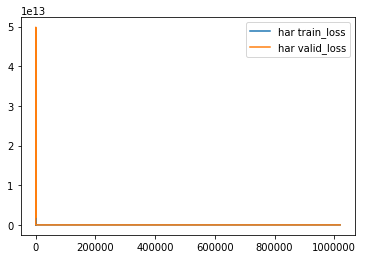

In [22]:
import matplotlib.pyplot as mplot
%matplotlib inline

mplot.plot(train_loss, label='har train_loss')
mplot.plot(valid_loss, label='har valid_loss')
mplot.legend()
mplot.show()

In [23]:
# # initilize the saver which has already been initialized.
# test_loss = []

# with tf.Session() as sess:
#     # Restore the validated model
#     saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
#     ################## Test
#     loss_batch = []    
#     # Loop over batches
#     for X_test_norm_batch, _ in get_batches(X_test_norm, Y_test_onehot, batch_size):

#         # Feed dictionary
#         # No learning/training is needed at this step
#         feed = {Xin: X_test_norm_batch, keep_prob_ : 1.0}

#         # Loss
#         # Only the computation of the cost is needed
#         loss = sess.run(fetches=[cost], feed_dict = feed)
#         loss_batch.append(loss)

#     # Store
#     test_loss.append(np.mean(loss_batch))

#     # Print info for every iter/epoch
#     print("Test loss: {:6f}".format(np.mean(test_loss)))

In [24]:
# W1.shape, W1.dtype # kWidth, kCHin, kCHout(number of filters) 
# W1.shape
# # tf.cast(dtype=tf.int, name=None, x=W1[:, :, 0])
# # mplot.imshow(W1[:, :, 0])
# # mplot.i# Before doing anything, I should transfer the tensor/variable data from TF to NP to be able to use matplotlib 
# # for visualizing mat or np mat
# # initilize the saver which has already been initialized.
# # test_loss = []
# # W1np, W2np, W3np are all needed to be taken out of tensorflow tensors or framework
# # W1np, W2np, W3np = 
# # np.array([*W1.shape])

with tf.Session() as sess:
    # Restore the validated model
    saver.restore(sess=sess, save_path=tf.train.latest_checkpoint('checkpoints'))
    W1np, W2np, W3np = sess.run(fetches=[W1, W2, W3])

INFO:tensorflow:Restoring parameters from checkpoints/cnn-fnirs-autoencoder.ckpt


In [25]:
print('W1np.shape, W1np.dtype, W2np.shape, W2np.dtype, W3np.shape, W3np.dtype:', 
      W1np.shape, W1np.dtype, W2np.shape, W2np.dtype, W3np.shape, W3np.dtype)
print('WidthxChinxChout')

W1np.shape, W1np.dtype, W2np.shape, W2np.dtype, W3np.shape, W3np.dtype: (62, 40, 80) float32 (31, 80, 160) float32 (15, 160, 320) float32
WidthxChinxChout


In [26]:
W=W1np
num_filters_1st_layer = W.shape[1]*W.shape[2]
print('num_filters_1st_layer:', num_filters_1st_layer)

num_filters_1st_layer: 3200


In [27]:
W=W2np
num_filters_2nd_layer = W.shape[1]*W.shape[2]
print('num_filters_2nd_layer:', num_filters_2nd_layer)

num_filters_2nd_layer: 12800


In [28]:
W=W3np
num_filters_3rd_layer = W.shape[1]*W.shape[2]
print('num_filters_3rd_layer:', num_filters_3rd_layer)

num_filters_3rd_layer: 51200


In [29]:
# total_num_filters for all three layers
total = num_filters_1st_layer+num_filters_2nd_layer+num_filters_3rd_layer
print('total:', total)

total: 67200


In [30]:
# Wnp = W1np
# mplot.figure(0)
# mplot.plot(Wnp[:, 0, 0])
# mplot.figure(1)
# mplot.plot(Wnp[:, 1, 0])
# mplot.figure(2)
# mplot.plot(Wnp[:, 2, 0])
# mplot.figure(3)
# mplot.plot(Wnp[:, 3, 0])

In [31]:
# Wnp = W2np
# mplot.figure(0)
# mplot.plot(Wnp[:, 0, 0])
# mplot.figure(1)
# mplot.plot(Wnp[:, 1, 0])
# mplot.figure(2)
# mplot.plot(Wnp[:, 2, 0])
# mplot.figure(3)
# mplot.plot(Wnp[:, 3, 0])

In [32]:
# Wnp = W3np
# # mplot.figure(0)
# # mplot.subplot()
# mplot.subplots()
# mplot.plot(Wnp[:, 0, 0])
# mplot.subplots()
# mplot.plot(Wnp[:, 1, 0])
# # mplot.figure(2)
# # mplot.plot(Wnp[:, 2, 0])
# # mplot.figure(3)
# # mplot.plot(Wnp[:, 3, 0])

/home/arasdar/anaconda3/envs/arasdar-DL-env/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


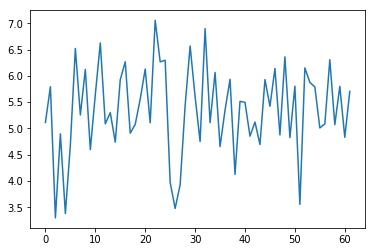

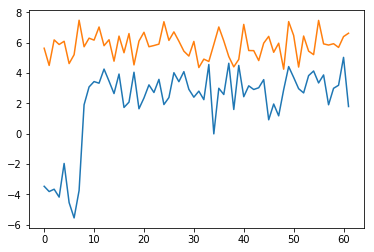

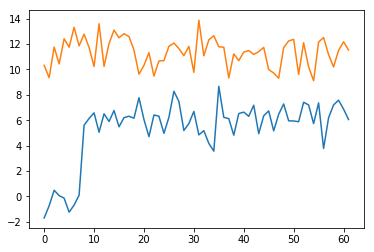

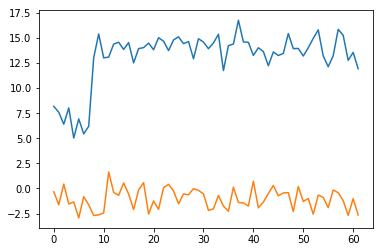

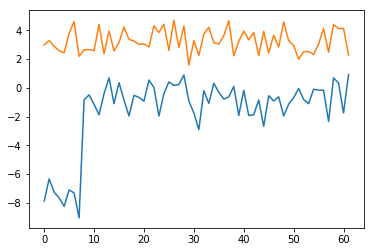

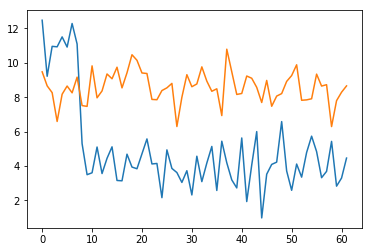

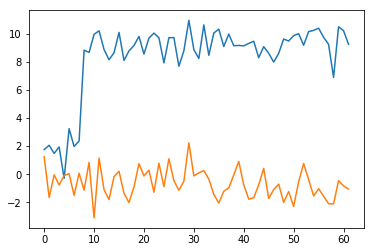

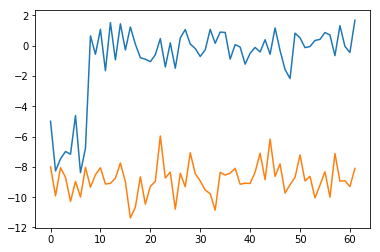

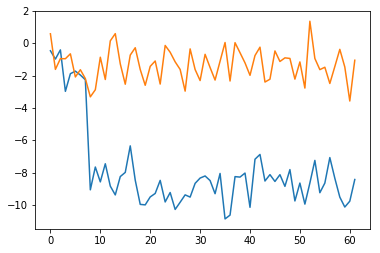

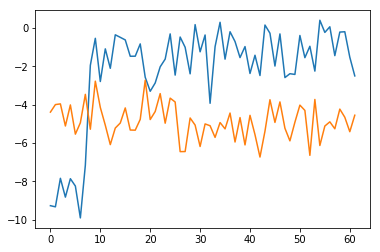

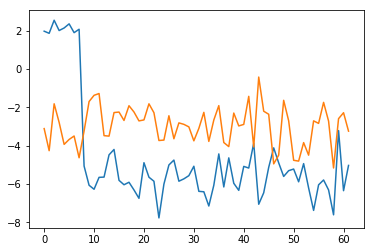

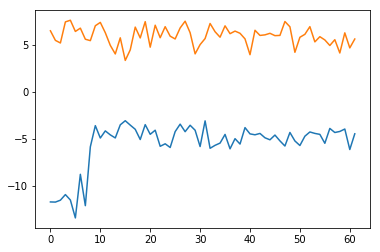

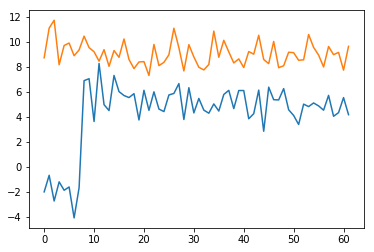

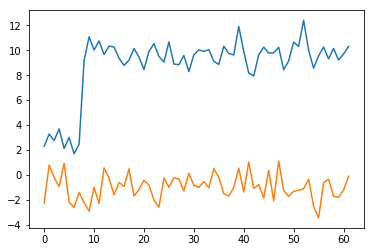

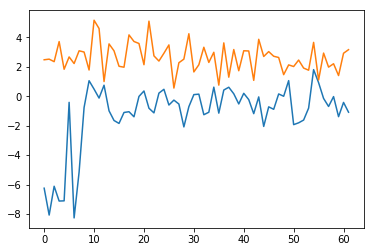

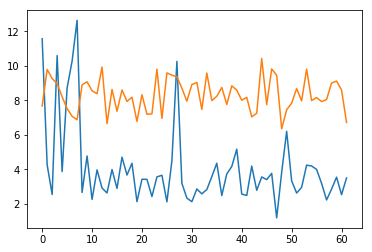

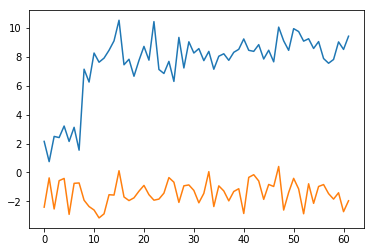

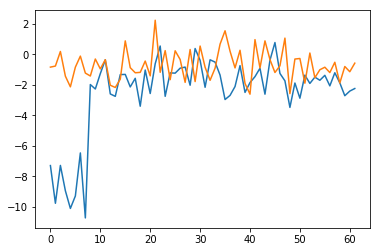

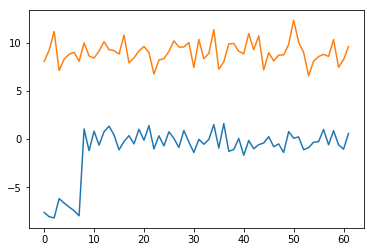

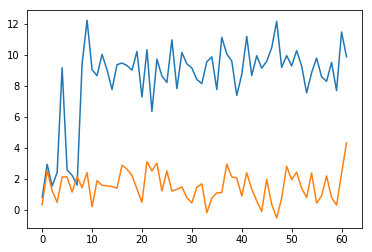

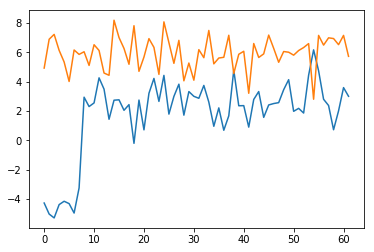

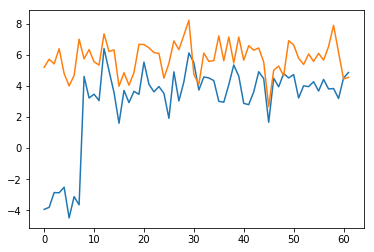

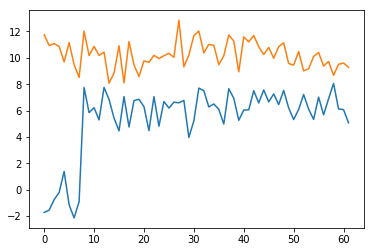

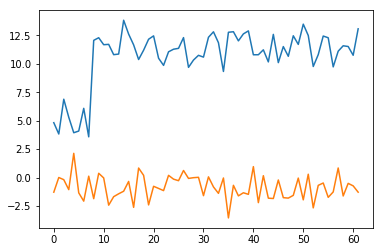

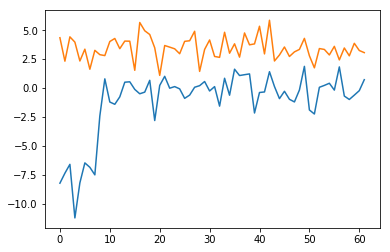

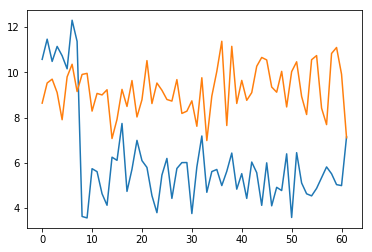

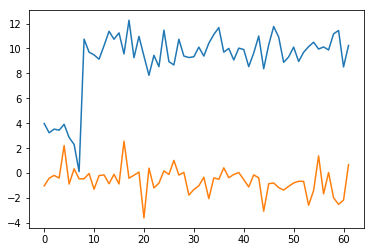

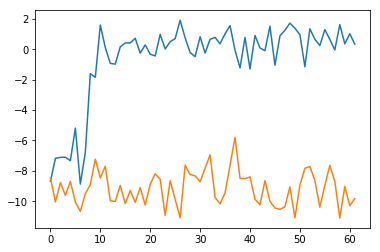

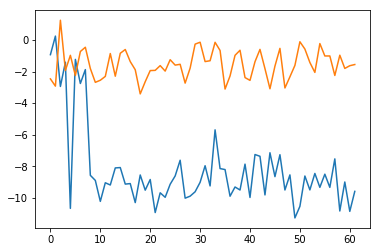

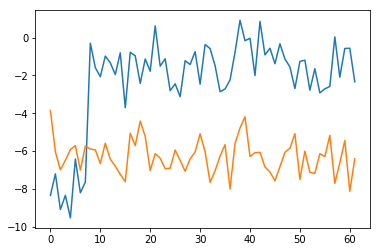

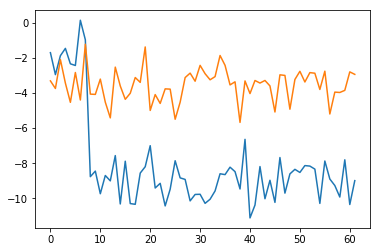

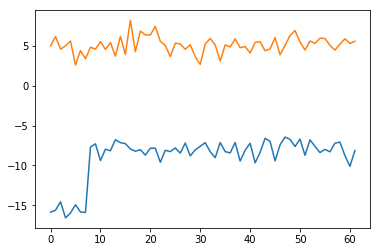

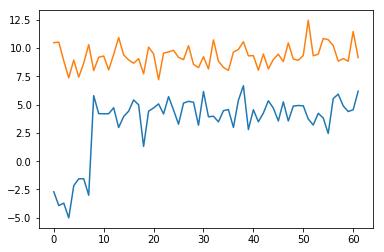

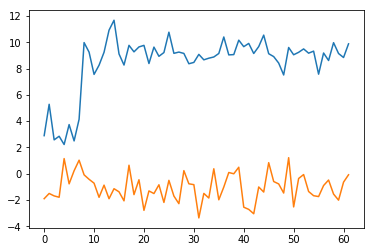

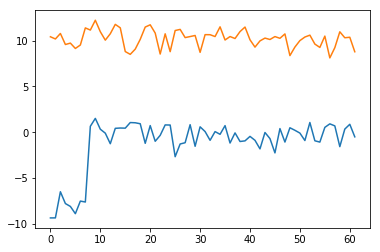

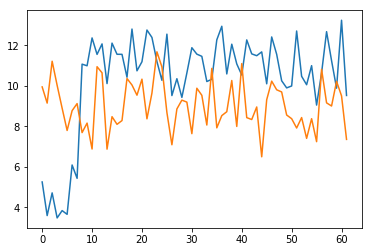

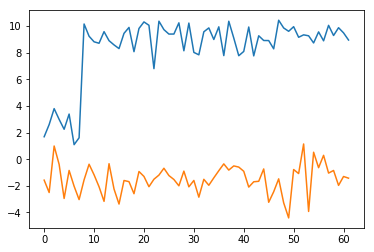

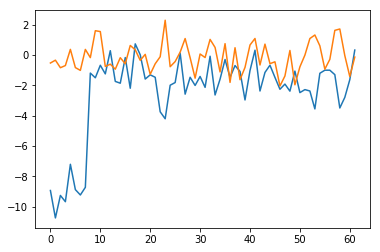

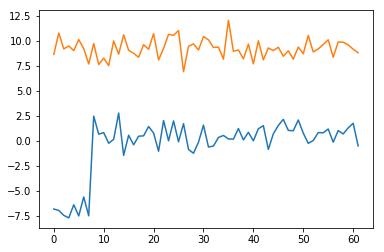

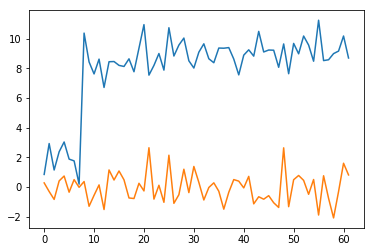

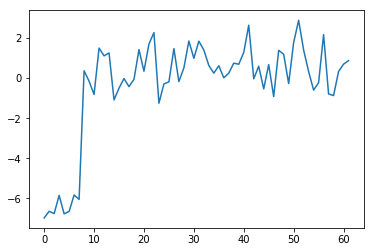

In [37]:
W = W1np
for each_CHin in range(W.shape[1]):
#     each_CHout = 0
    for each_CHout in range(2):
        mplot.figure(num=(each_CHin + each_CHout))
        mplot.plot(W[:, each_CHin, each_CHout])

/home/arasdar/anaconda3/envs/arasdar-DL-env/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


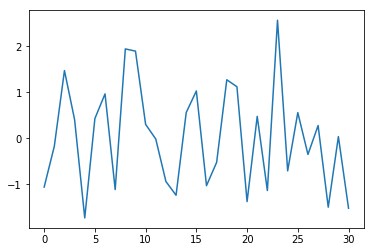

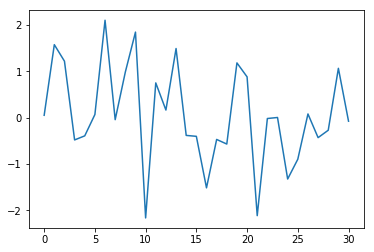

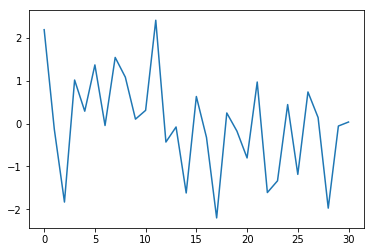

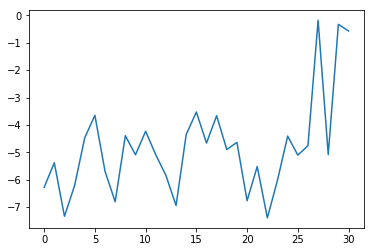

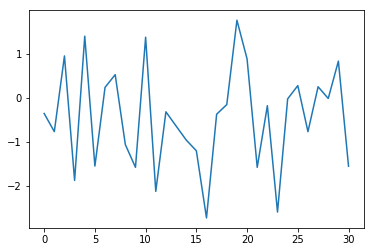

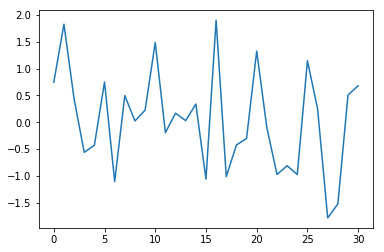

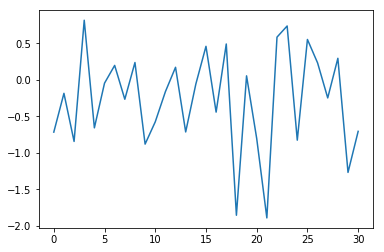

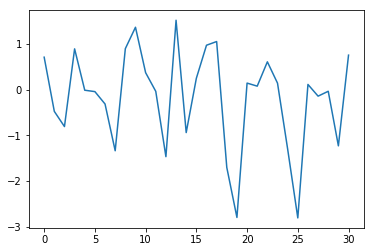

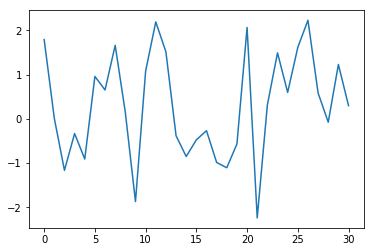

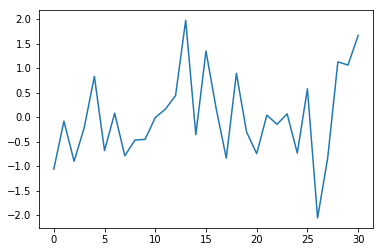

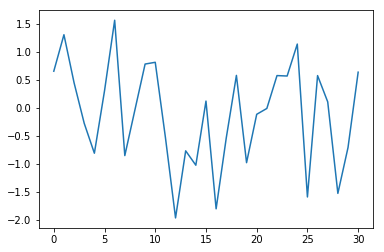

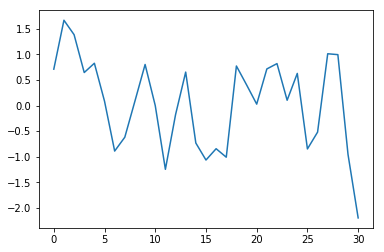

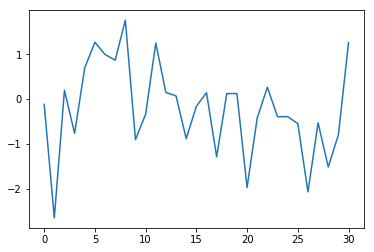

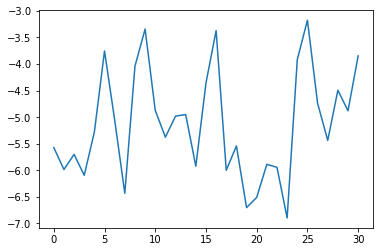

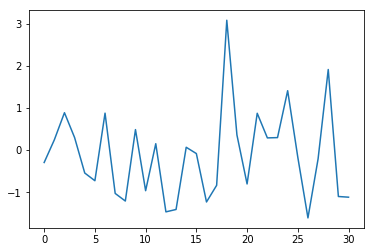

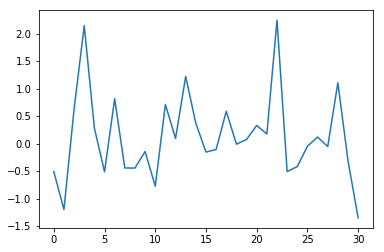

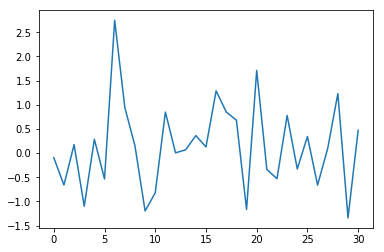

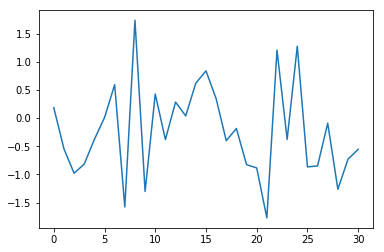

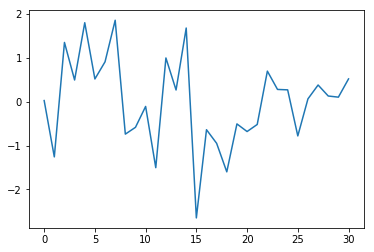

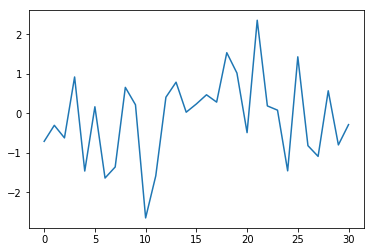

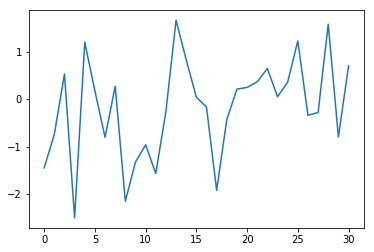

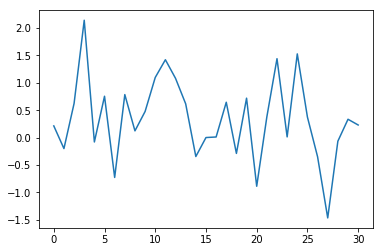

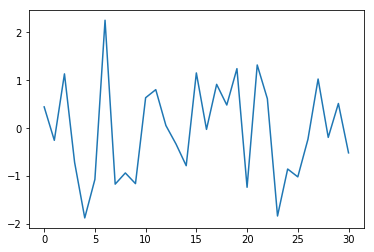

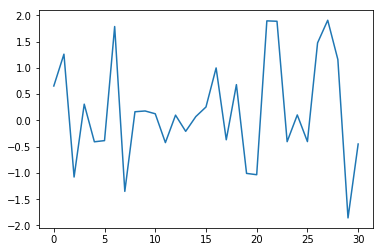

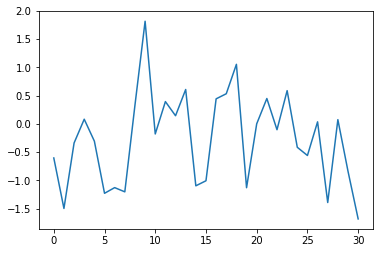

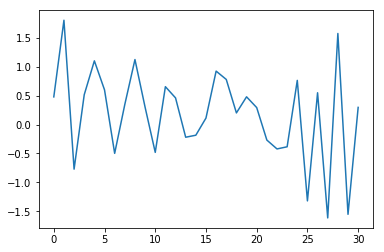

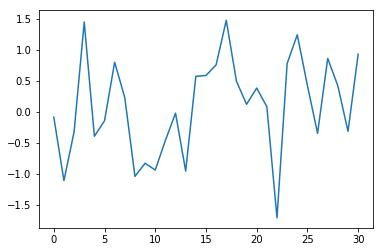

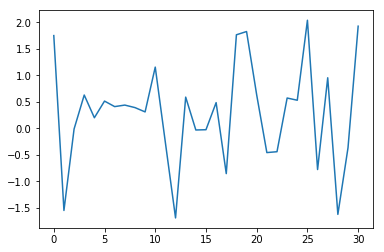

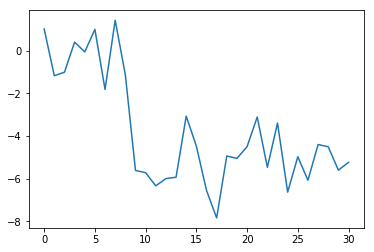

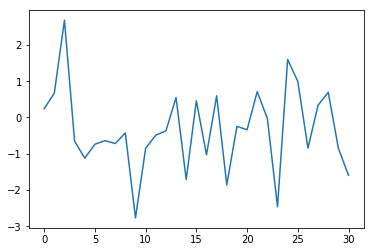

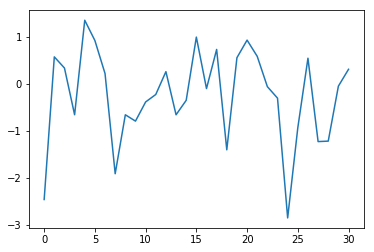

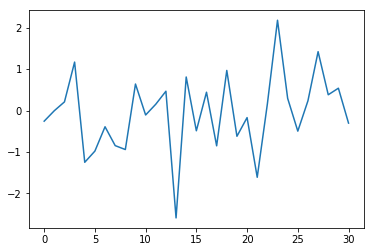

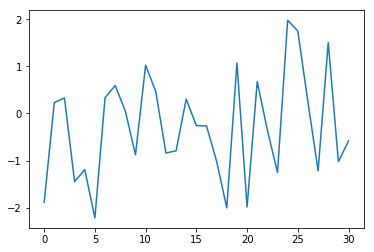

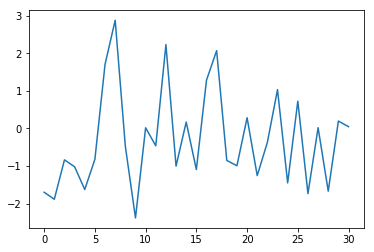

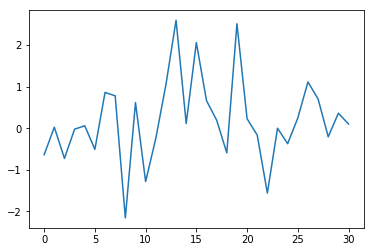

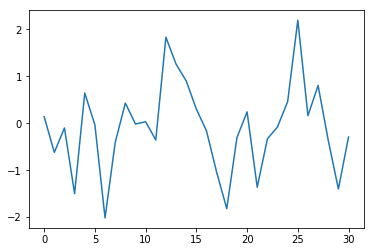

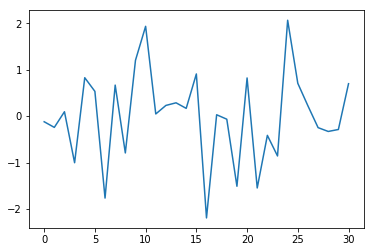

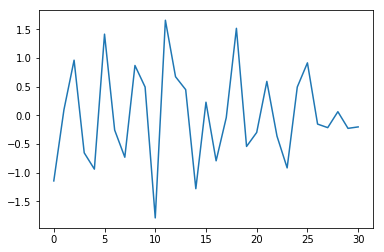

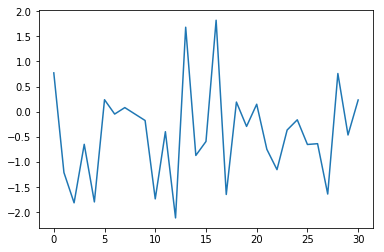

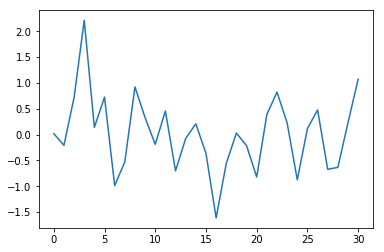

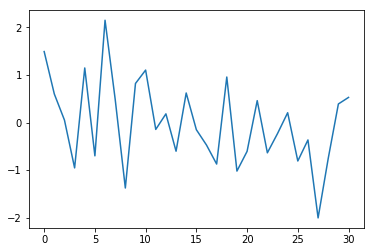

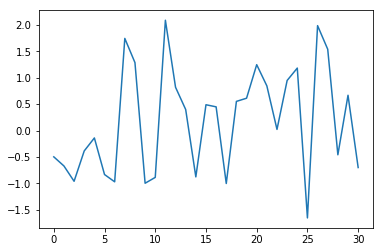

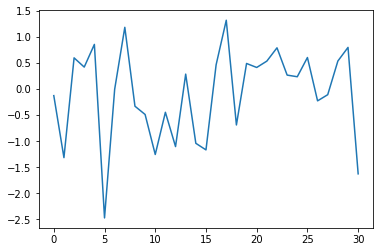

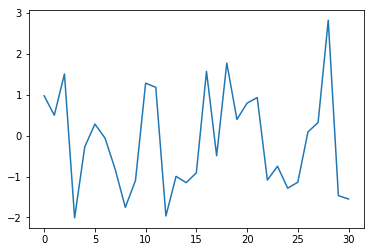

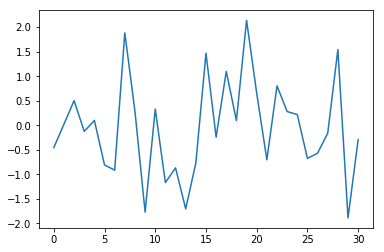

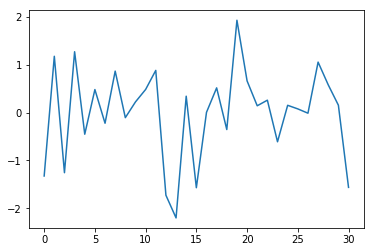

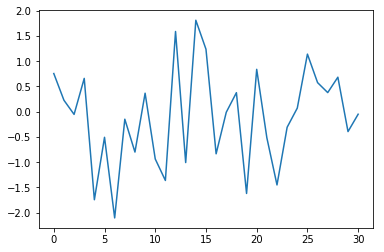

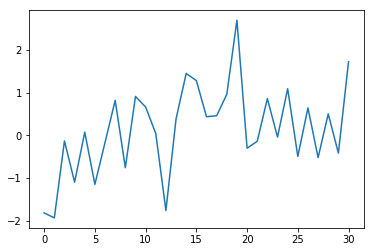

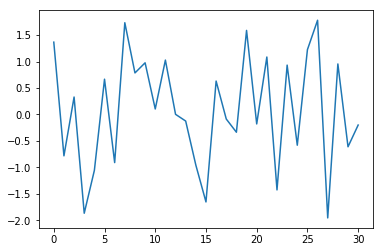

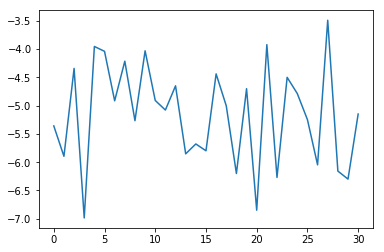

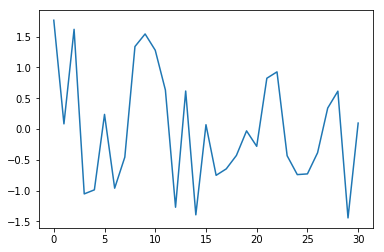

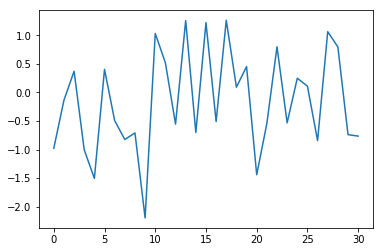

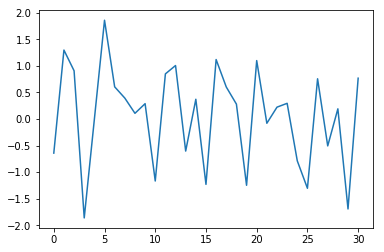

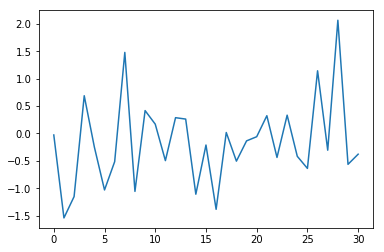

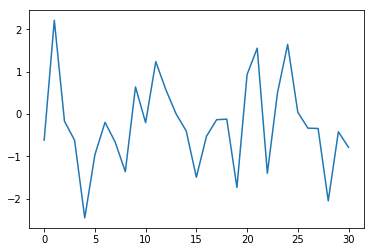

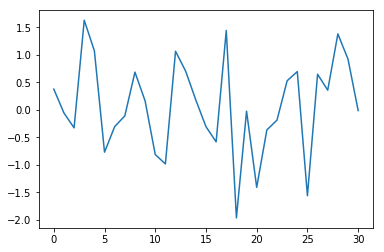

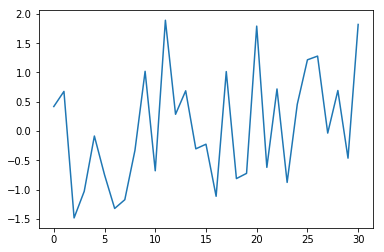

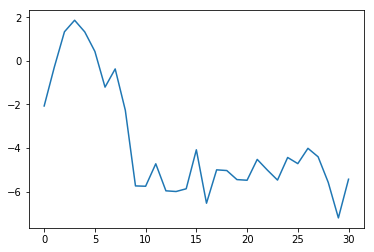

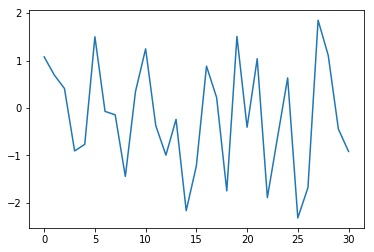

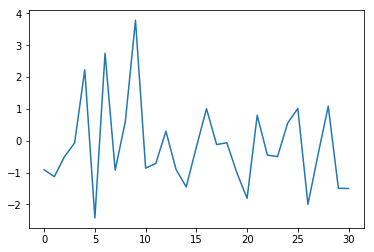

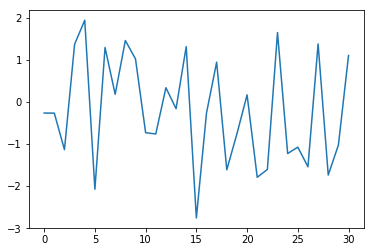

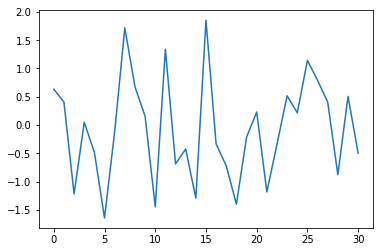

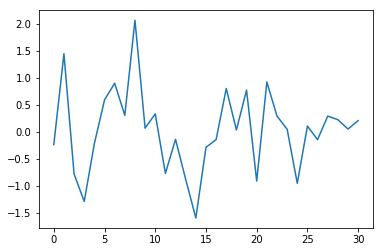

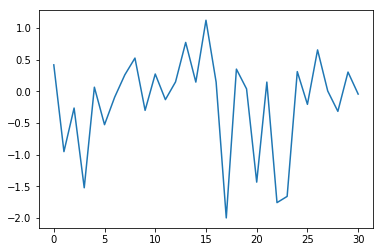

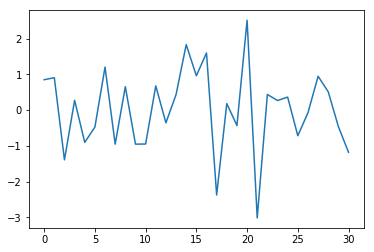

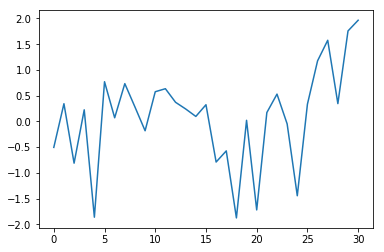

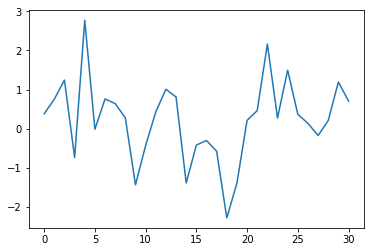

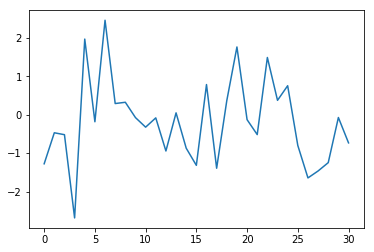

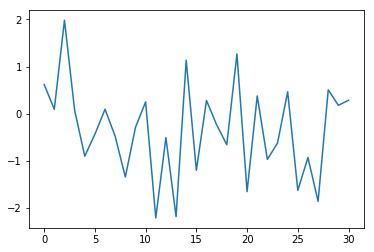

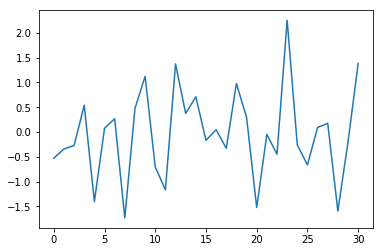

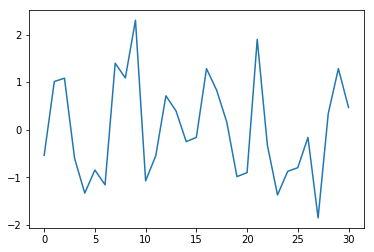

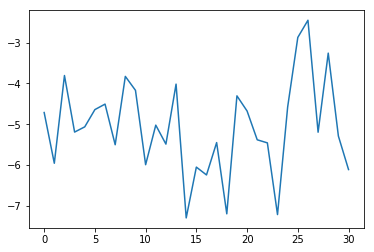

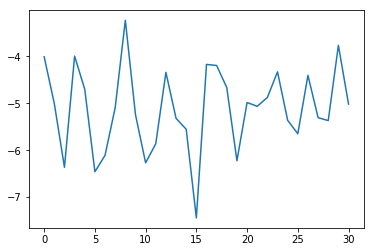

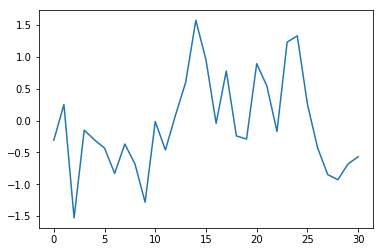

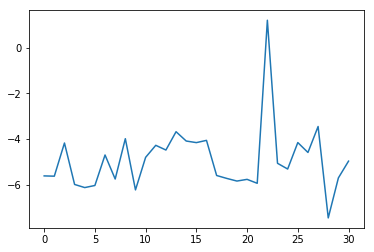

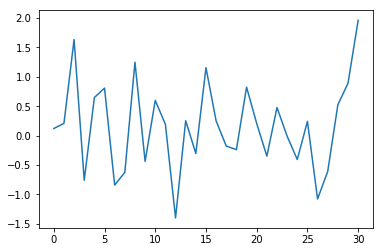

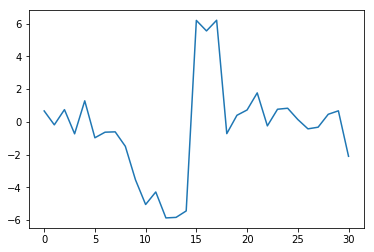

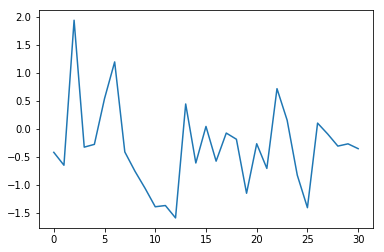

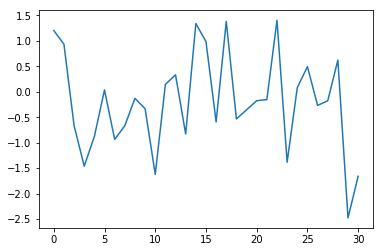

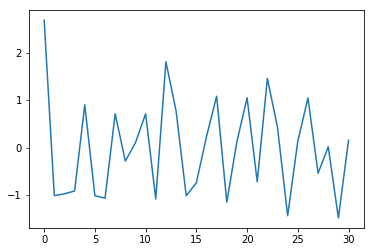

In [34]:
W = W2np
for each_CHin in range(W.shape[1]):
    each_CHout = 0
    # for each_CHout in range(W.shape[2]):
    mplot.figure(each_CHin + each_CHout)
    mplot.plot(W[:, each_CHin, each_CHout])

/home/arasdar/anaconda3/envs/arasdar-DL-env/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


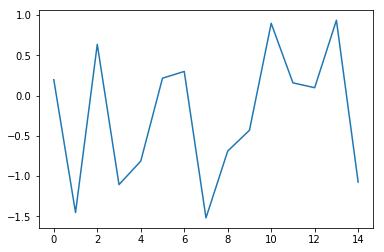

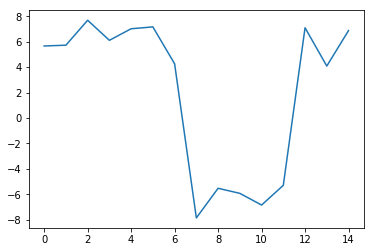

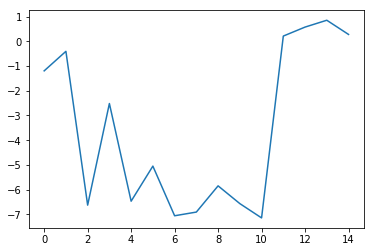

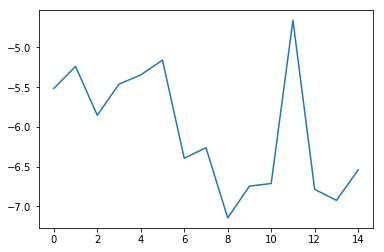

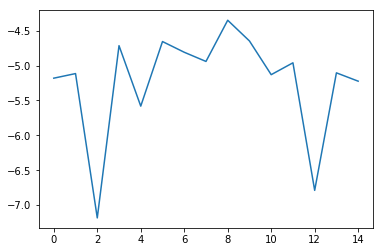

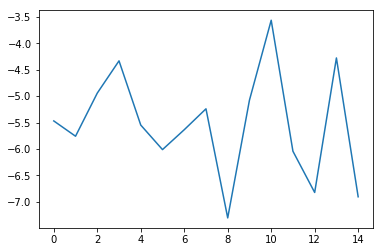

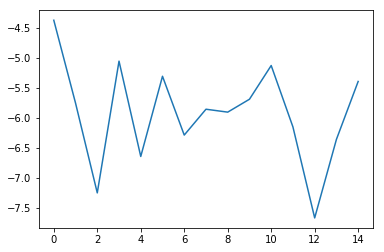

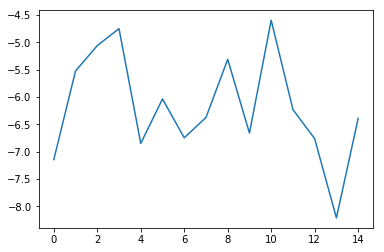

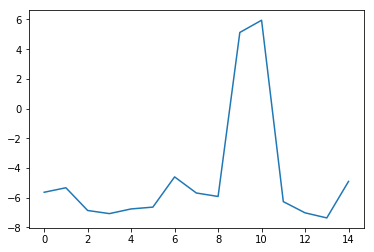

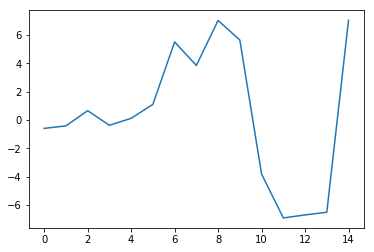

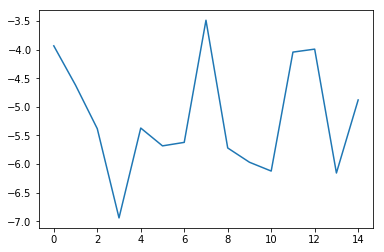

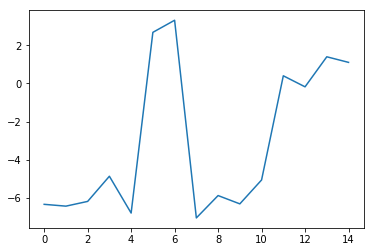

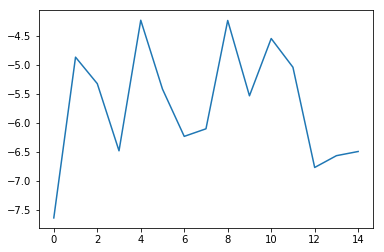

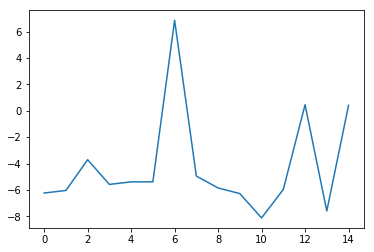

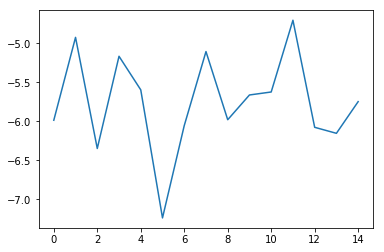

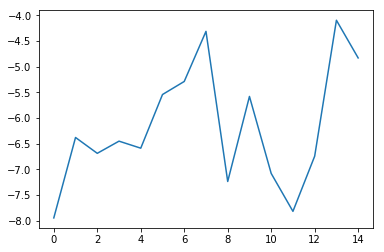

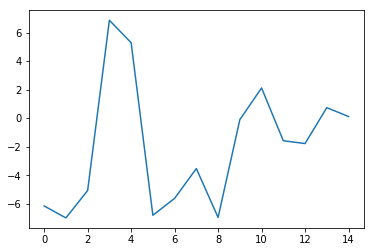

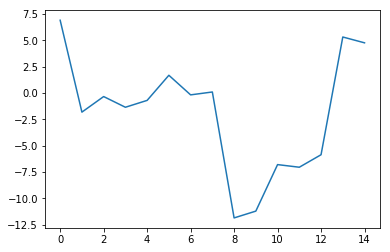

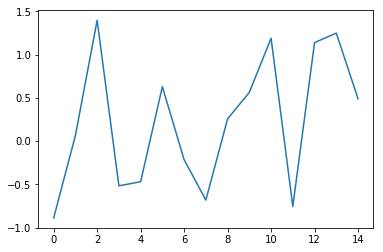

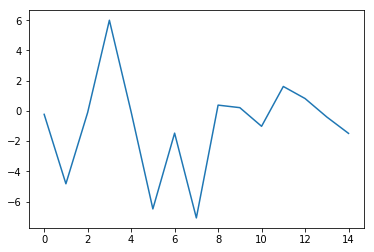

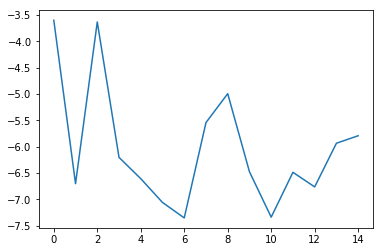

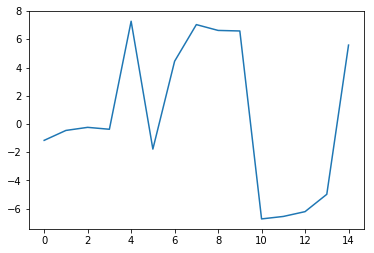

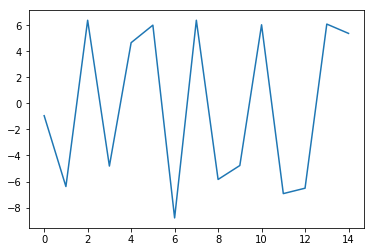

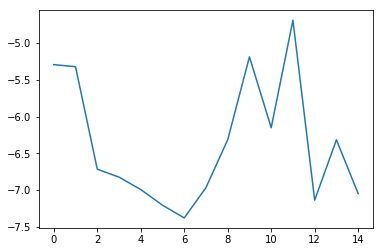

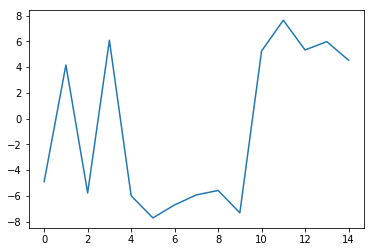

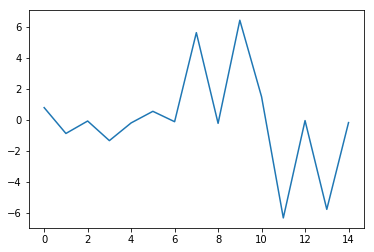

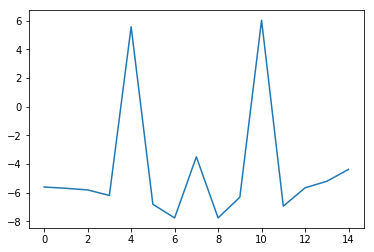

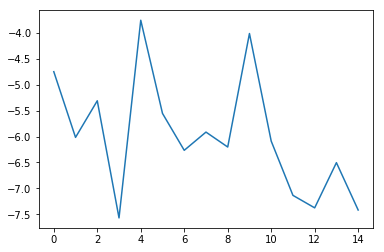

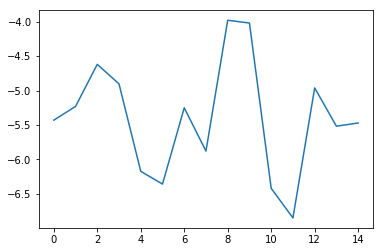

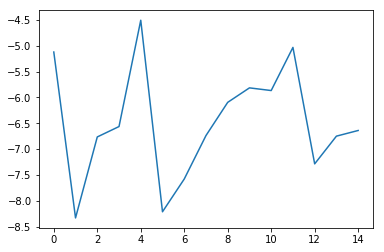

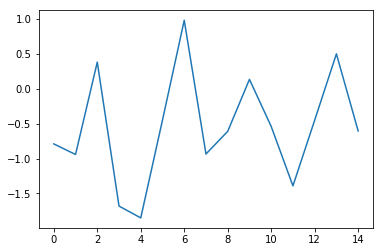

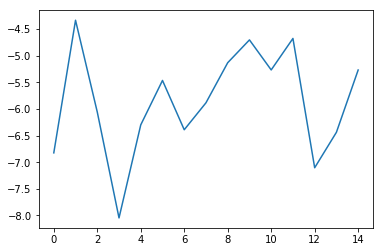

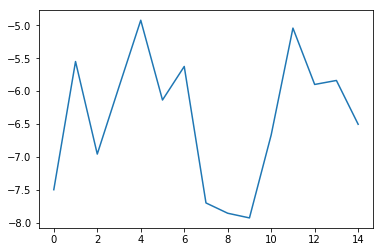

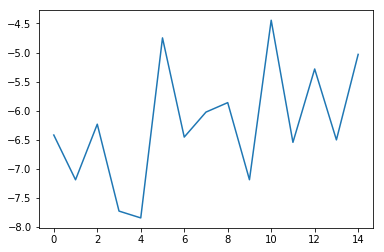

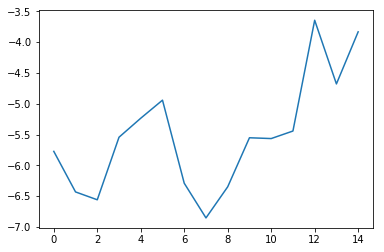

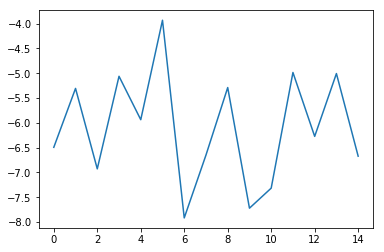

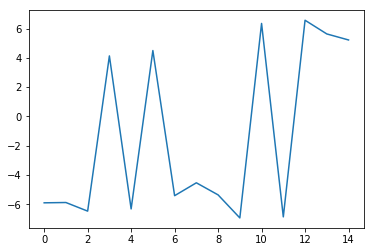

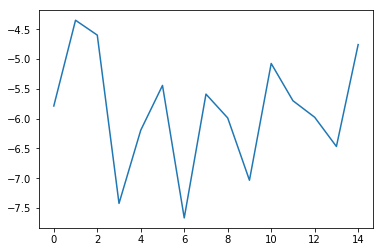

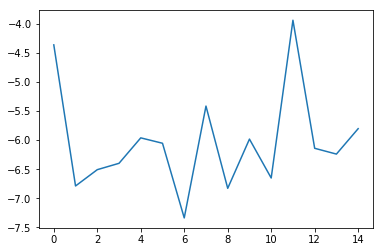

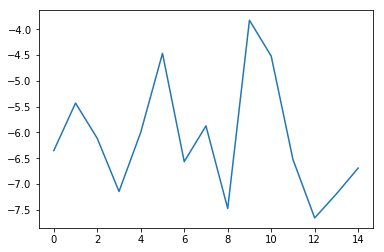

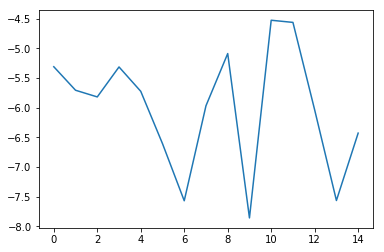

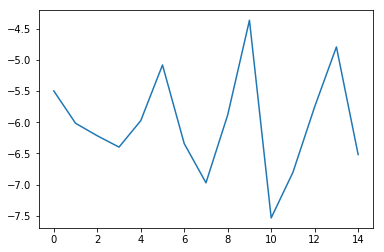

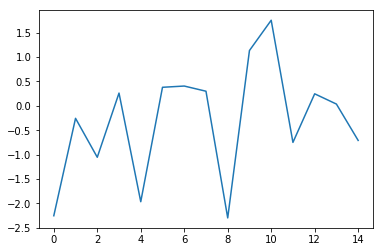

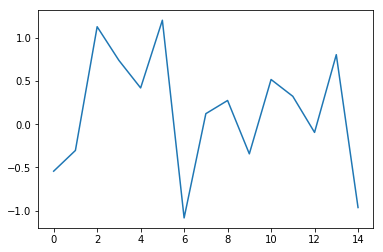

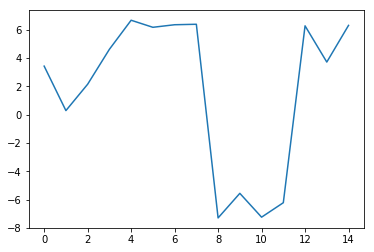

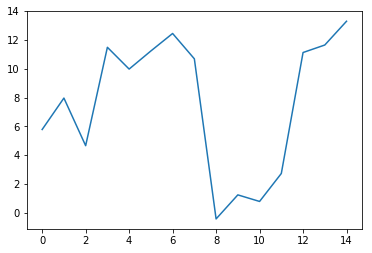

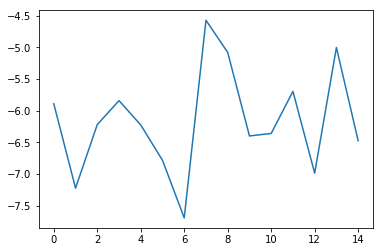

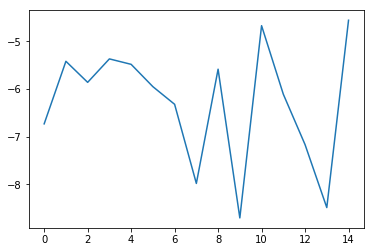

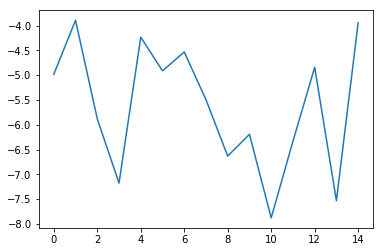

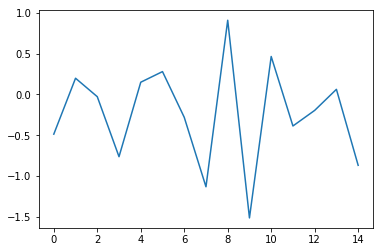

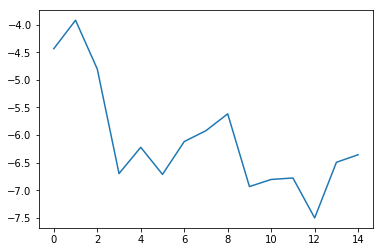

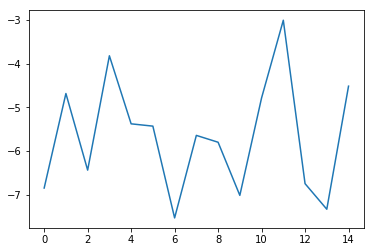

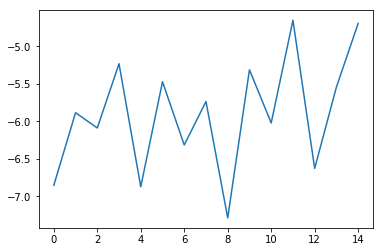

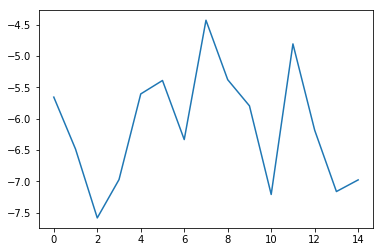

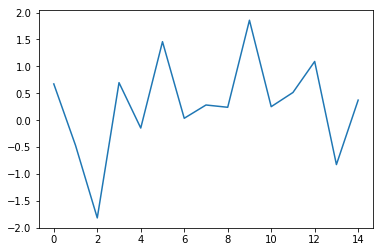

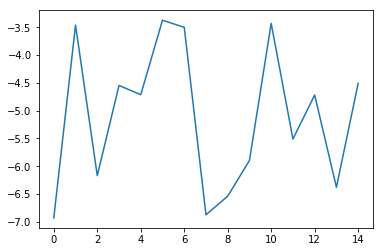

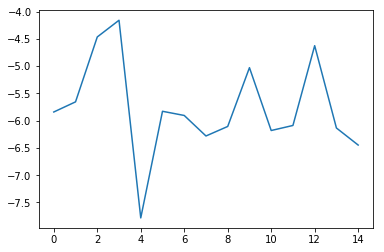

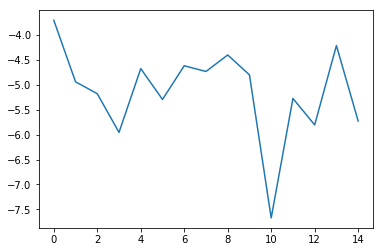

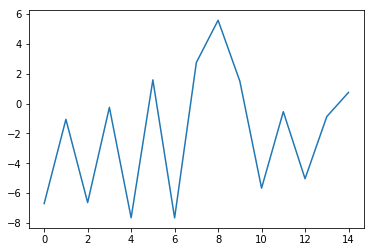

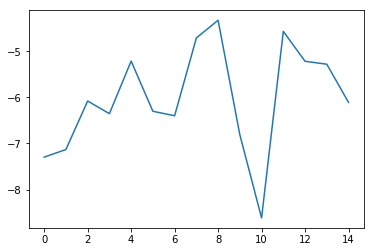

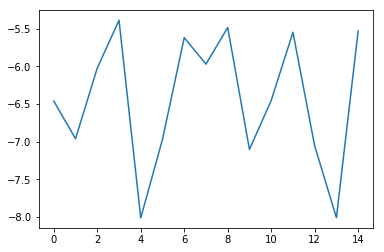

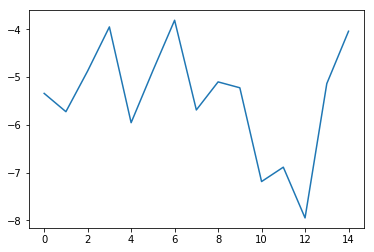

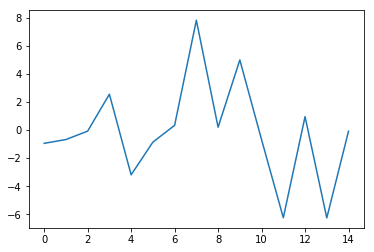

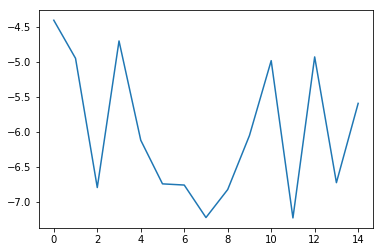

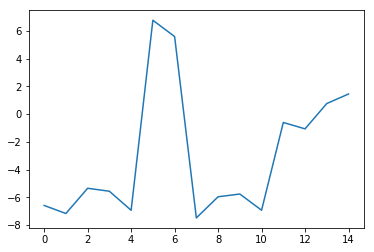

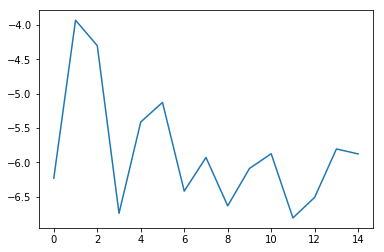

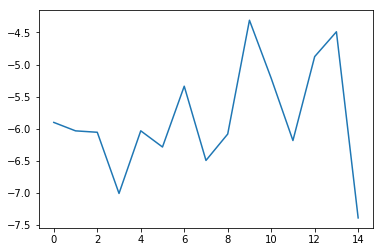

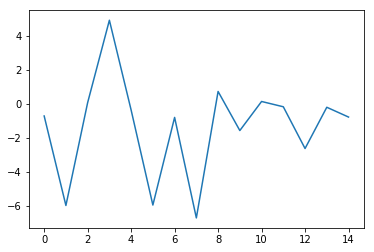

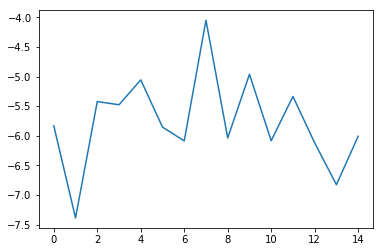

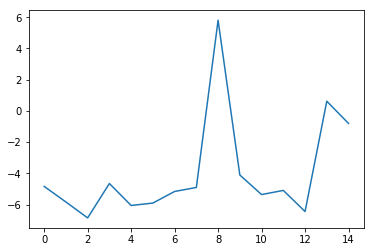

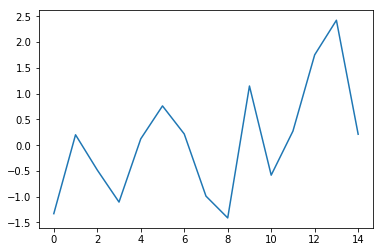

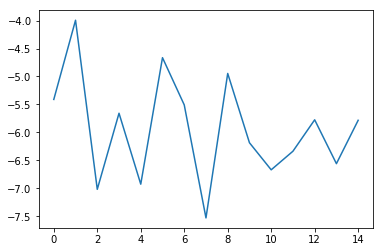

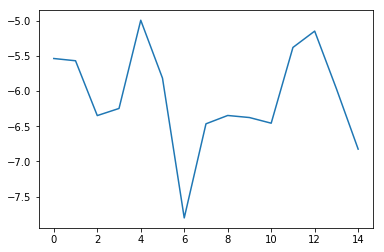

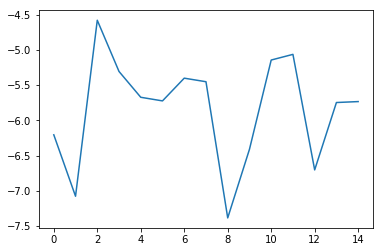

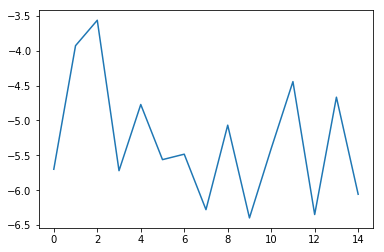

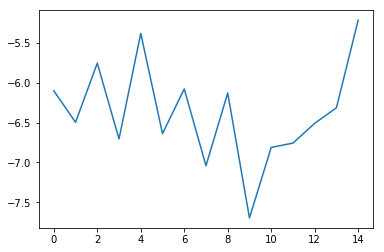

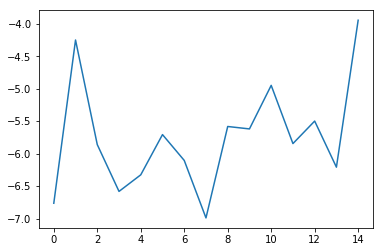

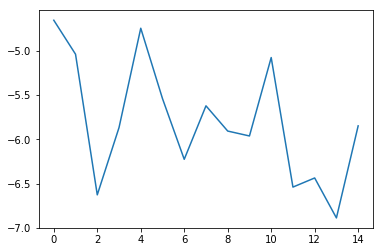

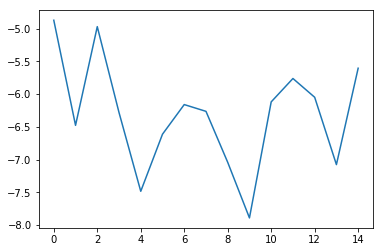

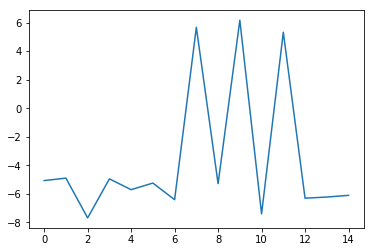

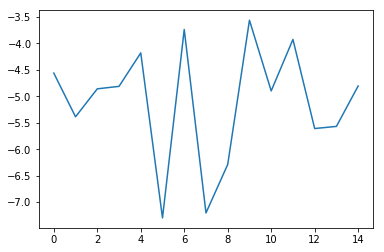

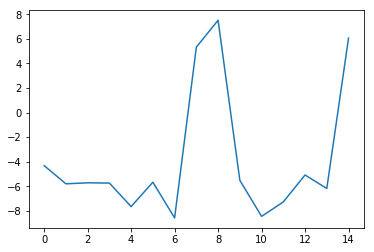

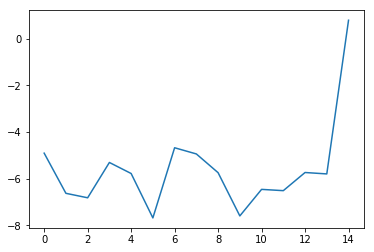

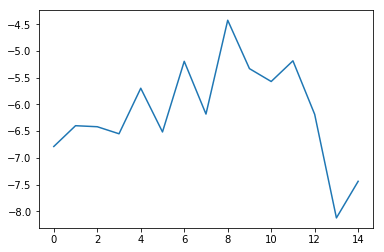

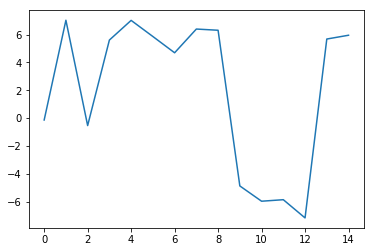

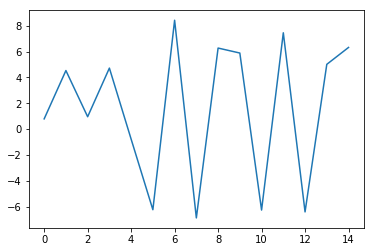

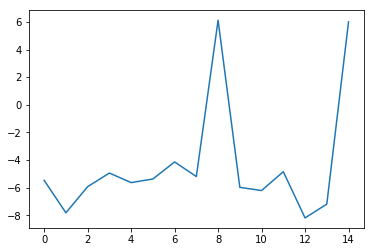

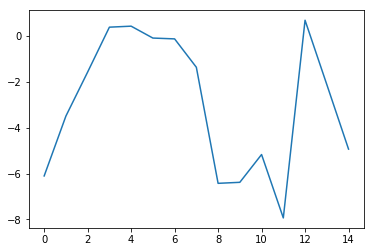

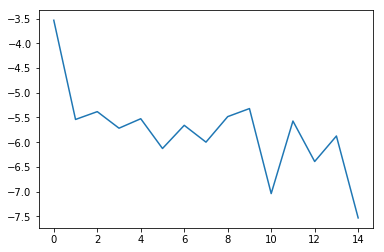

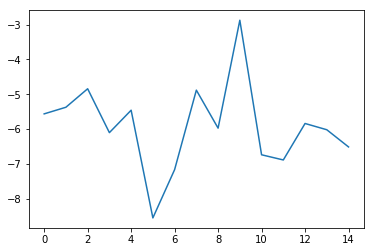

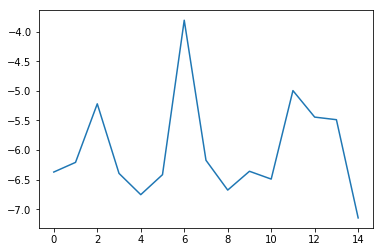

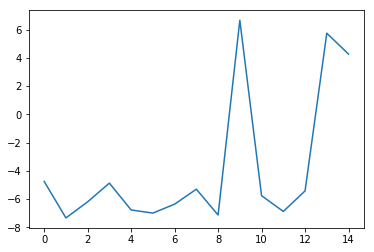

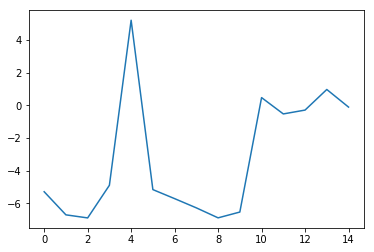

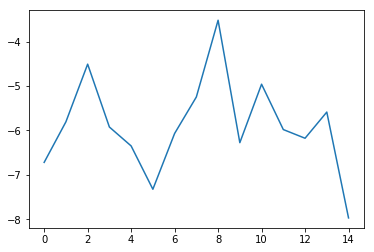

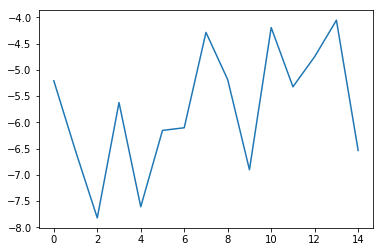

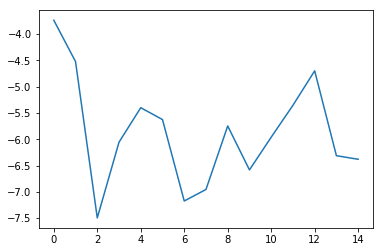

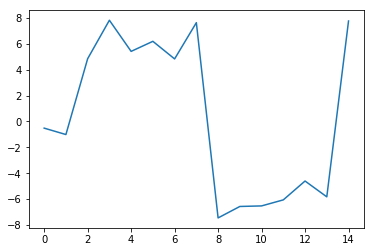

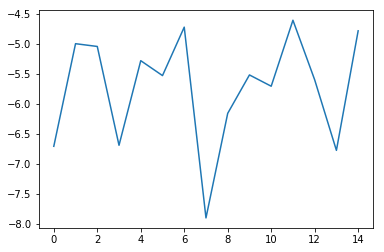

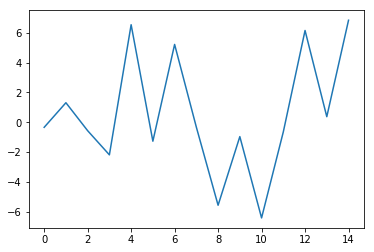

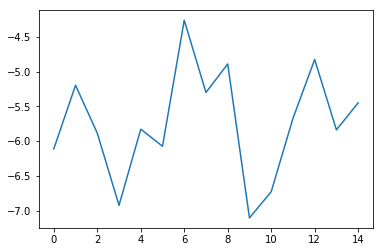

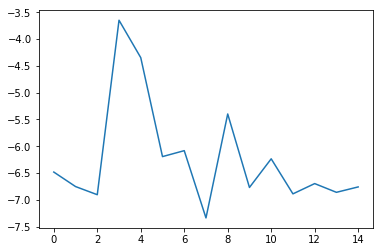

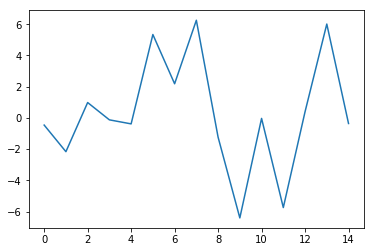

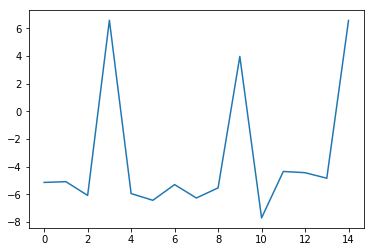

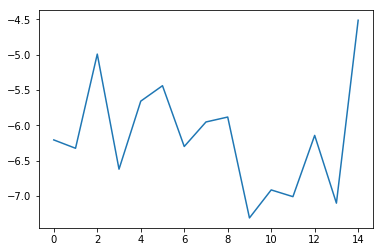

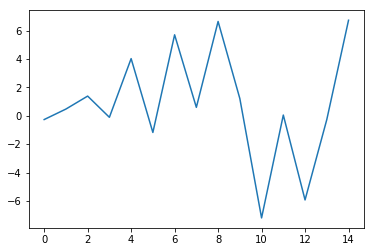

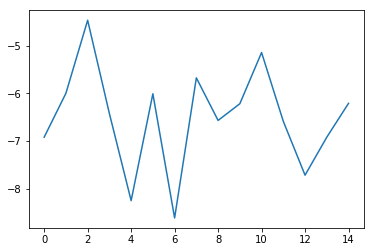

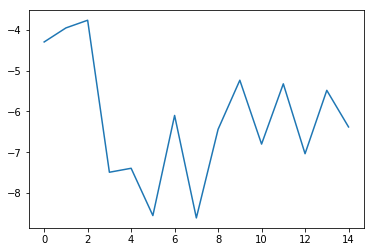

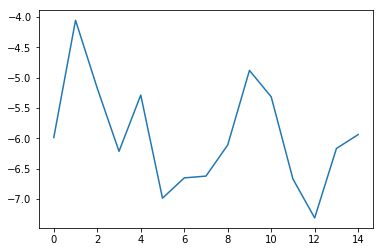

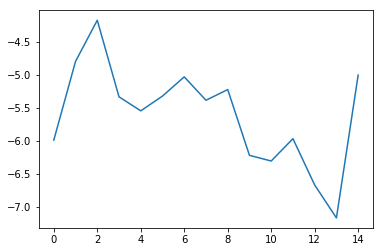

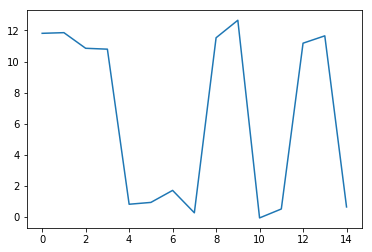

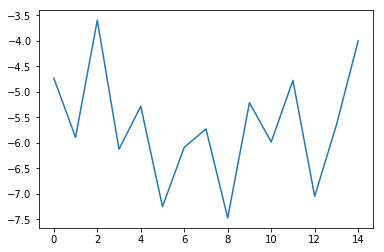

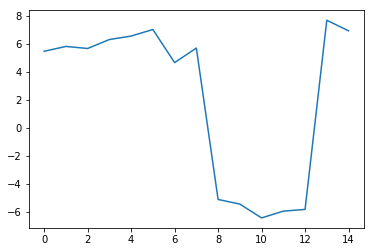

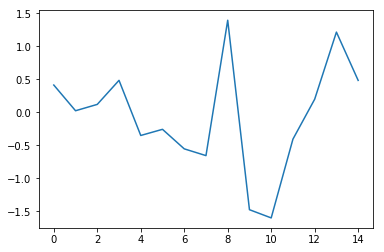

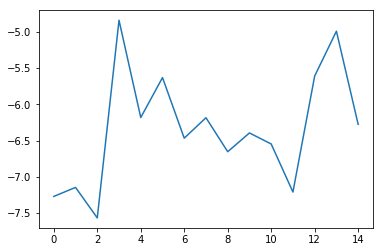

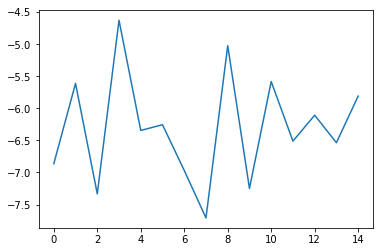

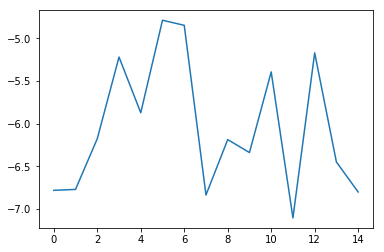

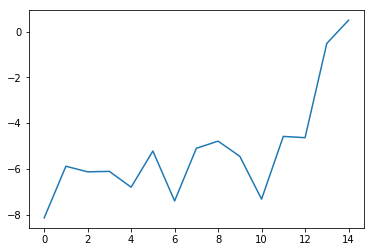

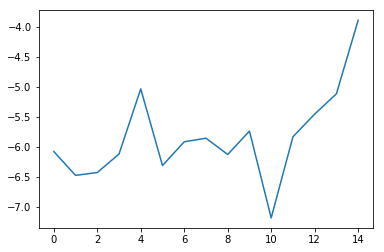

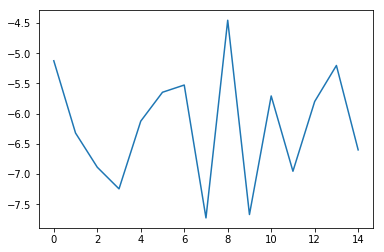

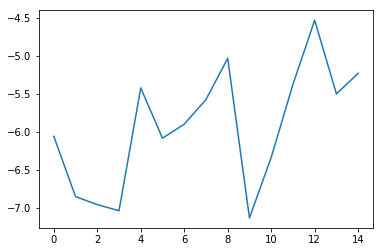

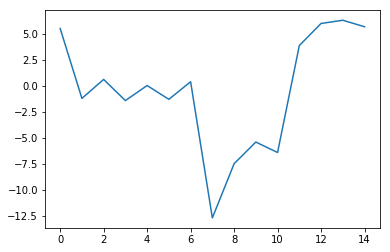

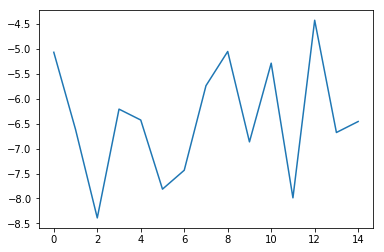

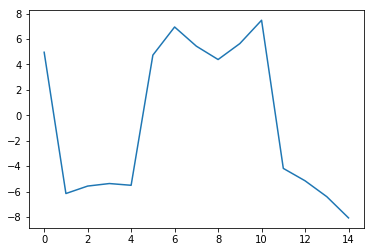

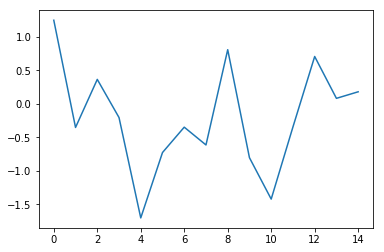

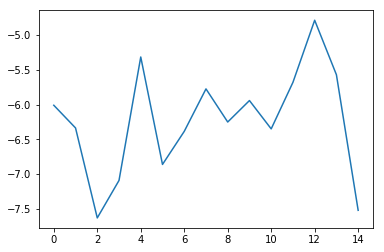

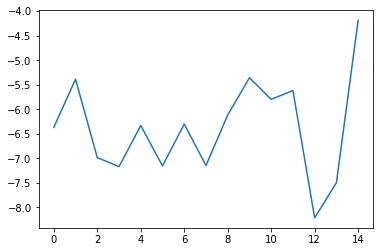

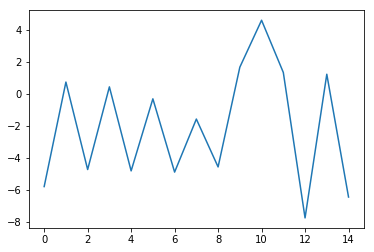

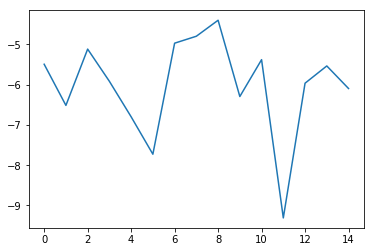

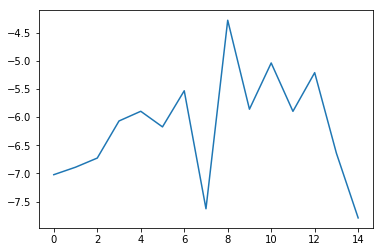

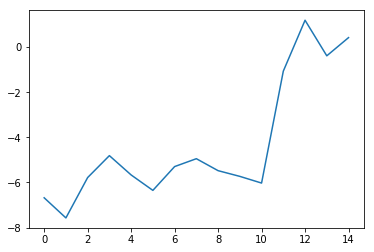

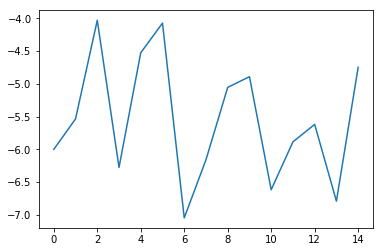

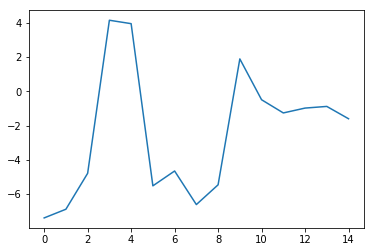

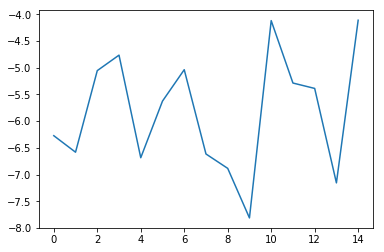

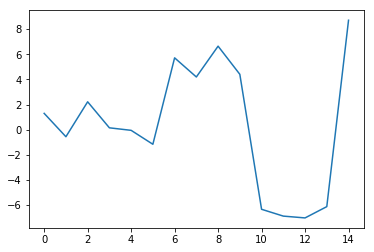

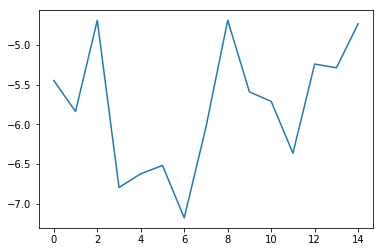

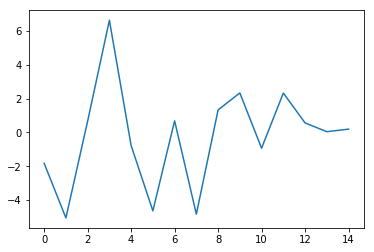

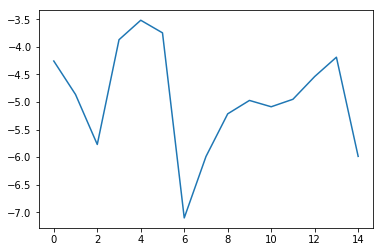

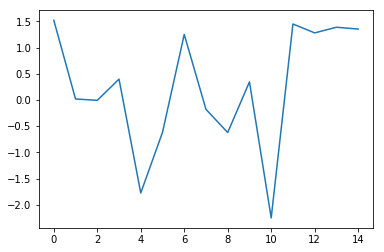

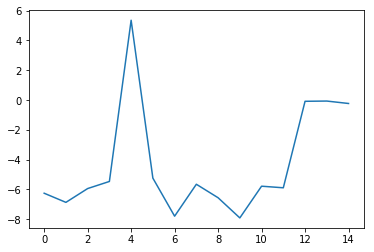

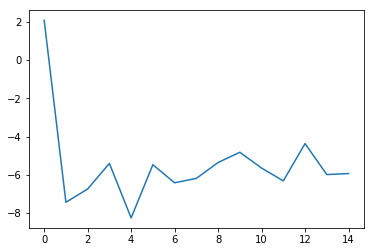

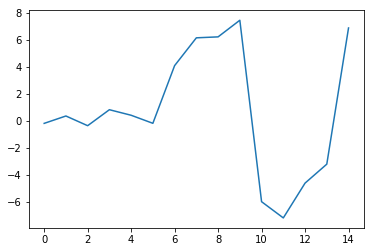

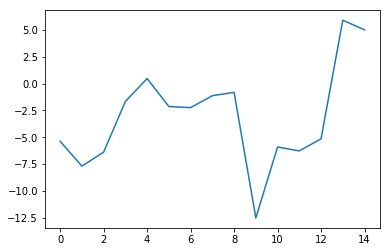

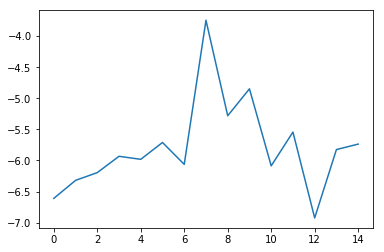

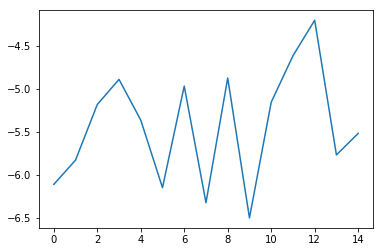

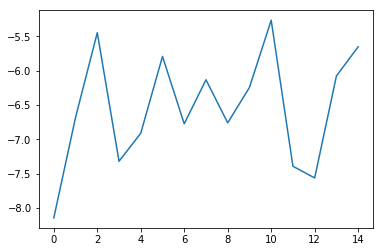

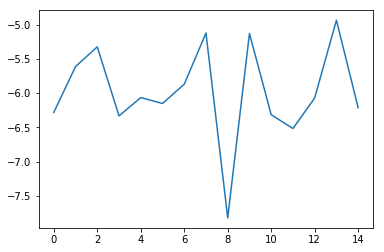

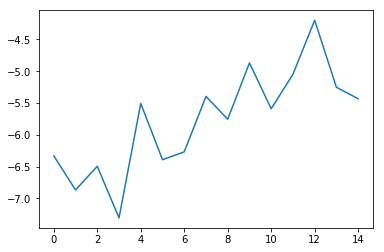

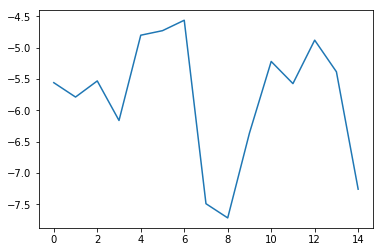

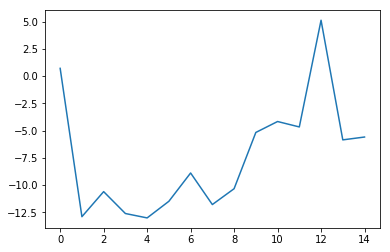

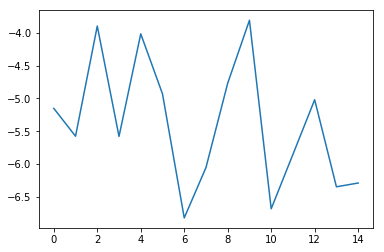

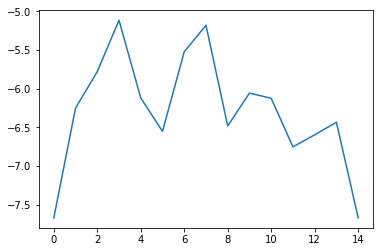

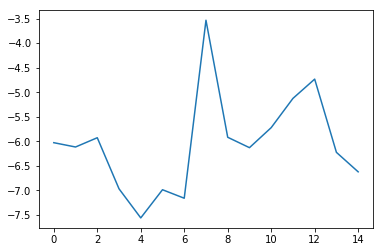

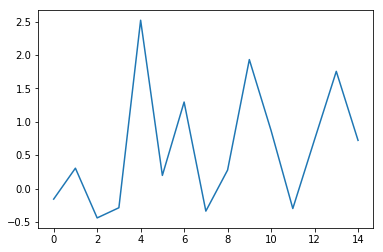

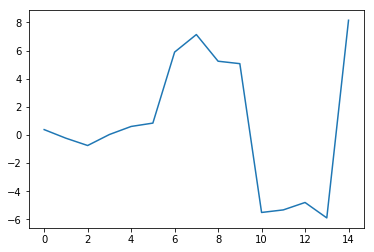

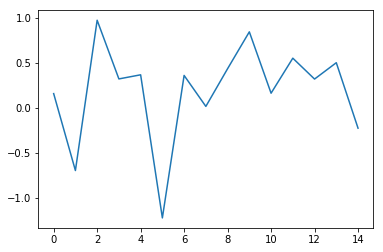

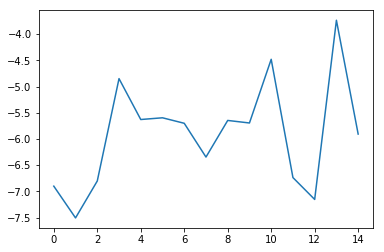

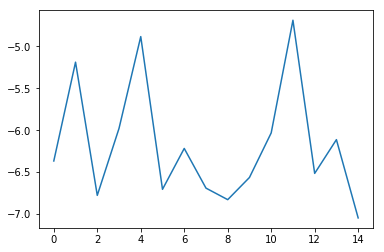

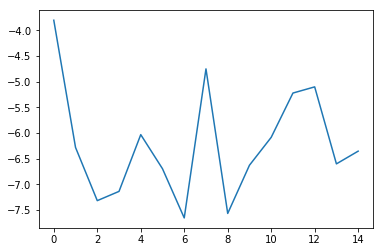

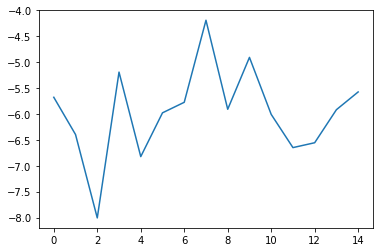

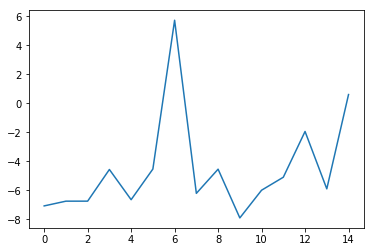

In [35]:
W = W3np
for each_CHin in range(W.shape[1]):
    each_CHout = 0
    # for each_CHout in range(W.shape[2]):
    mplot.figure(each_CHin + each_CHout)
    mplot.plot(W[:, each_CHin, each_CHout])